# Quantamental Trading

In this notebook, we have developed a trading Strategy by using the Fundamental data and some Quant Techniques. Notebook is divided in two parts, Strategy Formulation the Backtesting.

#### Import the relevant Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import yfinance as yf
from datetime import date
from datetime import datetime, timedelta
import seaborn as sb
import monthly_returns_heatmap as mrh
import fundamentalanalysis as fa
import seaborn as sb
import quantstats as qs
sb.set_style('darkgrid')
import matplotlib.font_manager as fm
import warnings
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import itertools

warnings.filterwarnings('ignore')

In [2]:
# tem que ser a versão 1.3.5
pd.__version__

'1.3.5'

In [65]:
!python --version


Python 3.9.7


# Strategy Formulation

## Analysis on Group of Companies taking latest Ratios
We will do the inter-company analysis to find the relatively undervalued companies among its peers. We will be using the Z-score method to calculate the scores of the companies and rank them accordingly.

In [2]:
key = '15d3a78098390cc68b5bf8132b213ae7'

In [3]:
"Reference from S&P Value bse Factor indices"

# Z-score testing to compare the company with its peer
def zscore2(data_frame, headline='Z-Score'):
    index = data_frame.index
    z = scipy.stats.zscore(data_frame.astype(float))
    table = pd.DataFrame(z, index=index)
    mean = table.mean(axis=1)
    table2 = pd.DataFrame(mean, index=index)
    condition1 = np.where(table2 == 0, 1, table2)
    condition2 = np.where(condition1 > 0, 1 + condition1, 1/(1 - condition1))
    final = pd.DataFrame(condition2, index=index)
    final.columns = [headline]
    return final

# função para ajustar os pesos excederem 20%
def normaliza(Pesos):

    Pesos_ajustados = [min(peso, 0.20 * sum(Pesos)) for peso in Pesos]
    ajustar = 1 - sum(Pesos_ajustados)
    quant = sum(1 for valor in Pesos_ajustados if valor < 0.20)
    Pesos_ajustados = [valor + ajustar/quant if valor < 0.20 else valor for valor in Pesos_ajustados]
    
    if any(valor > 0.2 for valor in Pesos_ajustados):
        return normaliza(Pesos_ajustados)
    else:
        return Pesos_ajustados

### Testes

In [11]:
# Using top Nasdaq stocks
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# Ratios where the denominator must be high, to derive the value
ratio = ['peRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA']

f = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    table = data.T[ratio]
    f_1 = table.head(1)
    f = f.append(f_1)

f.index = tickers
# Derive the value metrics out of the algorithm "Inter Company Analysis"
inverse = 1/f

# Inverse matrix consist of the ratios that must be maximised as we have already taken the Reciprocal
inverse

peRatio   pbRatio evToSales debtToEquity debtToAssets netDebtToEBITDA
GILD  0.043424  0.219135  0.056326     0.793008     2.343496        0.098296
MU   -0.100126  0.600719  0.046821     3.278813     4.742923        0.085714
AMAT  0.066165  0.148388  0.068857     2.497172     5.141746        1.906542
MSFT  0.031729   0.08146  0.021976     3.439056     6.870274        1.113495
AMD   0.000588  0.300268  0.029342    19.278322    23.764685       -0.916412
CSCO  0.066499  0.218912  0.075281     5.038718    11.618894       13.154286
QCOM  0.055459  0.158948  0.060624     1.338384     3.172883        0.259592
GOOG  0.047944  0.174323  0.048666    10.099467    14.481267       50.038314
TSLA  0.013025  0.061597    0.0308    21.934792    38.863578       -0.198563
TXN   0.042139  0.097517   0.02646     1.420804     2.757732        0.307326
INTC  0.042361  0.722344  0.071722     2.059638     3.784794        0.041379
ATVI  0.035436   0.31381  0.037342     5.756645     7.895349       -0.085219
PEP   0.042877  0.068984  0.075959     0.405424      2.19862        0.120757
PCAR  0.111476  0.344152  0.122626     1.054187     2.577404        0.057633

Function to calculate the Z-score of the above Dataframe. So, that we can have normalized data and can compare the ratios and do the ranking.

In [12]:
# Calling the function and calculating the relative score of each company
z = zscore2(inverse)
z

Z-Score
GILD  0.776883
MU    0.693718
AMAT  0.932335
MSFT  0.659632
AMD   1.260616
CSCO  1.346856
QCOM  0.807483
GOOG  1.716236
TSLA  1.433262
TXN   0.639328
INTC  1.302853
ATVI  0.876705
PEP   0.765194
PCAR  1.507504

Comparing the past year performance of each company. We will be using some critical ratios and then will be quantifying so as to convert them into a score.

In [6]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare']

# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']


tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# F-Score and G-Score analysis to compare the companies with its Past Quarter Performances "Intra Companies Analysis"

M = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period="quarter")
    gh = data.T
    gh = gh.iloc[:, 1:]
    gh = gh.loc[::-1]
    gh = gh.loc['2019-12':]
    change = gh.pct_change()
    test = change[f_score_ratio_max].dropna()
    test1 = change[f_score_ratio_min].dropna()
    test2 = change[g_score_ratio_max].dropna()
    g = np.where(test > 0, 1, -1)

    # Conditions to Score the past performance and create a ranking table for every set
    g1 = np.where(test < 0, 1, -1)
    g2 = np.where(test2 > 0, 1, -1)
    array = np.array([g.sum(), g1.sum(), g2.sum()])
    df = pd.DataFrame(array)
    df = df.T
    M = M.append(df)
    
M.index = tickers
M.columns = columns

# Now, as we already have the scores, we take the z-score of the final DataFrame,
# in order to compare the scores with each other

# Comparing the Score table along with its peers
ZS = scipy.stats.zscore(M)
ZS = pd.DataFrame(ZS)
ZS.index = M.index
ZS.columns = M.columns
v = pd.concat([ZS, z], axis=1)
Score_table = pd.DataFrame({"Score": v.sum(axis=1)})
y = Score_table.sort_values(by='Score', ascending=False)

# Final DataFrame having the Score of each company
y

Score
GOOG  2.566864
TSLA  2.407785
CSCO  1.961559
ATVI  1.892584
TXN   1.757400
MSFT  1.649011
AMAT  1.477052
PCAR  1.199975
AMD   1.083693
QCOM  0.865666
MU    0.505274
INTC -0.679831
PEP  -0.868768
GILD -1.127860

Above Dataframe has final score and it represents the relatively undervalued companies, which are also fundamentally strong.

# Backtesting the strategy 
Selecting the companies at start of the year and then taking the positions in them for the year long and 
rebalancing the companies at start of next year.

In [249]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

In [49]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table.head()

peRatio  priceToSalesRatio    pbRatio  evToSales  debtToEquity  \
2017   20.231953           3.586528   4.580446   4.580667      1.640837   
2017    6.841291           1.713184   1.869681   2.010694      0.599055   
2017   17.466715           4.126071   6.415734   4.146296      0.567333   
2017   25.180710           5.935873   7.375360   6.808925      1.190624   
2017  227.594419           1.836472  16.017283   1.875879      2.283142   

      evToFreeCashFlow  debtToAssets  netDebtToEBITDA  
2017         10.575476      0.477242         1.628946  
2017         11.951252      0.315684         0.625556  
2017         18.466513      0.273135         0.067804  
2017         19.518860      0.357524         2.299657  
2017       -222.145778      0.394068         0.603448

In [9]:
pd.__version__

'1.3.5'

In [10]:
#!pip uninstall pandas --yes
#!pip install pandas==1.3.5

In [63]:
rank = pd.DataFrame()

for steps in range(len(Full_table.index)):
    y = Full_table.loc[Full_table.index[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    #bv = bv.T
    #bv.index = [year[steps]]
    #bv.columns = tickers
    
    rank = rank.append(bv)

rank

Z-Score
2017  1.009932
2017  2.056281
2017  1.244755
2017  0.732541
2017  0.903451
...        ...
2020  0.663530
2020  1.867815
2020  0.837222
2020  0.807834
2020  1.467523

[784 rows x 1 columns]

In [51]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank.head()

Company   Z-Score
2017    GILD  1.009932
2017      MU  2.056281
2017    AMAT  1.244755
2017    MSFT  0.732541
2017     AMD  0.903451

Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [253]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]

sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']


# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]

sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [254]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
Final_yr_wise = Final_yr_wise.loc[year]
Final_yr_wise.head(4)

F-Score-Max  F-Score-Min  G-Score-Max Company
2017           -2            1            2    GILD
2017           -2           -1            0      MU
2017            2           -3            4    AMAT
2017            4           -1            4    MSFT

In [255]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]
vc.head()

Cumulative-F&G-Score Company
2017              1.142199    GILD
2017              0.672095      MU
2017              1.239184    AMAT
2017              1.915829    MSFT
2017              0.601402     AMD

In [256]:
# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)

index  Cumulative-F&G-Score Company        key
0  2017              1.142199    GILD  2017_GILD
1  2017              0.672095      MU    2017_MU
2  2017              1.239184    AMAT  2017_AMAT

In [257]:
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

Company_y  Cumulative-Score
index_x                            
2017         GILD          2.152131
2017           MU          2.728375
2017         AMAT          2.483939
2017         MSFT          2.648369

In [258]:
stock = yf.download(tickers=tickers, start='2016-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [271]:
stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()
returns = returns.loc[year[0]:year[-1]]
returns.head()

GILD        MU      AMAT      MSFT       AMD      CSCO  \
Date                                                                     
2017-01-01  0.061357 -0.085538  0.113542  0.016545  0.011730  0.032352   
2017-02-01  0.057518  0.394407  0.122358  0.112630 -0.027191  0.033158   
2017-03-01  0.073992  0.006224  0.104808 -0.011118 -0.036322  0.007714   
2017-04-01  0.043959 -0.085911  0.047934  0.007988  0.009276  0.092097   
2017-05-01  0.129771 -0.158647  0.121148 -0.074552 -0.053392  0.065014   

                QCOM      GOOG      TSLA       TXN      INTC      ATVI  \
Date                                                                     
2017-01-01  0.015164  0.040393  0.099909  0.053365 -0.008124 -0.180521   
2017-02-01 -0.016839 -0.010364 -0.027789 -0.007428  0.063596  0.057084   
2017-03-01 -0.003591  0.029384  0.232935  0.005837  0.013408  0.015227   
2017-04-01  0.002218  0.039478 -0.042561 -0.006994  0.012694 -0.062783   
2017-05-01 -0.001107  0.020158  0.112035 -0.056496  0.031691  0.065687   

                 PEP      PCAR  
Date                            
2017-01-01  0.178951  0.035220  
2017-02-01 -0.007701  0.014297  
2017-03-01  0.113245  0.051423  
2017-04-01  0.128530 -0.017130  
2017-05-01  0.085777  0.041803

Taking the positions in the top 6 Companies, with equally weighted rule.

In [272]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in set(list(dataframe_final.index)):
    sorted_table = (dataframe_final.loc[steps]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)

    returns_selection = returns.loc[steps]
    selected_returns = returns_selection[array]
    
    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [273]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

In [274]:
list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year
list_comp

0     1     2     3     4     5
2017  GILD    MU  INTC  PCAR   AMD  GOOG
2018  AMAT  INTC   AMD  CSCO    MU  MSFT
2019  PCAR    MU  MSFT  AMAT  GILD  GOOG
2020  ATVI    MU  MSFT  GILD  PCAR  GOOG

Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [275]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'NASDAQ' and Comparing the performance with it.

In [276]:
benchmark = yf.download(tickers='NDAQ', start='2016-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [277]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()

In [278]:
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')

In [279]:
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns = benchmark_returns.loc[year[0]:year[-1]]

In [280]:
frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'nasdaq']
frame_final.index = frame_final.index.to_timestamp()
frame_final

strategy    nasdaq
Date                          
2017-01-01  0.030253  0.050953
2017-02-01  0.115141  0.008081
2017-03-01  0.042452 -0.023344
2017-04-01  0.006053 -0.008351
2017-05-01  0.013280 -0.017715
2017-06-01 -0.014882  0.056763
2017-07-01  0.058938  0.040285
2017-08-01  0.017496  0.013581
2017-09-01  0.040320  0.029053
2017-10-01  0.028540 -0.063427
2017-11-01 -0.001799  0.089608
2017-12-01  0.007340 -0.029434
2018-01-01  0.119895  0.053104
2018-02-01 -0.036374 -0.001977
2018-03-01 -0.053337  0.067740
2018-04-01 -0.023398  0.024356
2018-05-01  0.061800  0.040082
2018-06-01  0.020207 -0.006423
2018-07-01  0.086013  0.001424
2018-08-01  0.045573  0.044201
2018-09-01  0.019340 -0.101006
2018-10-01 -0.145403  0.010606
2018-11-01  0.092924  0.053166
2018-12-01 -0.102875 -0.106767
2019-01-01  0.095176  0.079318
2019-02-01  0.040222  0.040095
2019-03-01  0.047593 -0.044556
2019-04-01  0.159775  0.053835
2019-05-01 -0.098671 -0.016920
2019-06-01  0.107063  0.061011
2019-07-01  0.030415  0.002080
2019-08-01 -0.014159  0.036007
2019-09-01  0.008361 -0.004908
2019-10-01  0.036338  0.004227
2019-11-01  0.047995  0.050416
2019-12-01  0.074848  0.021947
2020-01-01  0.008667  0.087395
2020-02-01 -0.034793 -0.119440
2020-03-01 -0.022767 -0.074110
2020-04-01  0.114401  0.155029
2020-05-01  0.044199  0.080150
2020-06-01 -0.001515  0.008526
2020-07-01  0.093981  0.099104
2020-08-01  0.026586  0.023684
2020-09-01 -0.059916 -0.087115
2020-10-01 -0.041641 -0.014017
2020-11-01  0.115028  0.057856
2020-12-01  0.030274  0.037112

## Comparing the Returns of the Strategy with the NASDAQ
Import `teersheet` module to get full performance metric.

In [269]:
import quantstats as qs

Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-01-01   2017-01-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.77%       210.13%
CAGR﹪                     12.77%       22.07%

Sharpe                     4.48         6.59
Prob. Sharpe Ratio         96.66%       99.62%
Smart Sharpe               3.41         5.01
Sortino                    7.29         12.22
Smart Sortino              5.54         9.29
Sortino/√2                 5.15         8.64
Smart Sortino/√2           3.92         6.57
Omega                      2.9          2.9

Max Drawdown               -18.47%      -16.21%
Longest DD Days            243          124
Volatility (ann.)          89.21%       98.35%
R^2                        0.24         0.24
Information Ratio          0.17         0.

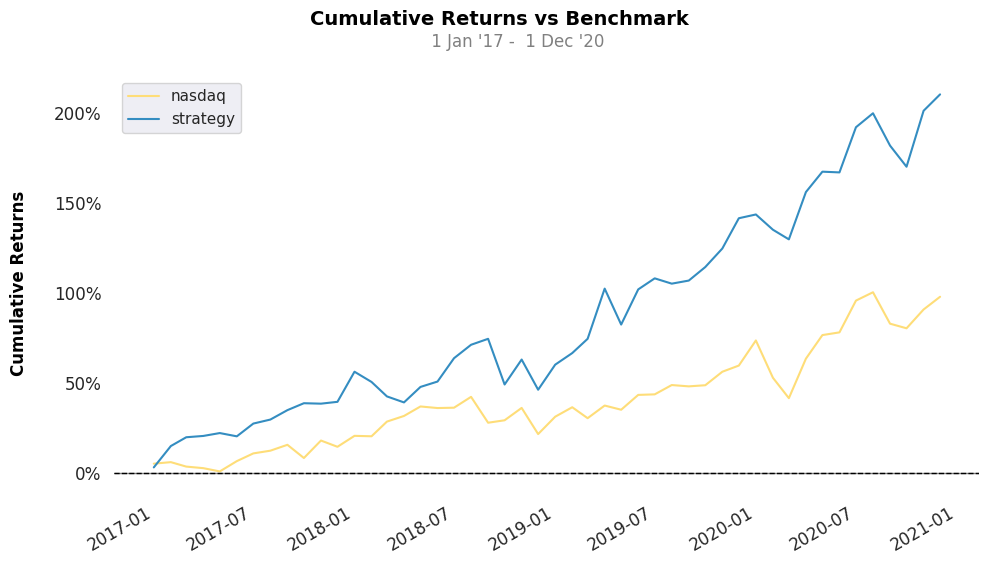

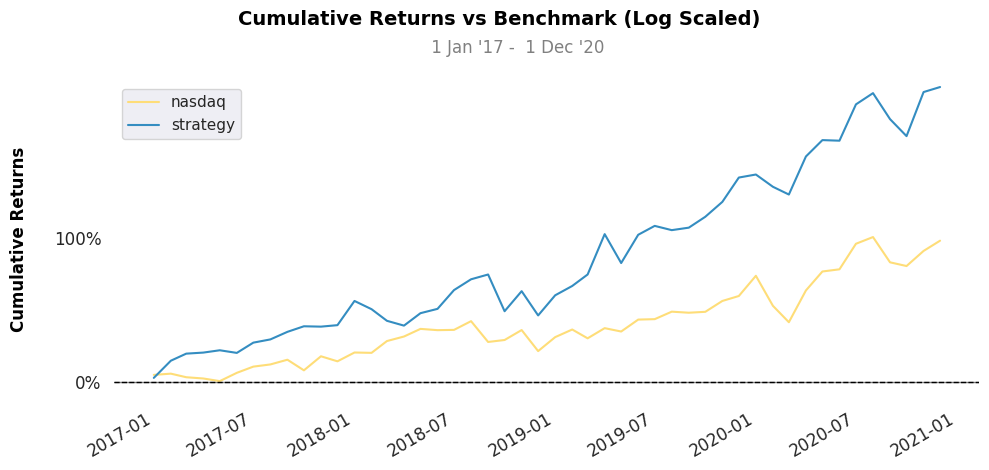

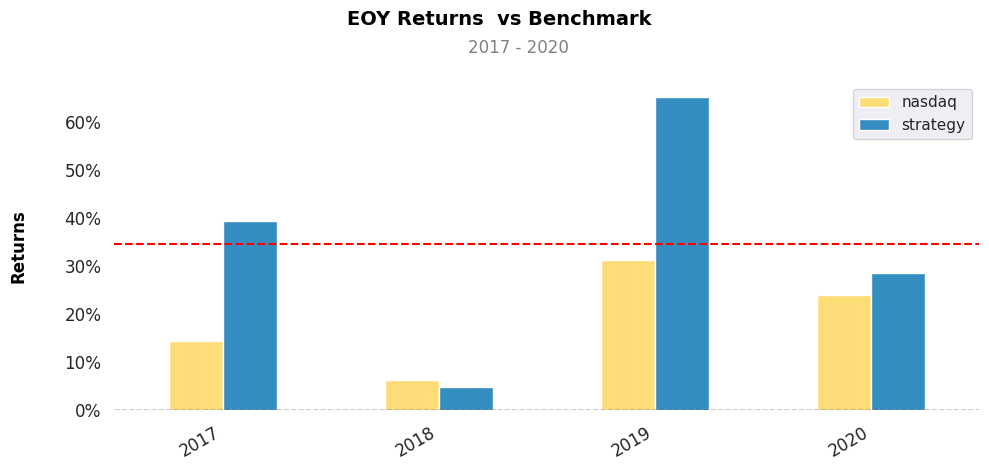

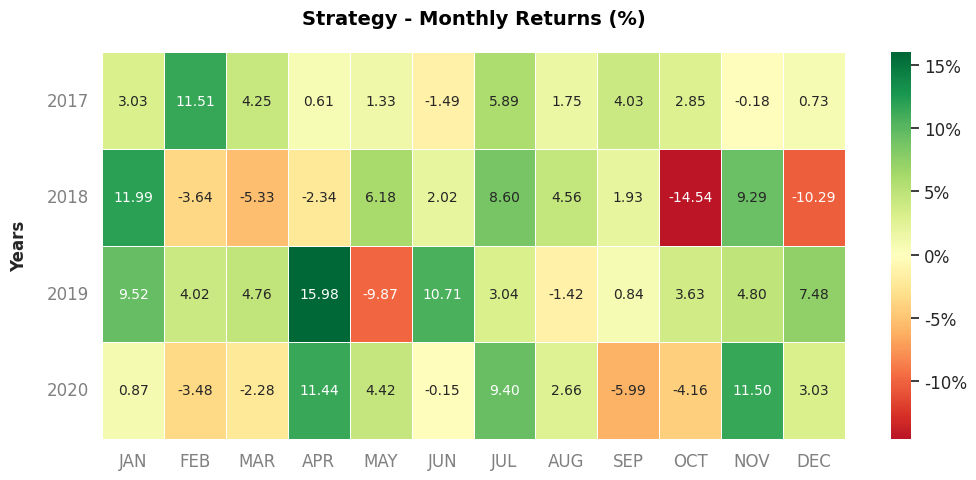

In [281]:
print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['strategy'],frame_final['nasdaq'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.log_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['nasdaq'])

# Replicando estudo sem nenhuma alteração para as 20 principais ações do Ibovespa 

In [29]:
tickers = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

len(tickers)

20

In [30]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table

peRatio  priceToSalesRatio    pbRatio  evToSales  debtToEquity  \
2011   4.849135           1.881208   1.427941   2.236777      0.315332   
2011   7.480568           1.031536   0.855995   1.469256      0.471610   
2011  11.126058           2.072692   2.082083   2.190671      1.965148   
2011   5.349839           1.129452   0.991288   0.643243      1.158981   
2011  18.232143          10.036799   0.993552  10.036799      0.000000   
...         ...                ...        ...        ...           ...   
2020  -7.371343           2.592999  10.921654   4.932327     10.798336   
2020  20.979705           4.988432   3.015127   5.895143      0.804916   
2020  17.417276           0.949303   1.347797   1.263752      0.596063   
2020  13.661434           0.232489   1.565817   0.426163      1.794925   
2020  13.502600           2.596121   1.468469   3.710879      1.496448   

      evToFreeCashFlow  debtToAssets  netDebtToEBITDA  
2011         15.668858      0.190370         0.603528  
2011        -64.457760      0.259626         1.645625  
2011        -14.380404      0.177605         0.116460  
2011         -0.795088      0.094953        -0.397874  
2011         13.007715      0.000000         0.000000  
...                ...           ...              ...  
2020         18.262323      0.767103         4.892366  
2020         14.771019      0.373308         1.369121  
2020         12.029619      0.291410         1.647307  
2020          6.488485      0.439624         2.469496  
2020          2.212232      0.135801         1.572953  

[200 rows x 8 columns]

In [31]:
rank = pd.DataFrame()

for steps in range(len(year)):
    y = Full_table.loc[year[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    bv = bv.T
    bv.index = [year[steps]]
    bv.columns = tickers
    
    rank = rank.append(bv)

In [32]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank

Company   Z-Score
2011  VALE3.SA  1.198901
2011  PETR4.SA  1.282748
2011  ITUB4.SA  0.797951
2011  BBDC4.SA  1.099540
2011  B3SA3.SA  0.751429
...        ...       ...
2020  SUZB3.SA  0.525550
2020  PRIO3.SA  0.767735
2020  GGBR4.SA  1.164545
2020  JBSS3.SA  1.979066
2020  BBDC3.SA  1.181850

[200 rows x 2 columns]

Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [33]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]
condition
sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']
sum_score

# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]
condition2
sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']
sum_score2

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [34]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)

print(rank.loc[year[0:]].head())
Final_yr_wise.loc[year[0:]].head()

       Company   Z-Score
2011  VALE3.SA  1.198901
2011  PETR4.SA  1.282748
2011  ITUB4.SA  0.797951
2011  BBDC4.SA  1.099540
2011  B3SA3.SA  0.751429


F-Score-Max  F-Score-Min  G-Score-Max   Company
2011            4            1            2  VALE3.SA
2011            2            1           -4  PETR4.SA
2011            2            1           -4  ITUB4.SA
2011           -2           -1            2  BBDC4.SA
2011           -4           -3            2  B3SA3.SA

In [35]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]

# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

Company_y  Cumulative-Score
index_x                            
2011     VALE3.SA          3.626999
2012     VALE3.SA          1.590085
2013     VALE3.SA          2.420880
2014     VALE3.SA          2.408019

In [36]:
stock = yf.download(tickers=tickers, start='2011-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

[*********************100%***********************]  20 of 20 completed


Assumindo as posições das 6 maiores Empresas, com peso igual

In [37]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range(len(year)):
    sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [38]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year

list_comp

0         1         2         3         4         5
2011  VALE3.SA  ELET3.SA  JBSS3.SA  EQTL3.SA  PETR4.SA  BBAS3.SA
2012  CSAN3.SA  PRIO3.SA  ABEV3.SA  RENT3.SA  WEGE3.SA  ITSA4.SA
2013  ABEV3.SA  ELET3.SA  GGBR4.SA  LREN3.SA  JBSS3.SA  RENT3.SA
2014  JBSS3.SA  ITSA4.SA  RADL3.SA  ELET3.SA  ITUB4.SA  EQTL3.SA
2015  EQTL3.SA  PRIO3.SA  LREN3.SA  RADL3.SA  CSAN3.SA  JBSS3.SA
2016  PRIO3.SA  CSAN3.SA  SUZB3.SA  PETR4.SA  WEGE3.SA  JBSS3.SA
2017  JBSS3.SA  PETR4.SA  VALE3.SA  ABEV3.SA  SUZB3.SA  EQTL3.SA
2018  VALE3.SA  ABEV3.SA  CSAN3.SA  ITSA4.SA  PRIO3.SA  ELET3.SA
2019  BBAS3.SA  JBSS3.SA  WEGE3.SA  ELET3.SA  EQTL3.SA  B3SA3.SA
2020  JBSS3.SA  BBAS3.SA  WEGE3.SA  GGBR4.SA  RENT3.SA  VALE3.SA

Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [39]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'IBOVESPA' and Comparing the performance with it.

In [40]:
benchmark = yf.download(tickers='^BVSP', start='2011-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [41]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
benchmark_returns = benchmark.pct_change().dropna()

frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.index = frame_final.index.to_timestamp()
frame_final.columns = ['strategy', 'ibovespa']
frame_final

strategy  ibovespa
Date                          
2011-02-01  0.007671  0.012137
2011-03-01  0.008670  0.017868
2011-04-01 -0.026741 -0.035779
2011-05-01 -0.136440 -0.022878
2011-06-01 -0.020166 -0.034293
...              ...       ...
2020-08-01 -0.000842 -0.034427
2020-09-01 -0.030777 -0.047963
2020-10-01  0.035161 -0.006881
2020-11-01  0.136237  0.158975
2020-12-01  0.107781  0.095676

[119 rows x 2 columns]

## Comparing the Returns of the Strategy with the IBOVESPA
Import `teersheet` module to get full performance metric.

Performance Metrics
                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          79.21%       117.09%
CAGR﹪                     4.18%        5.59%

Sharpe                     1.72         2.04
Prob. Sharpe Ratio         87.21%       91.62%
Smart Sharpe               1.36         1.61
Sortino                    2.56         3.16
Smart Sortino              2.03         2.51
Sortino/√2                 1.81         2.23
Smart Sortino/√2           1.44         1.77
Omega                      1.42         1.42

Max Drawdown               -41.09%      -54.83%
Longest DD Days            2284         1158
Volatility (ann.)          104.74%      111.22%
R^2                        0.78         0.78
Information Ratio          0.06         0.

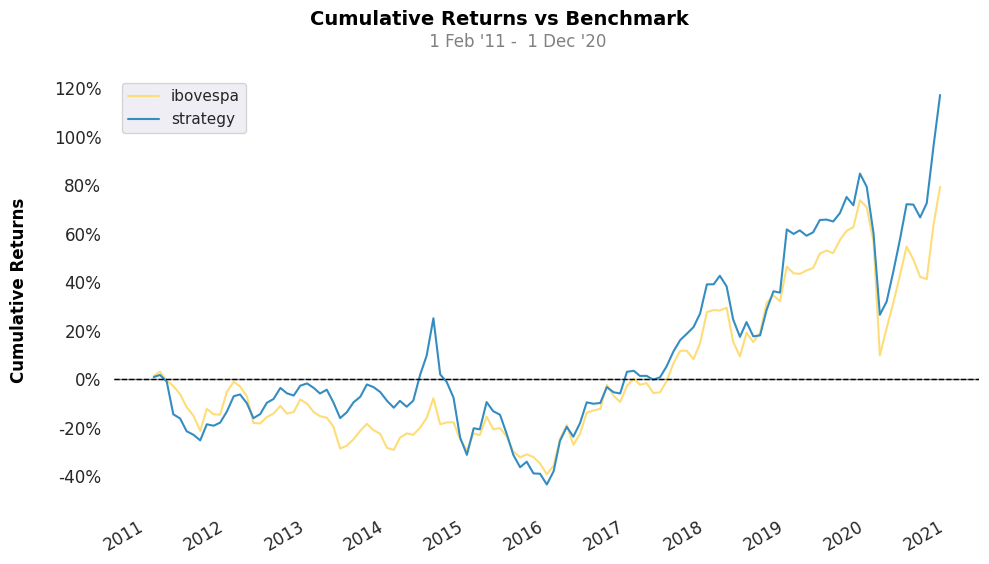

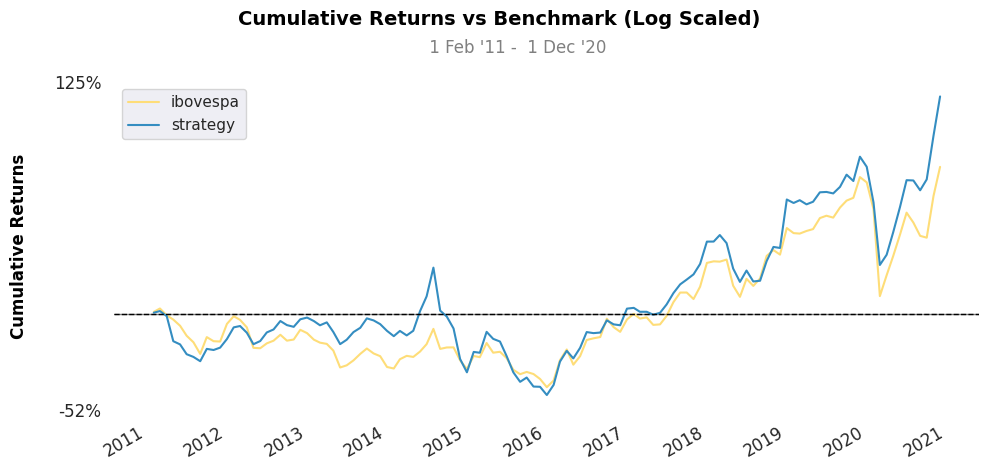

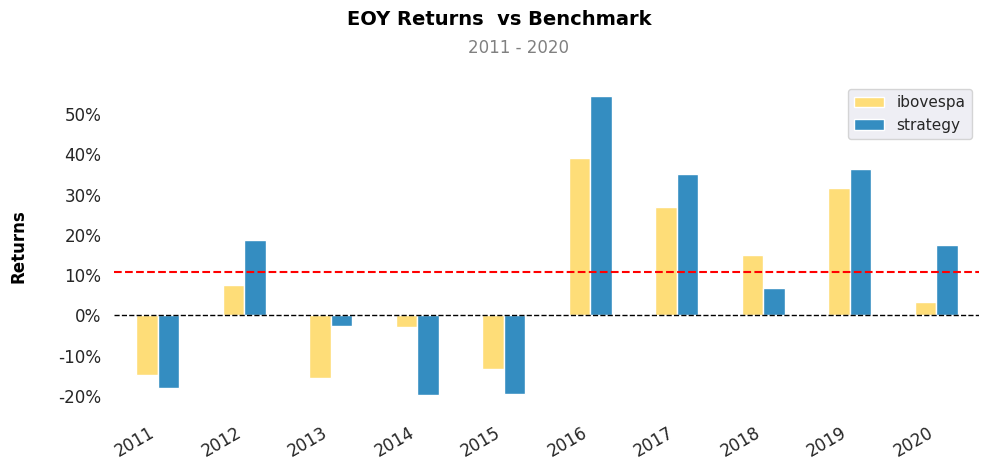

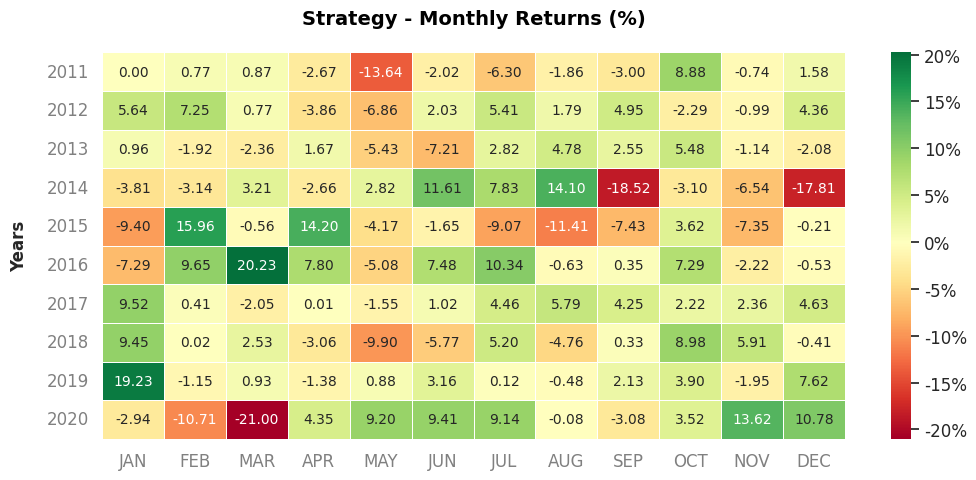

In [42]:
print("\033[1mPerformance Metrics\033[0m")
qs.reports.metrics(frame_final['strategy'],frame_final['ibovespa'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.log_returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['ibovespa'])

## Criando funções para deixarem as análises mais otimizadas

In [43]:
def Analise_Fund(tickers,ratio,year):
    # WRT to cash, income and book value
    
    # Ratios to derive out the value factor
    Full_table = pd.DataFrame()
    
    for steps1 in range(len(year)):
        for steps2 in range(len(tickers)):
            p = str(tickers[steps2])
            data = fa.key_metrics(
                ticker=p, api_key=key, period='annual')
            table = data.T[ratio]
            table = table.loc[year[steps1]]
            Full_table = Full_table.append(table)
    
    rank = pd.DataFrame()

    for steps in range(len(year)):
        y = Full_table.loc[year[steps]]
        t_inv = 1/y
        bv = zscore2(t_inv)
        bv = bv.T
        bv.index = [year[steps]]
        bv.columns = tickers

        rank = rank.append(bv)
    
    name = pd.DataFrame(tickers)
    concated = pd.concat([name]*len(year), axis=0)
    concated.index = Full_table.index
    concated.columns = ['Company']

    lista_z_score = []
    for i in year:
        lista_z_score += list(rank.loc[i])

    lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
    rank = pd.concat([concated, lista_z_score], axis=1)

    return rank

In [44]:
def Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year):

    percent_fscore_max = pd.DataFrame()
    percent_fscore_min = pd.DataFrame()
    percent_gscore_max = pd.DataFrame()
    vc = pd.DataFrame()
    
    for steps in range(len(tickers)):
        # Fscore-Max analysis
        p = str(tickers[steps])
        data3 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose = data3.T[f_score_ratio_max].fillna(0)
        reverse = tranpose.loc[::-1]
        change = reverse.pct_change()
        change = change.assign(Company=p)
        percent_fscore_max = percent_fscore_max.append(change)

        # Fscore-Min analysis
        data4 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose1 = data4.T[f_score_ratio_min].fillna(0)
        reverse1 = tranpose1.loc[::-1]
        change1 = reverse1.pct_change()
        change1 = change1.assign(Company=p)
        percent_fscore_min = percent_fscore_min.append(change1)

        # Gscore-Max analysis
        data5 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose2 = data5.T[g_score_ratio_max].fillna(0)
        reverse2 = tranpose2.loc[::-1]
        change2 = reverse2.pct_change()
        change2 = change2.assign(Company=p)
        percent_gscore_max = percent_gscore_max.append(change2)

    # Condition to quantify the performance
    condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
    condition = pd.DataFrame(condition)
    condition.index = percent_fscore_max.index
    condition.columns = percent_fscore_max.columns[:-1]
    
    sum_score = condition.sum(axis=1)
    sum_score = pd.DataFrame(sum_score)
    sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
    sum_score.columns = ['F-Score-Max','Company']

    # Condition to quantify the performance
    condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
    condition2 = pd.DataFrame(condition2)
    condition2.index = percent_fscore_min.index
    condition2.columns = percent_fscore_min.columns[:-1]

    sum_score2 = condition2.sum(axis=1)
    sum_score2 = pd.DataFrame(sum_score2)
    sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
    sum_score2.columns = ['F-Score-Min','Company']

    # Condition to quantify the performance
    condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
    condition3 = pd.DataFrame(condition3)
    condition3.index = percent_gscore_max.index
    condition3.columns = percent_gscore_max.columns[:-1]
    sum_score3 = condition3.sum(axis=1)
    sum_score3 = pd.DataFrame(sum_score3)
    sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
    sum_score3.columns = ['G-Score-Max','Company']
    
    Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
    Final_yr_wise = Final_yr_wise.loc[year]
    company = pd.DataFrame(Final_yr_wise['Company'])
    
    vc['Company'] = company
    vc['Cumulative-F&G-Score'] = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]])

    return vc

In [45]:
def Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,qtd = 6):
    # Now Joing the two Dataframes and getting a cumulative score of each company for each year
    df = pd.DataFrame()
    
    rank = Analise_Fund(tickers,ratio,year)
    vc = Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year)
    
    vc_new = vc.reset_index()
    vc_new['key'] = vc_new['index'] + str('_') + vc_new['Company']
    
    rank_new = rank.reset_index()
    rank_new['key'] = rank_new['index'] + str('_') + rank_new['Company']
    df = vc_new.merge(rank_new, on='key')
    df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
    df.index = df['index_x']
    
    dataframe = df.drop(labels='index_x', axis=1)
    dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
        dataframe['Z-Score'].values
    dataframe_final = dataframe.drop(
        labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
    
    # Ações a serem investidas pela estratégia
    acoes = pd.DataFrame()

    for steps in range(len(year)):
        sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
            by='Cumulative-Score', ascending=False)
        selection = sorted_table[['Company_y']].head(qtd)
        array = np.array(selection['Company_y'])
        frame = pd.DataFrame(array)
        acoes = acoes.append(frame)
    
    comp_index = np.repeat(year, qtd)
    acoes.index = comp_index
    acoes.columns = ['Companies-Invested']

    list_comp = pd.DataFrame()
    for steps in range(len(year)):
        f = acoes.loc[year[steps]]['Companies-Invested'].T
        mk = np.array(f)
        l = pd.DataFrame(mk).T
        list_comp = list_comp.append(l)

    list_comp.index = year

    return list_comp

In [46]:
def comparar_estrategia(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,ticker_benchmark,name_benchmark,qtd = 6):
    # retorno da estratégia
    estrategia = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year)
    
    df = pd.DataFrame()
    inicio = year[0] + '-01-01'
    final = year[-1] + '-12-31'
    
    stock = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Close']]

    stock.index = pd.to_datetime(stock.index)
    stock = (stock.T.drop_duplicates().T).dropna()
    stock.columns = tickers
    returns = stock.pct_change().dropna()
    
    for steps in range(len(year)):
        array = estrategia.loc[year[steps]]
        returns_selection = returns.loc[year[steps]]
        selected_returns = returns_selection[array]

        # Portfólio com pesos iguais
        weight = np.repeat(1/qtd, qtd)
        series = (selected_returns*weight).sum(axis=1)
        frame = pd.DataFrame(series)
        df = df.append(frame)
        
    df.columns = ['Returns']
    df.index = pd.to_datetime(df.index).to_period('M')
    
    # retorno do benchmark
    benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                        end=final, interval='1mo')[['Close']]
    benchmark = (benchmark.T.drop_duplicates().T).dropna()
    benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
    benchmark_returns = benchmark.pct_change().dropna()
    
    # comparando a estratégia com o benchmark
    frame_final = pd.concat([df, benchmark_returns], axis=1)
    frame_final.columns = ['Strategy', name_benchmark]
    frame_final.index = frame_final.index.to_timestamp()
    
    print("\033[1mPerformance Metrics\033[0m\n")
    qs.reports.metrics(frame_final['Strategy'],frame_final[name_benchmark],mode='full')

    print("\n\033[1mStrategy Visualization\033[0m\n")
    qs.plots.returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.log_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.yearly_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final[name_benchmark])
    

### Resultados usando as funções criadas

In [47]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

tickers_us = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year_us = ['2017','2018', '2019', '2020']

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_us ='NDAQ'
benchmark_br = '^BVSP'

In [48]:
Analise_Fund(tickers_br,ratio,year_br)

Company   Z-Score
2011  VALE3.SA  1.198901
2011  PETR4.SA  1.282748
2011  ITUB4.SA  0.797951
2011  BBDC4.SA  1.099540
2011  B3SA3.SA  0.751429
...        ...       ...
2020  SUZB3.SA  0.525550
2020  PRIO3.SA  0.767735
2020  GGBR4.SA  1.164545
2020  JBSS3.SA  1.979066
2020  BBDC3.SA  1.181850

[200 rows x 2 columns]

In [49]:
Analise_Quant(tickers_br,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br)

Company  Cumulative-F&G-Score
2011  VALE3.SA              2.416568
2011  PETR4.SA              1.504247
2011  ITUB4.SA              1.504247
2011  BBDC4.SA              1.066374
2011  B3SA3.SA              0.604897
...        ...                   ...
2020  SUZB3.SA              1.299020
2020  PRIO3.SA              0.604897
2020  GGBR4.SA              1.176471
2020  JBSS3.SA              0.878077
2020  BBDC3.SA              0.607184

[200 rows x 2 columns]

In [50]:
Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,qtd = 8)

0         1         2         3         4         5         6  \
2011  VALE3.SA  ELET3.SA  JBSS3.SA  EQTL3.SA  PETR4.SA  BBAS3.SA  CSAN3.SA   
2012  CSAN3.SA  PRIO3.SA  ABEV3.SA  RENT3.SA  WEGE3.SA  ITSA4.SA  RADL3.SA   
2013  ABEV3.SA  ELET3.SA  GGBR4.SA  LREN3.SA  JBSS3.SA  RENT3.SA  VALE3.SA   
2014  JBSS3.SA  ITSA4.SA  RADL3.SA  ELET3.SA  ITUB4.SA  VALE3.SA  EQTL3.SA   
2015  EQTL3.SA  PRIO3.SA  LREN3.SA  RADL3.SA  CSAN3.SA  JBSS3.SA  PETR4.SA   
2016  PRIO3.SA  CSAN3.SA  SUZB3.SA  PETR4.SA  WEGE3.SA  JBSS3.SA  RADL3.SA   
2017  JBSS3.SA  PETR4.SA  VALE3.SA  ABEV3.SA  SUZB3.SA  EQTL3.SA  RADL3.SA   
2018  VALE3.SA  ABEV3.SA  CSAN3.SA  ITSA4.SA  PRIO3.SA  JBSS3.SA  ELET3.SA   
2019  BBAS3.SA  JBSS3.SA  WEGE3.SA  ELET3.SA  EQTL3.SA  B3SA3.SA  ITSA4.SA   
2020  JBSS3.SA  BBAS3.SA  WEGE3.SA  GGBR4.SA  RENT3.SA  VALE3.SA  ITSA4.SA   

             7  
2011  BBDC3.SA  
2012  JBSS3.SA  
2013  WEGE3.SA  
2014  BBDC3.SA  
2015  GGBR4.SA  
2016  ITSA4.SA  
2017  ITSA4.SA  
2018  ITUB4.SA  
2019  CSAN3.SA  
2020  ITUB4.SA

### Comparando com o Nasdaq usando as funções

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  1 of 1 completed
Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-02-01   2017-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          88.18%       201.02%
CAGR﹪                     12.06%       21.96%

Sharpe                     4.24         6.5
Prob. Sharpe Ratio         95.81%       99.55%
Smart Sharpe               3.2          4.9
Sortino                    6.87         12.04
Smart Sortino              5.18         9.08
Sortino/√2                 4.86         8.52
Smart Sortino/√2           3.66         6.42
Omega                      2.85         2.85

Max Drawdown               -18.47%      -16.21%
Longest DD Days            243         

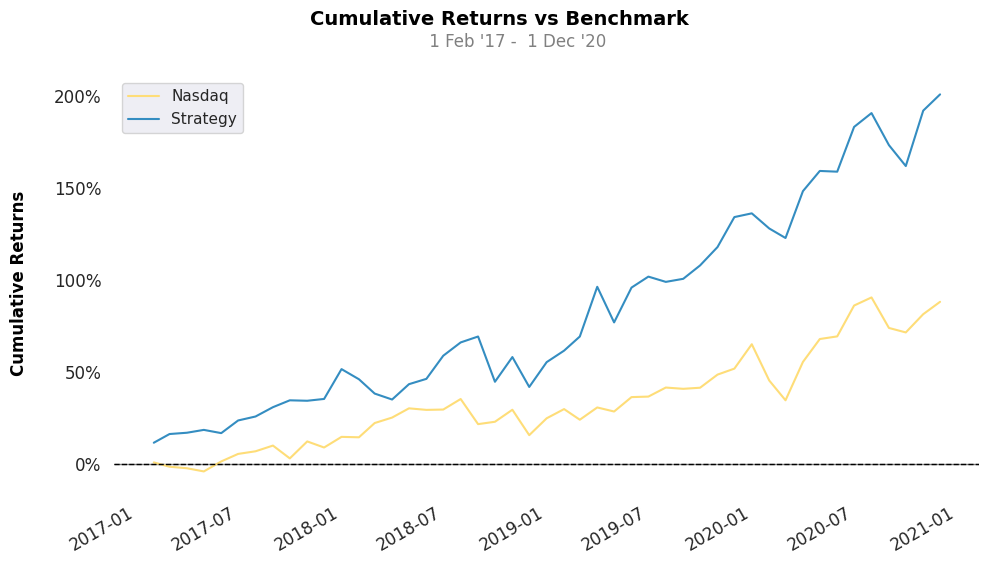

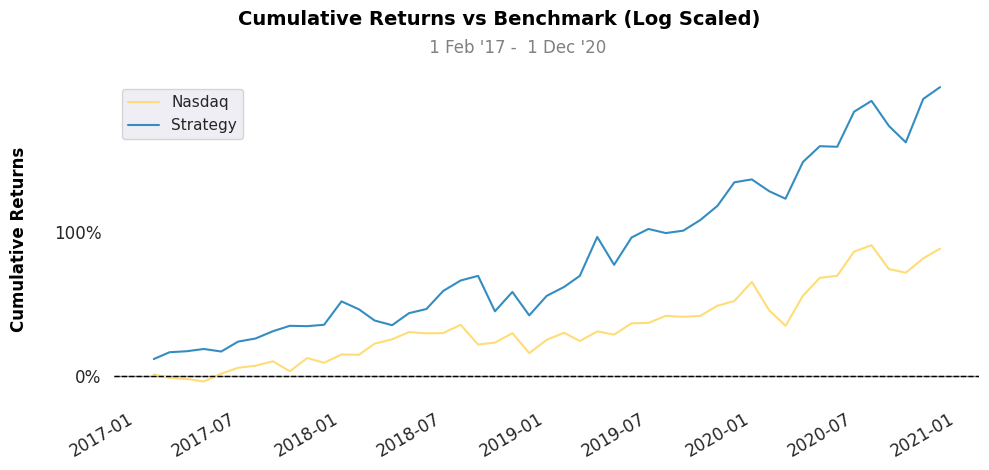

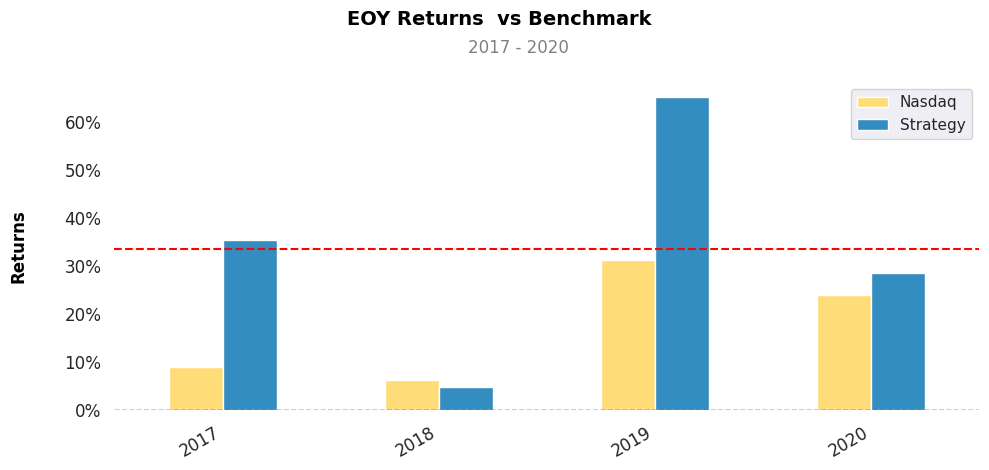

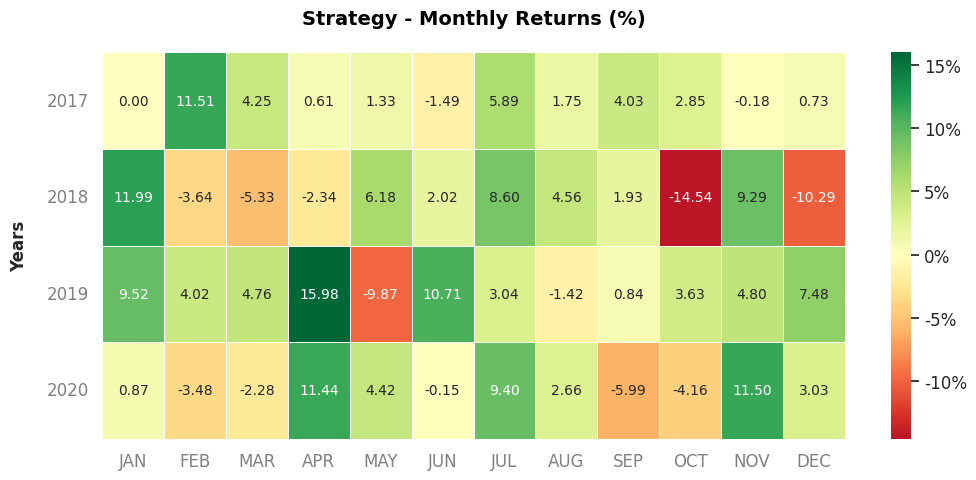

In [51]:
tickers_us = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year_us = ['2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_us ='NDAQ'
name_benchmark_us = 'Nasdaq'

comparar_estrategia(tickers_us,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_us,benchmark_us,name_benchmark_us,qtd = 6)

### Comparando com o Ibovespa usando as funções

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed
Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          79.21%       154.77%
CAGR﹪                     4.18%        6.78%

Sharpe                     1.72         2.4
Prob. Sharpe Ratio         87.21%       94.86%
Smart Sharpe               1.39         1.94
Sortino                    2.56         3.81
Smart Sortino              2.07         3.09
Sortino/√2                 1.81         2.7
Smart Sortino/√2           1.47         2.18
Omega                      1.51         1.51

Max Drawdown               -41.09%      -47.95%
Longest DD Days            2284         1

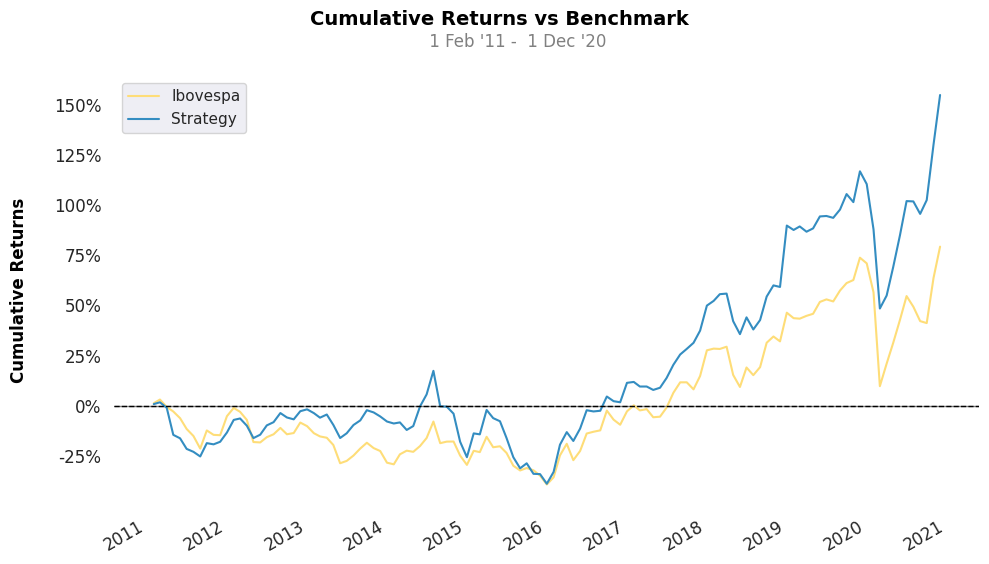

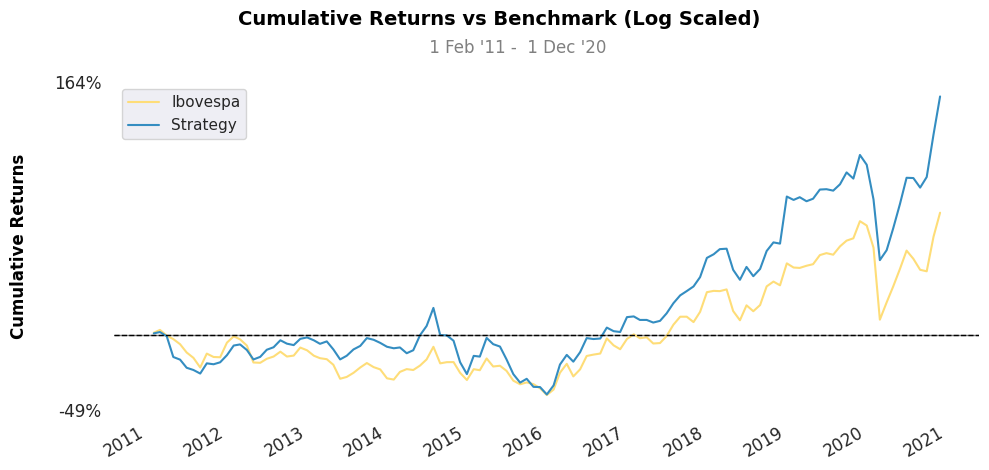

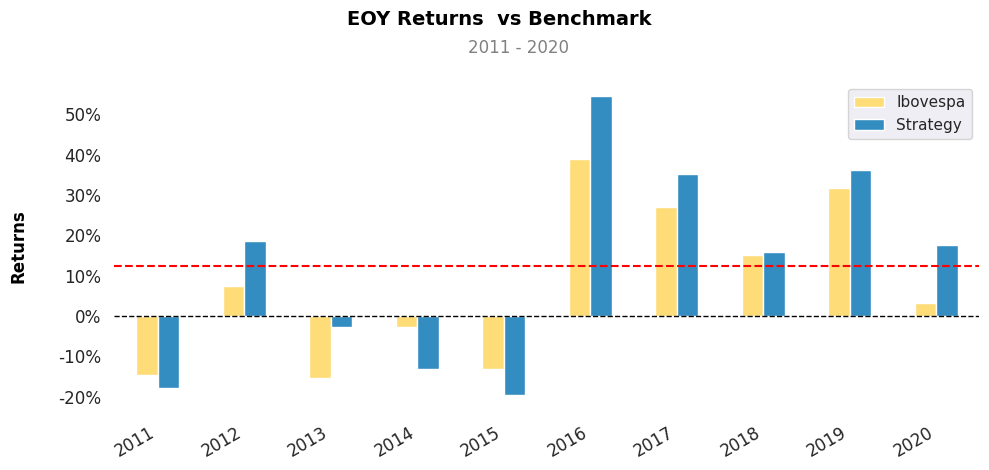

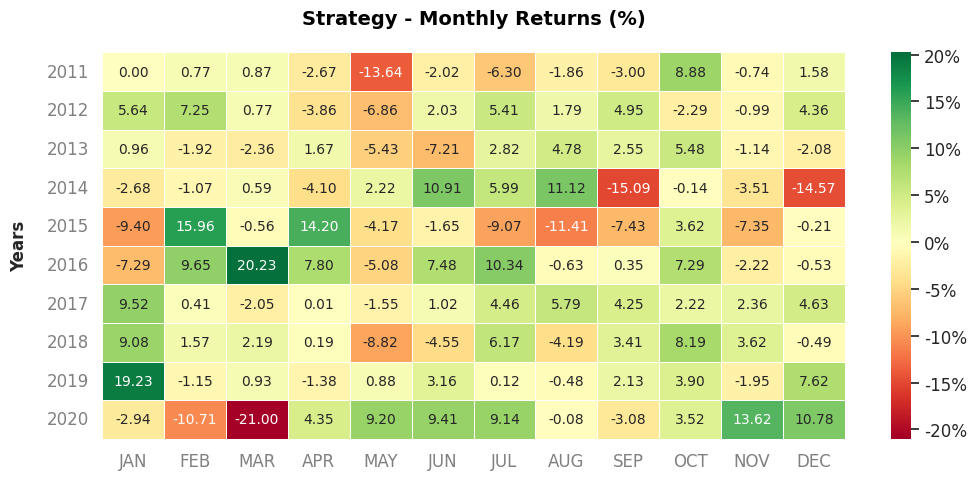

In [52]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_br = '^BVSP'
name_benchmark_br = 'Ibovespa'

comparar_estrategia(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,benchmark_br,name_benchmark_br,qtd = 6)

### Comparando com o CDI usando as funções

In [53]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

tabela = Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,qtd = 6)

In [54]:
stock = yf.download(tickers=tickers_br, start='2011-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

df = pd.DataFrame()

for steps in range(len(year_br)):
    array = tabela.loc[year_br[steps]]
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year_br[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)

df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')
df

[*********************100%***********************]  20 of 20 completed


Returns
Date             
2011-02  0.007671
2011-03  0.008670
2011-04 -0.026741
2011-05 -0.136440
2011-06 -0.020166
...           ...
2020-08 -0.000842
2020-09 -0.030777
2020-10  0.035161
2020-11  0.136237
2020-12  0.107781

[119 rows x 1 columns]

In [55]:
import requests
import pandas as pd

# Definir a URL da API do Banco Central para o CDI
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json'

# Fazer uma requisição GET para obter os dados do CDI
response = requests.get(url)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    # Converter os dados da resposta para um DataFrame
    cdi_data = pd.DataFrame(response.json())

    # Converter a coluna de datas para o formato datetime
    cdi_data['data'] = pd.to_datetime(cdi_data['data'], dayfirst=True)

    # Definir a coluna de datas como o índice do DataFrame
    cdi_data = cdi_data.set_index('data')

    # Converter a coluna de valores para o tipo numérico
    cdi_data['valor'] = pd.to_numeric(cdi_data['valor'])/100
    cdi_data['valor'] = (cdi_data['valor'] + 1)**(1/360) - 1

    # Calcular os retornos mensais do CDI
    retorno_acumulado = (1 + cdi_data).cumprod() - 1
    retorno_mensal = retorno_acumulado.resample('M').last().pct_change()
    retorno_mensal = retorno_mensal.loc[year_br[0]:year_br[-1]]
    
    # Formatar o índice para exibir apenas o ano e o mês
    retorno_mensal.index = pd.PeriodIndex(retorno_mensal.index, freq='M')
    
    # Exibir os retornos mensais do CDI
    print(retorno_mensal)
else:
    print('Falha na requisição. Código de status:', response.status_code)


            valor
data             
2011-01  0.006028
2011-02  0.005900
2011-03  0.006434
2011-04  0.005874
2011-05  0.006906
...           ...
2020-08  0.001119
2020-09  0.001099
2020-10  0.001099
2020-11  0.001046
2020-12  0.001151

[120 rows x 1 columns]


Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          81.93%       152.83%
CAGR﹪                     4.29%        6.73%

Sharpe                     40.71        2.38
Prob. Sharpe Ratio         -            94.75%
Smart Sharpe               32.96        1.93
Sortino                    -            3.79
Smart Sortino              -            3.07
Sortino/√2                 -            2.68
Smart Sortino/√2           -            2.17
Omega                      1.51         1.51

Max Drawdown               -            -47.95%
Longest DD Days            -            -
Volatility (ann.)          3.12%        106.45%
R^2                        0.01         0.01
Information Ratio          0.07         0.07

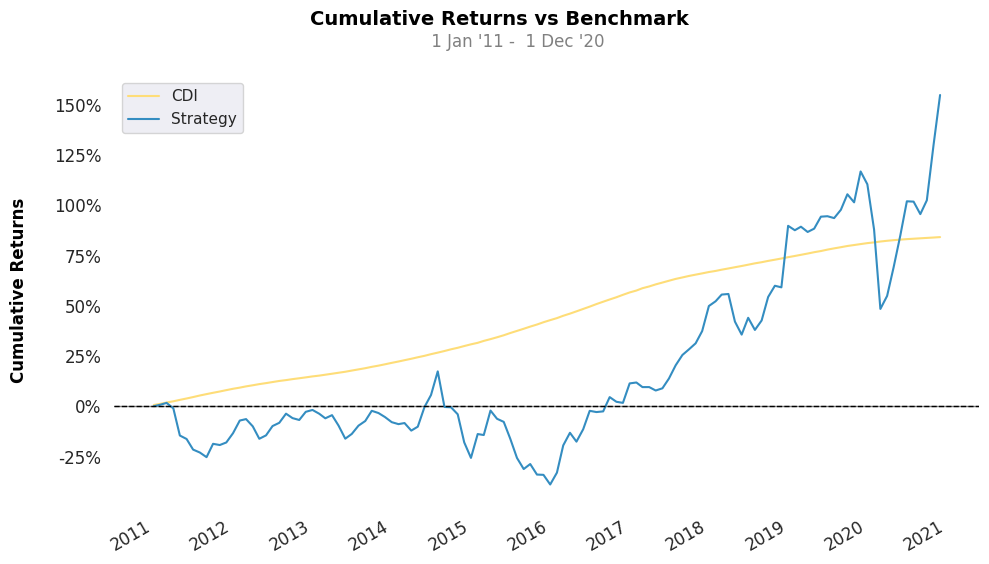

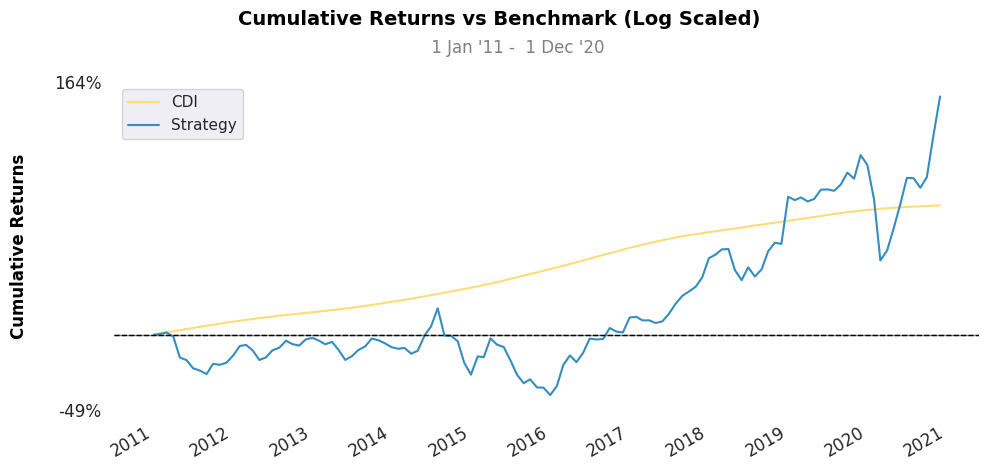

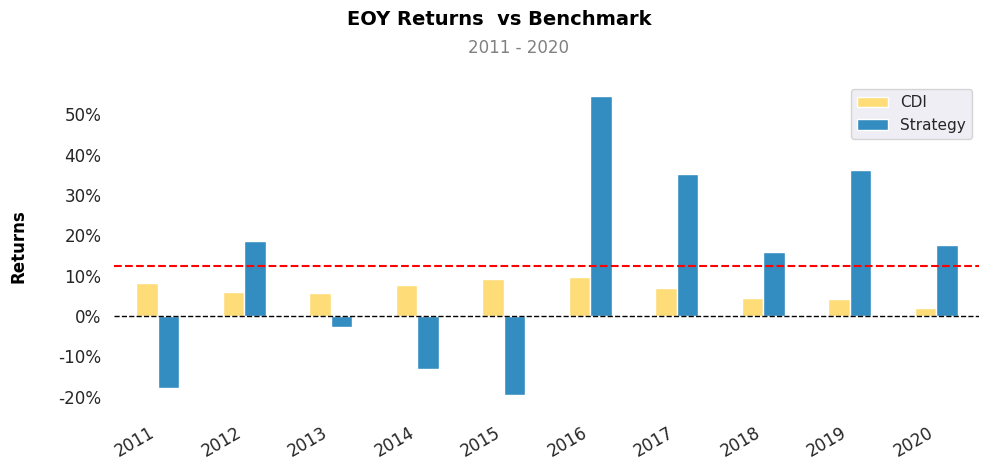

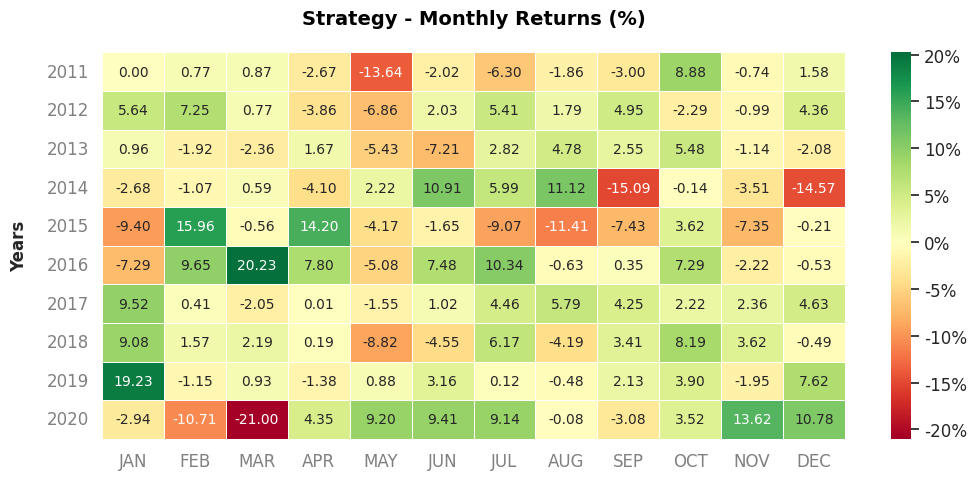

In [56]:
frame_final = pd.concat([df, retorno_mensal], axis=1)
frame_final.columns = ['Strategy', 'CDI']
frame_final.index = frame_final.index.to_timestamp()

print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['Strategy'],frame_final['CDI'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.log_returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.yearly_returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final['CDI'])

### Testando ajustes trimestrais

In [35]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

In [15]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2017','2018', '2019', '2020']
year_usado = ['2016','2017','2018', '2019', '2020']

for steps1 in range(len(year_usado)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='quarter')
        table = data.T[ratio]
        table.index = pd.to_datetime(table.index)
        table = table.loc[table.index.year == int(year_usado[steps1])]
        table['Company'] = tickers[steps2]
        Full_table = Full_table.append(table)

Full_table = Full_table.sort_index()
Full_table

peRatio priceToSalesRatio    pbRatio  evToSales debtToEquity  \
2016-01-01   9.412607          9.934258   1.946508  11.467335     0.404117   
2016-01-01  17.680857          8.961852   2.821833    9.13066     0.466378   
2016-03-01 -27.000114         26.576887  31.415977  28.076781     3.258815   
2016-03-01  39.330113         12.347441  13.182012  14.620413     3.157772   
2016-03-01   8.906504         16.300023    9.48219  18.417934     1.703389   
...               ...               ...        ...        ...          ...   
2020-12-01  15.529344         34.103283  18.953409  33.775293     0.090971   
2020-12-01   18.45516          5.379524   2.883197   6.775045     1.088614   
2020-12-01   19.43157         20.801049    5.31822  20.806444       0.1203   
2020-12-01  27.167805         39.009729  12.902601  40.285753     0.532863   
2020-12-01  24.264788          13.50052   1.953003  13.703707     0.179367   

           evToFreeCashFlow debtToAssets netDebtToEBITDA Company  
2016-01-01        37.907677     0.218382        4.610439    CSCO  
2016-01-01       148.258273     0.250863         0.84292    AMAT  
2016-03-01       -69.041588     0.344032      -21.152393    TSLA  
2016-03-01      -672.198992     0.501093       12.839048     PEP  
2016-03-01        38.423282     0.477798        3.291525    GILD  
...                     ...          ...             ...     ...  
2020-12-01       228.264688      0.05925       -1.621951     AMD  
2020-12-01       130.454758     0.400237       10.074021    PCAR  
2020-12-01        68.836205     0.083763        0.015913    GOOG  
2020-12-01       208.025545      0.22818        2.536619    MSFT  
2020-12-01      -102.608949     0.133318           0.491      MU  

[280 rows x 9 columns]

In [16]:
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

meses_referencia = [1, 4, 7, 10]
def calcular_indice_mensal(data):
    mes_referencia = meses_referencia[data.month // 3] if data.month <= meses_referencia[-1] else 1
    ano = data.year if data.month <= meses_referencia[-1] else data.year + 1
    return pd.to_datetime(f"{ano}-{mes_referencia:02d}-01")

Full_table.index = pd.to_datetime(Full_table.index)

Full_table['index'] = Full_table.index.map(calcular_indice_mensal)

Full_table

peRatio priceToSalesRatio    pbRatio  evToSales debtToEquity  \
2016-01-01   9.412607          9.934258   1.946508  11.467335     0.404117   
2016-01-01  17.680857          8.961852   2.821833    9.13066     0.466378   
2016-03-01 -27.000114         26.576887  31.415977  28.076781     3.258815   
2016-03-01  39.330113         12.347441  13.182012  14.620413     3.157772   
2016-03-01   8.906504         16.300023    9.48219  18.417934     1.703389   
...               ...               ...        ...        ...          ...   
2020-12-01  15.529344         34.103283  18.953409  33.775293     0.090971   
2020-12-01   18.45516          5.379524   2.883197   6.775045     1.088614   
2020-12-01   19.43157         20.801049    5.31822  20.806444       0.1203   
2020-12-01  27.167805         39.009729  12.902601  40.285753     0.532863   
2020-12-01  24.264788          13.50052   1.953003  13.703707     0.179367   

           evToFreeCashFlow debtToAssets netDebtToEBITDA Company      index  
2016-01-01        37.907677     0.218382        4.610439    CSCO 2016-01-01  
2016-01-01       148.258273     0.250863         0.84292    AMAT 2016-01-01  
2016-03-01       -69.041588     0.344032      -21.152393    TSLA 2016-04-01  
2016-03-01      -672.198992     0.501093       12.839048     PEP 2016-04-01  
2016-03-01        38.423282     0.477798        3.291525    GILD 2016-04-01  
...                     ...          ...             ...     ...        ...  
2020-12-01       228.264688      0.05925       -1.621951     AMD 2021-01-01  
2020-12-01       130.454758     0.400237       10.074021    PCAR 2021-01-01  
2020-12-01        68.836205     0.083763        0.015913    GOOG 2021-01-01  
2020-12-01       208.025545      0.22818        2.536619    MSFT 2021-01-01  
2020-12-01      -102.608949     0.133318           0.491      MU 2021-01-01  

[280 rows x 10 columns]

In [215]:
y = Full_table
y.index = pd.to_datetime(Full_table['index'])
y = y.drop(['Company','index'],axis=1)
t_inv = 1/y
rank = zscore2(t_inv)
rank.insert(0,'Company',Full_table['Company'])
#rank.index = rank.index.strftime('%Y-%m')
rank = rank.sort_index()
rank = rank.loc[year[0]:year[-1]]
rank

Company   Z-Score
index                       
2017-01-01     PEP  0.986752
2017-01-01    PCAR  1.359299
2017-01-01    GILD  1.185942
2017-01-01    INTC  1.333281
2017-01-01     TXN  0.891570
...            ...       ...
2020-10-01    GOOG  1.034012
2020-10-01     TXN  0.680950
2020-10-01    TSLA  0.619452
2020-10-01    CSCO  1.109078
2020-10-01    AMAT  1.214024

[224 rows x 2 columns]

In [14]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]

sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']


# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]

sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [17]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
Final_yr_wise = Final_yr_wise.loc[Final_yr_wise.index.str[:4].isin(year_usado)]

Final_yr_wise.index = pd.to_datetime(Final_yr_wise.index)

Final_yr_wise['index'] = Final_yr_wise.index.map(calcular_indice_mensal)

Final_yr_wise.index = pd.to_datetime(Final_yr_wise['index'])
Final_yr_wise = Final_yr_wise.drop('index',axis=1)
Final_yr_wise = Final_yr_wise.sort_index()
Final_yr_wise = Final_yr_wise.loc[year[0]:year[-1]]

Final_yr_wise

F-Score-Max  F-Score-Min  G-Score-Max Company
index                                                    
2017-01-01           -2           -3            0    TSLA
2017-01-01           -2           -1           -4    QCOM
2017-01-01            0            1           -4    MSFT
2017-01-01            0            1           -2    GILD
2017-01-01            0            3           -4    PCAR
...                 ...          ...          ...     ...
2020-10-01           -2           -1           -6    INTC
2020-10-01           -2            1           -4    GILD
2020-10-01           -2           -3            2    ATVI
2020-10-01            0            1            6     PEP
2020-10-01           -2            1            0     TXN

[224 rows x 4 columns]

In [201]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company
#vc.index = vc.index.strftime('%Y-%m')

vc.head()

Cumulative-F&G-Score Company
index                                   
2017-01-01              0.535162    TSLA
2017-01-01              0.534403    QCOM
2017-01-01              0.874334    MSFT
2017-01-01              1.059027    GILD
2017-01-01              1.259129    PCAR

In [216]:
# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index'].astype(str) + str('_') + vc_new['Company']

rank_new = rank.reset_index()
rank_new['key'] = rank_new['index'].astype(str) + str('_') + rank_new['Company']

vc_new = vc_new.drop_duplicates(subset='key')
#rank_new = rank_new.drop_duplicates(subset='key')

df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)

dataframe_final

Company_y  Cumulative-Score
index_x                               
2017-01-01      TSLA          1.103760
2017-01-01      QCOM          1.449618
2017-01-01      MSFT          1.612911
2017-01-01      GILD          2.244969
2017-01-01      PCAR          2.618428
...              ...               ...
2020-10-01      INTC          1.676391
2020-10-01      GILD          1.606890
2020-10-01      ATVI          1.357129
2020-10-01       PEP          2.755131
2020-10-01       TXN          1.621789

[224 rows x 2 columns]

In [217]:
stock = yf.download(tickers=tickers, start='2016-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [218]:
stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()
#returns.index = returns.index.strftime('%Y-%m')
returns = returns.loc[year[0]:year[-1]]
returns.head()

GILD        MU      AMAT      MSFT       AMD      CSCO  \
Date                                                                     
2017-01-01  0.061357 -0.085538  0.113542  0.016545  0.011730  0.032352   
2017-02-01  0.057518  0.394407  0.122358  0.112630 -0.027191  0.033158   
2017-03-01  0.073992  0.006224  0.104808 -0.011118 -0.036322  0.007714   
2017-04-01  0.043959 -0.085911  0.047934  0.007988  0.009276  0.092097   
2017-05-01  0.129771 -0.158647  0.121148 -0.074552 -0.053392  0.065014   

                QCOM      GOOG      TSLA       TXN      INTC      ATVI  \
Date                                                                     
2017-01-01  0.015164  0.040393  0.099909  0.053365 -0.008124 -0.180521   
2017-02-01 -0.016839 -0.010364 -0.027789 -0.007428  0.063596  0.057084   
2017-03-01 -0.003591  0.029384  0.232935  0.005837  0.013408  0.015227   
2017-04-01  0.002218  0.039478 -0.042561 -0.006994  0.012694 -0.062783   
2017-05-01 -0.001107  0.020158  0.112035 -0.056496  0.031691  0.065687   

                 PEP      PCAR  
Date                            
2017-01-01  0.178951  0.035220  
2017-02-01 -0.007701  0.014297  
2017-03-01  0.113245  0.051423  
2017-04-01  0.128530 -0.017130  
2017-05-01  0.085777  0.041803

In [242]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range (0,len(sorted(list(set(dataframe_final.index))))):
    step = sorted(list(set(dataframe_final.index)))[steps]
    
    sorted_table = (dataframe_final.loc[step]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    
    if step != sorted(list(set(dataframe_final.index)))[-1]:
        step1 = sorted(list(set(dataframe_final.index)))[steps + 1]
        returns_selection = returns.loc[step:step1]
        returns_selection = returns_selection.drop(step1)
    else:
        returns_selection = returns.loc[step:]
    
    selected_returns = returns_selection[array]
    
    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)

    df = df.append(frame)
    df2 = df2.append(frame1)

In [243]:
indice = sorted(list(set(dataframe_final.index)))
comp_index = np.repeat(indice, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

list_comp = pd.DataFrame()
for steps in range(len(indice)):
    f = df2.loc[indice[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = indice
list_comp

0     1     2     3     4     5
2017-01-01  INTC  GOOG  CSCO  ATVI  AMAT  PCAR
2017-04-01  GOOG    MU  ATVI  MSFT  TSLA  PCAR
2017-07-01    MU  AMAT    MU  GILD  GOOG   PEP
2017-10-01  PCAR  GOOG   PEP  INTC   TXN  GILD
2018-01-01    MU  PCAR   AMD  GOOG   PEP  INTC
2018-04-01    MU    MU   AMD  GOOG  PCAR  ATVI
2018-07-01    MU  GILD  PCAR  QCOM  GOOG  INTC
2018-10-01  GOOG  GILD  INTC   PEP  AMAT  PCAR
2019-01-01  PCAR  ATVI    MU   PEP  GOOG  INTC
2019-04-01    MU  PCAR  GILD  MSFT  CSCO  GOOG
2019-07-01  QCOM  GOOG  GILD  PCAR  INTC    MU
2019-10-01   TXN   AMD  INTC  CSCO  PCAR   PEP
2020-01-01  INTC  PCAR  ATVI  CSCO   AMD  AMAT
2020-04-01    MU  GOOG  PCAR  ATVI  MSFT  CSCO
2020-07-01  ATVI  GOOG  AMAT  INTC   TXN  TSLA
2020-10-01  AMAT  PCAR   PEP    MU  TSLA  QCOM

In [244]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

In [245]:
benchmark = yf.download(tickers='NDAQ', start='2016-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [246]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns = benchmark_returns.loc[year[0]:year[-1]]

In [247]:
frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'nasdaq']
frame_final.index = frame_final.index.to_timestamp()
frame_final

strategy    nasdaq
Date                          
2017-01-01  0.005477  0.050953
2017-02-01  0.046688  0.008081
2017-03-01  0.036994 -0.023344
2017-04-01 -0.026820 -0.008351
2017-05-01  0.001081 -0.017715
2017-06-01 -0.006302  0.056763
2017-07-01  0.046010  0.040285
2017-08-01  0.019759  0.013581
2017-09-01  0.009112  0.029053
2017-10-01  0.038561 -0.063427
2017-11-01 -0.012936  0.089608
2017-12-01  0.017740 -0.029434
2018-01-01  0.134708  0.053104
2018-02-01 -0.053973 -0.001977
2018-03-01 -0.084981  0.067740
2018-04-01  0.007471  0.024356
2018-05-01  0.126103  0.040082
2018-06-01  0.030501 -0.006423
2018-07-01  0.064169  0.001424
2018-08-01  0.051213  0.044201
2018-09-01  0.012160 -0.101006
2018-10-01 -0.040156  0.010606
2018-11-01  0.015683  0.053166
2018-12-01 -0.078366 -0.106767
2019-01-01  0.038063  0.079318
2019-02-01  0.038963  0.040095
2019-03-01  0.023815 -0.044556
2019-04-01  0.076887  0.053835
2019-05-01 -0.073204 -0.016920
2019-06-01  0.080560  0.061011
2019-07-01  0.039862  0.002080
2019-08-01  0.002460  0.036007
2019-09-01  0.017232 -0.004908
2019-10-01  0.057706  0.004227
2019-11-01  0.036259  0.050416
2019-12-01  0.050726  0.021947
2020-01-01 -0.004001  0.087395
2020-02-01 -0.030193 -0.119440
2020-03-01 -0.063598 -0.074110
2020-04-01  0.141766  0.155029
2020-05-01  0.048071  0.080150
2020-06-01  0.041680  0.008526
2020-07-01  0.067180  0.099104
2020-08-01  0.029012  0.023684
2020-09-01 -0.015863 -0.087115
2020-10-01 -0.050327 -0.014017
2020-11-01  0.203874  0.057856
2020-12-01  0.103753  0.037112

Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-01-01   2017-01-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.77%       209.95%
CAGR﹪                     12.77%       22.06%

Sharpe                     4.48         6.96
Prob. Sharpe Ratio         96.66%       99.97%
Smart Sharpe               4.35         6.77
Sortino                    7.29         15.65
Smart Sortino              7.08         15.21
Sortino/√2                 5.15         11.07
Smart Sortino/√2           5.01         10.76
Omega                      3.26         3.26

Max Drawdown               -18.47%      -13.44%
Longest DD Days            243          152
Volatility (ann.)          89.21%       92.01%
R^2                        0.22         0.22
Information Ratio          0.16       

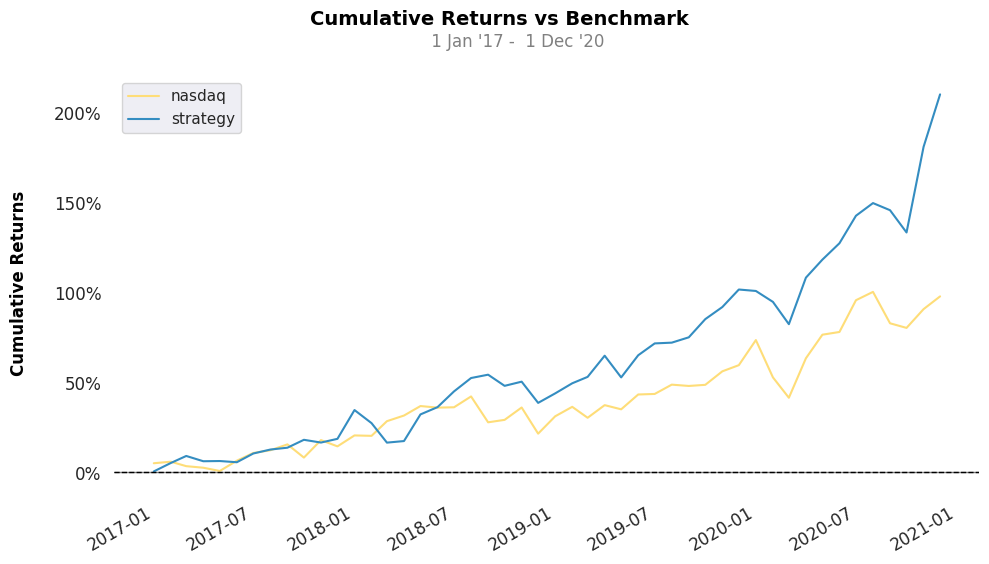

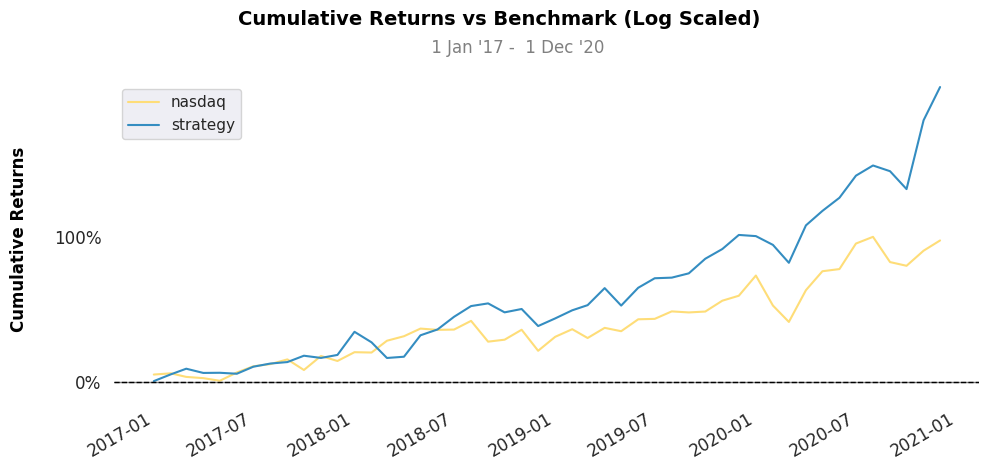

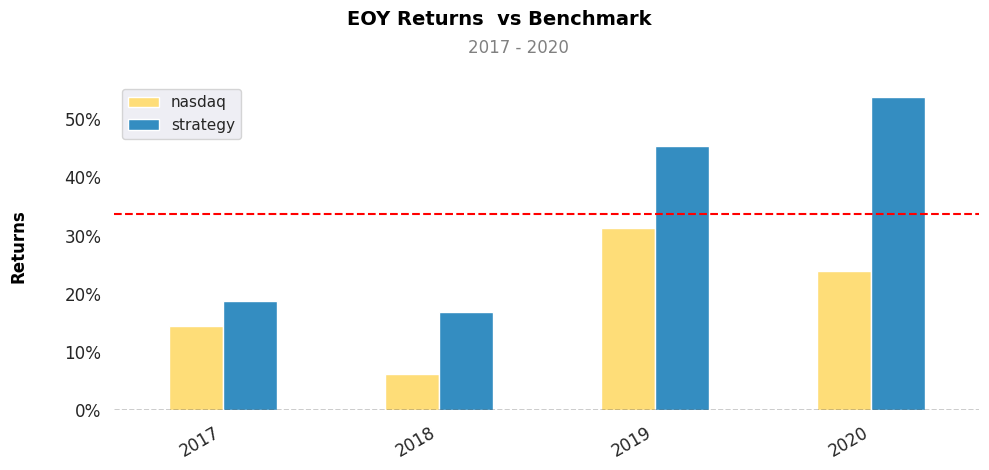

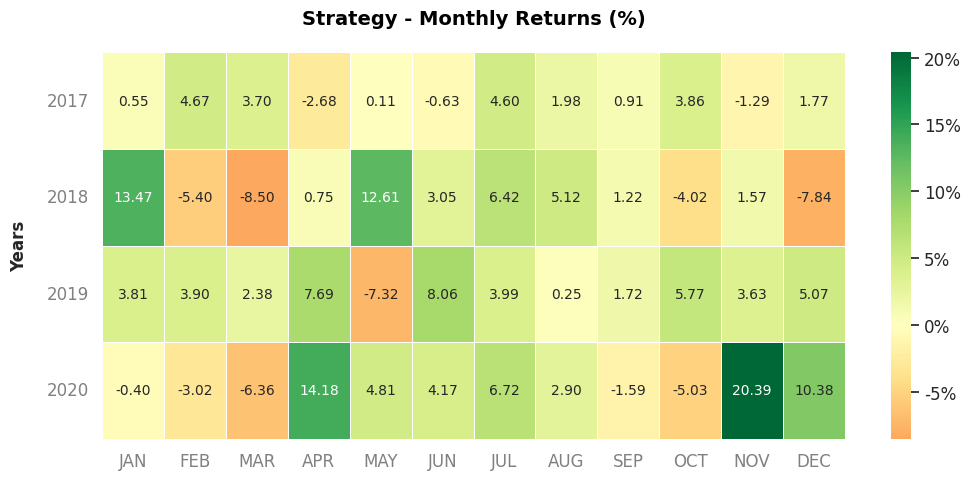

In [248]:
print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['strategy'],frame_final['nasdaq'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.log_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['nasdaq'])

## Otimizando funções para permitir alterar o ajuste da carteira

In [52]:
def Analise_Fund(tickers,ratio,year,periodo = 'annual'):
    Full_table = pd.DataFrame()
    rank = pd.DataFrame()
    year_usado = year.copy()
    year_usado.insert(0,str(int(year[0])-1))
    year_usado = [int(x) for x in year_usado]
    
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period = periodo)
        table = data.T[ratio]
        table.index = pd.to_datetime(table.index)
        table['Company'] = p
        Full_table = Full_table.append(table)

    Full_table = Full_table[Full_table.index.year.isin(year_usado)]
    Full_table = Full_table.sort_index()
    
    if periodo != 'annual':
        data_to_retrieve = []
        for mes in ['-01-01','-04-01','-07-01','-10-01']:
            for idx in year:
                data_to_retrieve.append(idx + mes)
    else:
        data_to_retrieve = [idx + '-01-01' for idx in year]
    
    data_to_retrieve = sorted(data_to_retrieve)
    new_Full_table = pd.DataFrame()
    for data in data_to_retrieve:
        relevant_data = Full_table.loc[(Full_table.index <= data) & (Full_table['Company'].isin(tickers))]
        relevant_data = relevant_data.groupby('Company').last().reset_index()
        
        relevant_data = relevant_data[(relevant_data != 0).all(1)]
        relevant_data.index = [data]*len(relevant_data.index)
        new_Full_table = new_Full_table.append(relevant_data)
    
    company = new_Full_table['Company']
    company =  company.reset_index(drop = True)
    new_Full_table = new_Full_table.drop('Company',axis=1)   
    new_Full_table = new_Full_table.dropna()
    
    # calculando o score
    y = new_Full_table.copy()
    t_inv = 1/y
    bv = zscore2(t_inv)
    #bv = 1/zscore2(y)
    bv = bv.reset_index(drop = True)
    bv.insert(0,'Company',company)
    
    rank = bv
    rank.index = new_Full_table.index
    rank = rank.sort_index()

    rank = rank.loc[data_to_retrieve]

    return rank

def Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'annual'):

    percent_fscore_max = pd.DataFrame()
    percent_fscore_min = pd.DataFrame()
    percent_gscore_max = pd.DataFrame()
    vc = pd.DataFrame()
    
    year_usado = year.copy()
    year_usado.insert(0,str(int(year[0])-1))
    
    for steps in range(len(tickers)):
        # Fscore-Max analysis
        p = str(tickers[steps])
        data3 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose = data3.T[f_score_ratio_max].fillna(0)
        reverse = tranpose.loc[::-1]
        change = reverse.pct_change()
        change = change.assign(Company=p)
        percent_fscore_max = percent_fscore_max.append(change)

        # Fscore-Min analysis
        data4 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose1 = data4.T[f_score_ratio_min].fillna(0)
        reverse1 = tranpose1.loc[::-1]
        change1 = reverse1.pct_change()
        change1 = change1.assign(Company=p)
        percent_fscore_min = percent_fscore_min.append(change1)

        # Gscore-Max analysis
        data5 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose2 = data5.T[g_score_ratio_max].fillna(0)
        reverse2 = tranpose2.loc[::-1]
        change2 = reverse2.pct_change()
        change2 = change2.assign(Company=p)
        percent_gscore_max = percent_gscore_max.append(change2)

    # Condition to quantify the performance
    condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
    condition = pd.DataFrame(condition)
    condition.index = percent_fscore_max.index
    condition.columns = percent_fscore_max.columns[:-1]
    
    sum_score = condition.sum(axis=1)
    sum_score = pd.DataFrame(sum_score)
    sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
    sum_score.columns = ['F-Score-Max','Company']

    # Condition to quantify the performance
    condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
    condition2 = pd.DataFrame(condition2)
    condition2.index = percent_fscore_min.index
    condition2.columns = percent_fscore_min.columns[:-1]

    sum_score2 = condition2.sum(axis=1)
    sum_score2 = pd.DataFrame(sum_score2)
    sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
    sum_score2.columns = ['F-Score-Min','Company']

    # Condition to quantify the performance
    condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
    condition3 = pd.DataFrame(condition3)
    condition3.index = percent_gscore_max.index
    condition3.columns = percent_gscore_max.columns[:-1]
    sum_score3 = condition3.sum(axis=1)
    sum_score3 = pd.DataFrame(sum_score3)
    sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
    sum_score3.columns = ['G-Score-Max','Company']
    
    Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
    Final_yr_wise.index = pd.to_datetime(Final_yr_wise.index)
    Final_yr_wise = Final_yr_wise.sort_index()

    if periodo != 'annual':
        data_to_retrieve = []
        for mes in ['-01-01','-04-01','-07-01','-10-01']:
            for idx in year:
                data_to_retrieve.append(idx + mes)
    else:
        data_to_retrieve = [idx + '-01-01' for idx in year]
    
    data_to_retrieve = sorted(data_to_retrieve)
    new_Final_yr_wise = pd.DataFrame()    
    for data in data_to_retrieve:
        relevant_data = Final_yr_wise.loc[(Final_yr_wise.index <= data) & (Final_yr_wise['Company'].isin(tickers))]
        relevant_data = relevant_data.groupby('Company').last().reset_index()
        relevant_data.index = [data]*len(relevant_data.index)
        new_Final_yr_wise = new_Final_yr_wise.append(relevant_data)
    
    new_Final_yr_wise = new_Final_yr_wise.loc[data_to_retrieve]
    company = pd.DataFrame(new_Final_yr_wise['Company'])
    new_Final_yr_wise = new_Final_yr_wise.drop('Company',axis=1)
    vc = zscore2(new_Final_yr_wise[new_Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
    vc['Company'] = company
    
    return vc

def Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'annual',qtd = 6,weights = 'equal'):
    df = pd.DataFrame()
    
    rank = Analise_Fund(tickers,ratio,year,periodo)
    vc = Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo)

    vc_new = vc.reset_index()
    vc_new['index'] = vc_new['index'].astype(str)
    vc_new['key'] = vc_new['index'] + '_' + vc_new['Company']
    
    vc_new = vc_new.drop_duplicates(subset='key')

    rank_new = rank.reset_index()
    rank_new['index'] = rank_new['index'].astype(str)
    rank_new['key'] = rank_new['index'] + '_' + rank_new['Company']
    
    df = vc_new.merge(rank_new, on='key')
    df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
    df.index = df['index_x']
    
    dataframe = df.drop(labels='index_x', axis=1)
    dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
        dataframe['Z-Score'].values
    dataframe_final = dataframe.drop(
        labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
    
    # Ações a serem investidas pela estratégia
    df2 = pd.DataFrame()
    df_pesos = pd.DataFrame()
    idx = sorted(set(dataframe_final.index))
    comp_index = []
    for steps in range (0,len(idx)):
        step = idx[steps]

        sorted_table = (dataframe_final.loc[step]).sort_values(
            by='Cumulative-Score', ascending=False)

        selection = sorted_table[['Company_y']].head(qtd)
        comp_index += [step]*len(selection)
        pesos = sorted_table[['Cumulative-Score']].head(qtd)
        array = np.array(selection['Company_y'])
        pesos = np.array(pesos['Cumulative-Score'])
        frame = pd.DataFrame(array)
        frame_pesos = pd.DataFrame(pesos)
        df2 = df2.append(frame)
        df_pesos = df_pesos.append(frame_pesos)

    #comp_index = np.repeat(idx, qtd)
    df2.index = comp_index
    df_pesos.index = comp_index
    df2.columns = ['Companies-Invested']
    df_pesos.columns = ['Companies-Invested']

    Estrategia = pd.DataFrame()
    Pesos = pd.DataFrame()
    for steps in range(len(idx)):
        f = df2.loc[idx[steps]]['Companies-Invested'].T
        f2 = df_pesos.loc[idx[steps]]['Companies-Invested'].T
        mk = np.array(f)
        mk2 = np.array(f2)
        l = pd.DataFrame(mk).T
        l2 = pd.DataFrame(mk2).T
        Estrategia = Estrategia.append(l)
        Pesos = Pesos.append(l2)

    Estrategia.index = idx
    Pesos.index = idx
    
    # calculando o retorno da estratégia
    inicio = str(int(year[0]) - 1)  + '-11-30'
    final = str(int(year[-1])) + '-12-31'
    
    stock = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
    
    volume = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Volume']]

    volume.index = pd.to_datetime(volume.index)
    volume.columns = tickers

    stock.index = pd.to_datetime(stock.index)
    stock.columns = tickers
    returns = stock.pct_change()

    retorno_estrategia = pd.DataFrame()
    idx = sorted(set(Estrategia.index))
    
    for steps in range (0,len(idx)):
        step = idx[steps]
        
        array = np.array(Estrategia.loc[step])
        array = [i for i in array if str(i) not in ['nan','NaN','']]
        peso = np.array(Pesos.loc[step])
        peso = [i for i in peso if str(i) not in ['nan','NaN','']]
                 
        if step != idx[-1]:
            step1 = idx[steps + 1]
            returns_selection = returns.loc[step:step1]
            returns_selection = returns_selection.drop(step1)
        else:
            returns_selection = returns.loc[step:]

        selected_returns = returns_selection[array]
        
        # Making the portfolio with equal weights among its components
        if weights == 'equal':
            weight = np.repeat(1/len(array), len(array))
        elif weights == 'weighted':
            weight = [valor/sum(peso) for valor in peso]
            #weight = normaliza(weight)
            
        series = (selected_returns * weight).sum(axis=1)
        frame = pd.DataFrame(series)
        retorno_estrategia = retorno_estrategia.append(frame)
    
    retorno_estrategia.columns = ['Returns']
    retorno_estrategia.index = pd.to_datetime(retorno_estrategia.index).to_period('M').to_timestamp()

    return retorno_estrategia,Estrategia

# Criando benchmark para setores individuais
def Benchmark(tickers,year,periodo = 'annual',weights ='equal'):
    
    inicio = str(int(year[0]) - 1)  + '-11-30'
    final = str(int(year[-1])) + '-12-31'
    
    # Pegando o histórico do preço e do volume dos ativos
    stock = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
    volume = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Volume']]
    stock.index = pd.to_datetime(stock.index)
    stock.columns = tickers
    volume.index = pd.to_datetime(volume.index)
    volume.columns = tickers
    returns = stock.pct_change()

    # datas que serão feitas o ajuste da carteira
    if periodo != 'annual':
        index = []
        for idx in year:
            for mes in ['-01-01','-04-01','-07-01','-10-01']:
                index.append(idx + mes)
    else:
        index = [idx + '-01-01' for idx in year]
    index = pd.to_datetime(sorted(index))
    
    # calculando o retorno com peso ponderado ou não
    df = pd.DataFrame()
    print(weights)
    for steps in range (0,len(index)):
        step = index[steps]
        print(step)
        if step != index[-1]:
            step1 = index[steps + 1]
            returns_selection = returns.loc[step:step1]
            returns_selection = returns_selection.drop(step1)
        else:
            returns_selection = returns.loc[step:]
        
        # pegando o volume dos últimos 3 meses
        volume_selection = volume.loc[step - timedelta(days=3*31):step].fillna(0)
        volume_selection = volume_selection.mean()
        
        # escolhendo os ativos que tiveram volume de negociação
        array = volume_selection[volume_selection != 0].index.tolist()
        volume_selection = volume_selection[array]
        selected_returns = returns_selection[array]
        
#         peso = []
#         for i in array:
#             print(i)
#             data = fa.key_metrics(
#             ticker=i, api_key=key, period = periodo)
#             table = data.T[['marketCap']]
#             table.index = pd.to_datetime(table.index)
#             table = table.sort_index()
#             print('index')
#             print(table.head())
#             if step < table.index[0]:
#                 # ainda não tem dado
#                 peso.append(0)
#             else:
#                 peso.append(int(table[table.index <= step].iloc[0]))
        
        # Calculando o retorno do portifólio com peso ponderado ou igual
        if weights == 'equal':
            weight = np.repeat(1/len(array), len(array))
        elif weights == 'weighted':
            # cada peso terá valor no máximo de 20%
            #weight = np.array(list(map(lambda x : x/sum(peso),peso)))
            weight = [peso / sum(volume_selection) for peso in volume_selection]
            weight = normaliza(weight)
        
        print(array)
        print(weight)
        series = (selected_returns * weight).sum(axis=1)
        frame = pd.DataFrame(series)
        df = df.append(frame)
        
    df.columns = ['Returns']
    df.index = pd.to_datetime(df.index).to_period('M').to_timestamp()
    return df

# def comparar_estrategia(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,benchmark_returns,name_benchmark,qtd = 6,periodo = 'annual',weights = 'equal'):
#     # retorno da estratégia
#     estrategia,pesos = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo,qtd)
    
#     inicio = str(int(year[0]) - 1)  + '-12-31'
#     final = str(int(year[-1]) + 1) + '-01-31'
    
#     stock = yf.download(tickers=tickers, start=inicio,
#                     end=final, interval='1mo')[['Adj Close']]
    
#     volume = yf.download(tickers=tickers, start=inicio,
#                     end=final, interval='1mo')[['Volume']]

#     volume.index = pd.to_datetime(volume.index)
#     volume.columns = tickers

#     stock.index = pd.to_datetime(stock.index)
#     stock.columns = tickers
#     returns = stock.pct_change()

#     df = pd.DataFrame()
#     idx = sorted(set(estrategia.index))
#     print(weights)
    
#     for steps in range (0,len(idx)):
#         step = idx[steps]
#         print(step)
#         array = np.array(estrategia.loc[step])
#         array = [i for i in array if str(i) not in ['nan','NaN','']]
#         peso = np.array(pesos.loc[step])
#         peso = [i for i in peso if str(i) not in ['nan','NaN','']]
                 
#         if step != idx[-1]:
#             step1 = idx[steps + 1]
#             returns_selection = returns.loc[step:step1]
#             returns_selection = returns_selection.drop(step1)
#         else:
#             returns_selection = returns.loc[step:]

#         selected_returns = returns_selection[array]
        
#         # Making the portfolio with equal weights among its components
#         if weights == 'equal':
#             weight = np.repeat(1/len(array), len(array))
#         elif weights == 'weighted':
#             weight = [valor/sum(peso) for valor in peso]
#             # pegando o volume dos últimos 3 meses
#             #volume_selection = volume.loc[pd.to_datetime(step) - timedelta(days=3*31):step].fillna(0)
#             #volume_selection = volume_selection.mean()[array]
#             #weight = [valor/sum(volume_selection) for valor in volume_selection]
#             #weight = normaliza(weight)
            
#         print(array)
#         print(weight)
#         series = (selected_returns * weight).sum(axis=1)
#         frame = pd.DataFrame(series)
#         df = df.append(frame)
    
#     df.columns = ['Returns']
#     df.index = pd.to_datetime(df.index).to_period('M')
    
#     # comparando a estratégia com o benchmark
#     frame_final = pd.concat([df, benchmark_returns], axis=1)
#     frame_final.columns = ['Strategy', name_benchmark]
#     frame_final.index = frame_final.index.to_timestamp()
#     print('verificando retorno')
#     print(frame_final.head(30))
#     print("\033[1mPerformance Metrics\033[0m\n")
#     qs.reports.metrics(frame_final['Strategy'],frame_final[name_benchmark],mode='full')

#     print("\n\033[1mStrategy Visualization\033[0m\n")

#     qs.plots.returns(frame_final['Strategy'],frame_final[name_benchmark])
#     qs.plots.log_returns(frame_final['Strategy'],frame_final[name_benchmark])
#     qs.plots.yearly_returns(frame_final['Strategy'],frame_final[name_benchmark])
#     qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final[name_benchmark])
    
#     return estrategia

In [179]:
#BMGB4 - 2019
#BPAC3 - 2017
#BPAN4 - 2014
#BSLI3 - 2017

tickers_br = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BBAS3.SA",
              "BPAC3.SA","BRSR3.SA","BPAN4.SA","BSLI3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020','2021','2022']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

Analise_Fund(tickers_br,ratio,year_br,'quarter')

Company   Z-Score
2011-01-01  RPAD3.SA  1.241980
2011-04-01  ABCB4.SA  0.854720
2011-04-01  BBAS3.SA  0.868315
2011-04-01  BSLI3.SA  1.046788
2011-07-01  ABCB4.SA  0.871042
...              ...       ...
2022-10-01  BMGB4.SA  1.453560
2022-10-01  BPAC3.SA  0.714995
2022-10-01  BPAN4.SA  0.878136
2022-10-01  BRSR3.SA  1.097454
2022-10-01  BSLI3.SA  0.706024

[266 rows x 2 columns]

In [40]:
tickers_br = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BBAS3.SA",
              "BPAC3.SA","BRSR3.SA","BPAN4.SA","BSLI3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020','2021','2022']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

Analise_Quant(tickers_br,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,periodo = 'quarter')

            F-Score-Max  F-Score-Min  G-Score-Max   Company
2010-03-01           -4           -3           -6  RPAD3.SA
2010-03-01           -4           -3            4  ABCB4.SA
2010-03-01           -4           -1           -2  BRSR3.SA
2010-03-01            0           -1            4  BPAN4.SA
2010-03-01           -4           -3           -4  BSLI3.SA
...                 ...          ...          ...       ...
2022-12-01            2           -1            2  BMGB4.SA
2022-12-01           -4           -1            0  RPAD3.SA
2022-12-01           -2            1            0  BPAC3.SA
2022-12-01            0           -1            2  BRSR3.SA
2022-12-01            0           -3            0  BSLI3.SA

[375 rows x 4 columns]


Cumulative-F&G-Score   Company
2011-01-01              0.905998  ABCB4.SA
2011-01-01              1.669056  BBAS3.SA
2011-01-01              1.669056  BPAN4.SA
2011-01-01              1.362357  BRSR3.SA
2011-01-01              0.905998  BSLI3.SA
...                          ...       ...
2021-10-01              0.905998  BSLI3.SA
2021-10-01              0.636997  BRSR3.SA
2021-10-01              0.791661  BPAN4.SA
2021-10-01              0.636997  BPAC3.SA
2021-10-01              0.491164  BBAS3.SA

[320 rows x 2 columns]

In [90]:
b = b.sort_index()
b.head(50)

peRatio priceToSalesRatio   pbRatio   evToSales debtToEquity  \
2010-03-01    8.837745          5.023558  1.900661    5.011988            0   
2010-03-01    8.154065          6.198733  2.036774   -4.955476     0.523059   
2010-03-01     2.20487         74.225603         0        None            0   
2010-03-01     4.73786          2.550217         0        None            0   
2010-03-01   10.735999         10.601202  1.505009    9.877832            0   
2010-03-01    9.908523         20.394098  1.491551     20.1547            0   
2010-06-01    6.198309          1.521446  1.264481    1.407542            0   
2010-06-01    6.468426           3.59077  1.792869    4.060056     2.034114   
2010-06-01    2.653548           2.56832  1.248589   -0.393785     0.049596   
2010-06-01   33.177569         67.226063         0        None            0   
2010-06-01    8.211085         16.150158  1.288284   16.033839            0   
2010-09-01    8.754669         11.976722  1.906783   -1.843255     0.805249   
2010-09-01   11.402231         20.452872  1.753296   20.366938            0   
2010-09-01     5.76602          2.625371         0        None            0   
2010-09-01    7.371052          7.089399         0        None            0   
2010-09-01    4.049985         83.754294         0        None            0   
2010-12-01   18.269376          1.338881  0.723693    3.756866     1.310009   
2010-12-01    1.875841          3.213447  1.486692    2.954117            0   
2010-12-01    6.888384         -5.820792  1.644283   -4.042393      0.42084   
2010-12-01    6.250637          3.440275  1.654798   -0.267491            0   
2010-12-01    9.170537         17.210561  1.469716   17.023526            0   
2011-03-01    7.726852          7.639402         0        None            0   
2011-03-01    7.207033          5.656626  1.621938     2.05056     3.450238   
2011-03-01    7.081143          9.382702  1.159713   34.679752     3.137964   
2011-03-01    4.657545          2.210166  1.017445    2.215431            0   
2011-03-01    5.492691          3.194068  1.386604    0.720114     0.025696   
2011-03-01   10.317091        134.714175  0.554802  134.505232            0   
2011-06-01    6.028966          6.025533  1.330764    4.156942     0.364085   
2011-06-01    6.595583          9.173648  1.115592    24.35116     1.856459   
2011-06-01    7.906773        121.014321  0.593698  120.683937            0   
2011-06-01  -14.533379          3.710226  1.095231    3.715366            0   
2011-06-01    5.974327          4.753071  1.479711   -9.060378     0.178871   
2011-06-01    3.486335          2.845079  1.393854    0.322892     0.063817   
2011-09-01    5.858737          2.410049  1.168824    -0.89243     0.043001   
2011-09-01  144.227546          9.501664  1.223143     3.61975            0   
2011-09-01    5.808908          5.850488  1.293121    3.813435     0.468835   
2011-09-01    15.55761          7.236793         0        None            0   
2011-09-01    6.232156         137.39447  0.611959  135.986584            0   
2011-09-01    6.098226          5.387122  1.265948  -12.417298     0.216722   
2011-09-01     5.49473          7.599273  0.880991   32.431099     2.890895   
2011-12-01    6.590716          4.097733  1.358132    4.718772     0.489882   
2011-12-01    6.607609          9.293498  1.068141    30.03787     2.398375   
2011-12-01   -4.932646           7.51282  1.435448    3.999241     0.069456   
2011-12-01    8.666723          1.120802  0.643786    3.692779     1.481042   
2011-12-01   27.617108          1.085373  1.222428    0.980077            0   
2011-12-01    0.903701         -1.637264  0.414938  -19.429541     4.728855   
2011-12-01    3.623532          2.451566  1.200587   -6.720793     0.211429   
2012-03-01    7.877685          9.882411   1.16709    32.70758     2.706121   
2012-03-01    5.563142          2.767568  1.187303    0.041799     0.397735   
2012-03-01    8.115746          7.227648  1.529679    6.769193   

In [10]:
tickers = ["GILD"]
benchmark = yf.download(tickers=tickers, start='2017-01-01',
                        end='2018-01-01', interval='1mo')[['Adj Close']]

benchmark2 = yf.download(tickers=tickers, start='2017-01-01',
                        end='2018-01-01', interval='1mo')[['Close']]
benchmark,benchmark2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(            Adj Close
 Date                 
 2017-01-01  56.818825
 2017-02-01  55.273857
 2017-03-01  53.266174
 2017-04-01  54.173920
 2017-05-01  51.281490
 2017-06-01  55.936256
 2017-07-01  60.616482
 2017-08-01  66.686897
 2017-09-01  64.543915
 2017-10-01  60.089664
 2017-11-01  59.945385
 2017-12-01  57.428272,
                 Close
 Date                 
 2017-01-01  72.449997
 2017-02-01  70.480003
 2017-03-01  67.919998
 2017-04-01  68.550003
 2017-05-01  64.889999
 2017-06-01  70.779999
 2017-07-01  76.089996
 2017-08-01  83.709999
 2017-09-01  81.019997
 2017-10-01  74.959999
 2017-11-01  74.779999
 2017-12-01  71.639999)

In [139]:
tickers_br = ["SANB4.SA","BSLI3.SA","ITUB3.SA"]

benchmark = yf.download(tickers=tickers_br, start='2017-01-01',
                        end='2018-01-01', interval='1mo')

benchmark2 = yf.download(tickers=tickers, start='2017-01-01',
                        end='2018-01-01', interval='1mo')[['Close']]
benchmark.head()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  14 of 14 completed


Adj Close                          Close                      \
            BSLI3.SA   ITUB3.SA  SANB4.SA  BSLI3.SA   ITUB3.SA SANB4.SA   
Date                                                                      
2017-01-01  1.964040  15.671473  7.184513  2.777777  21.433332    11.15   
2017-02-01  2.160444  17.074121  8.955091  3.055555  23.340000    13.15   
2017-03-01  2.160444  16.842163  7.954029  3.055555  22.513332    11.68   
2017-04-01  2.160444  16.994078  7.559052  3.055555  22.706667    11.10   
2017-05-01  2.220536  16.113113  6.912105  3.055555  21.520000    10.15   

                High                           Low                      \
            BSLI3.SA   ITUB3.SA SANB4.SA  BSLI3.SA   ITUB3.SA SANB4.SA   
Date                                                                     
2017-01-01  2.777777  22.120001    11.60  2.777777  19.573334     9.31   
2017-02-01  3.055555  24.253332    13.79  2.777777  21.133333    11.00   
2017-03-01  3.055555  23.666666    13.50  3.055555  21.913334    11.00   
2017-04-01  3.055555  23.000000    11.60  3.055555  21.713333    10.25   
2017-05-01  3.055555  23.726665    11.49  3.055555  20.186666     9.80   

                Open                       Volume                    
            BSLI3.SA   ITUB3.SA SANB4.SA BSLI3.SA ITUB3.SA SANB4.SA  
Date                                                                 
2017-01-01  2.777777  19.700001    10.36        0  4505700   598800  
2017-02-01  2.777777  21.473333    11.15     2700  6116400   273500  
2017-03-01  3.055555  23.333332    13.16        0  4235550   302800  
2017-04-01  3.055555  22.506666    11.42        0  2572500   251200  
2017-05-01  3.055555  22.706667    11.10        0  5910300   326500

In [9]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

year = ['2017','2018', '2019', '2020']

Analise_Fund(tickers,ratio,year,'quarter')

Company   Z-Score
2017-01-01    AMAT  1.077885
2017-01-01     AMD  0.814683
2017-01-01    ATVI  1.195298
2017-01-01    CSCO  1.172793
2017-01-01    GILD  1.210848
...            ...       ...
2020-10-01    PCAR  1.402801
2020-10-01     PEP  0.870344
2020-10-01    QCOM  0.780786
2020-10-01    TSLA  0.607917
2020-10-01     TXN  0.668787

[224 rows x 2 columns]

In [28]:
Analise_Fund(tickers,ratio,year,'annual')

Company   Z-Score
2017-01-01    AMAT  1.037789
2017-01-01     AMD  1.250899
2017-01-01    ATVI  0.955421
2017-01-01    CSCO  1.258022
2017-01-01    GILD  0.929211
2017-01-01    GOOG  1.161598
2017-01-01    INTC  1.274634
2017-01-01    MSFT  0.864169
2017-01-01      MU  1.345453
2017-01-01    PCAR  1.156443
2017-01-01     PEP  0.815407
2017-01-01    QCOM  1.258944
2017-01-01    TSLA  1.881994
2017-01-01     TXN  0.961525
2018-01-01    AMAT  1.442365
2018-01-01     AMD  1.364047
2018-01-01    ATVI  1.303744
2018-01-01    CSCO  0.625797
2018-01-01    GILD  1.022158
2018-01-01    GOOG  1.372557
2018-01-01    INTC  1.342397
2018-01-01    MSFT  0.840618
2018-01-01      MU  1.581685
2018-01-01    PCAR  1.234288
2018-01-01     PEP  0.997003
2018-01-01    QCOM  0.344412
2018-01-01    TSLA  1.344218
2018-01-01     TXN  0.986275
2019-01-01    AMAT  1.184897
2019-01-01     AMD  0.811497
2019-01-01    ATVI  1.150723
2019-01-01    CSCO  1.104945
2019-01-01    GILD  1.041703
2019-01-01    GOOG  1.285128
2019-01-01    INTC  1.282422
2019-01-01    MSFT  0.806683
2019-01-01      MU  1.552201
2019-01-01    PCAR  1.207536
2019-01-01     PEP  0.937238
2019-01-01    QCOM  0.796773
2019-01-01    TSLA  0.951119
2019-01-01     TXN  0.780465
2020-01-01    AMAT  1.290641
2020-01-01     AMD  0.726762
2020-01-01    ATVI  0.978523
2020-01-01    CSCO  1.322233
2020-01-01    GILD  0.727353
2020-01-01    GOOG  1.188932
2020-01-01    INTC  1.356618
2020-01-01    MSFT  0.705848
2020-01-01      MU  0.834640
2020-01-01    PCAR  1.178830
2020-01-01     PEP  0.821357
2020-01-01    QCOM  0.716490
2020-01-01    TSLA  0.346410
2020-01-01     TXN  0.661619

In [29]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'annual')

Cumulative-F&G-Score Company
2017-01-01              0.926738    AMAT
2017-01-01              0.786371     AMD
2017-01-01              1.180420    ATVI
2017-01-01              0.410626    CSCO
2017-01-01              0.786371    GILD
2017-01-01              0.410626    GOOG
2017-01-01              0.410626    INTC
2017-01-01              1.954850    MSFT
2017-01-01              0.713572      MU
2017-01-01              0.653109    PCAR
2017-01-01              0.653109     PEP
2017-01-01              0.653109    QCOM
2017-01-01              1.050683    TSLA
2017-01-01              0.653109     TXN
2018-01-01              1.050683    AMAT
2018-01-01              2.536670     AMD
2018-01-01              2.084587    ATVI
2018-01-01              0.713572    CSCO
2018-01-01              2.666407    GILD
2018-01-01              1.502767    GOOG
2018-01-01              2.084587    INTC
2018-01-01              0.713572    MSFT
2018-01-01              1.502767      MU
2018-01-01              0.926738    PCAR
2018-01-01              1.050683     PEP
2018-01-01              1.762240    QCOM
2018-01-01              0.539524    TSLA
2018-01-01              0.653109     TXN
2019-01-01              0.713572    AMAT
2019-01-01              1.050683     AMD
2019-01-01              2.214323    ATVI
2019-01-01              1.050683    CSCO
2019-01-01              1.180420    GILD
2019-01-01              0.713572    GOOG
2019-01-01              0.410626    INTC
2019-01-01              2.084587    MSFT
2019-01-01              0.504230      MU
2019-01-01              0.713572    PCAR
2019-01-01              0.539524     PEP
2019-01-01              1.180420    QCOM
2019-01-01              0.713572    TSLA
2019-01-01              1.632503     TXN
2020-01-01              2.084587    AMAT
2020-01-01              2.084587     AMD
2020-01-01              1.502767    ATVI
2020-01-01              1.502767    CSCO
2020-01-01              0.410626    GILD
2020-01-01              1.050683    GOOG
2020-01-01              0.713572    INTC
2020-01-01              1.632503    MSFT
2020-01-01              1.050683      MU
2020-01-01              1.050683    PCAR
2020-01-01              0.653109     PEP
2020-01-01              0.926738    QCOM
2020-01-01              1.180420    TSLA
2020-01-01              2.084587     TXN

In [30]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'quarter')

Cumulative-F&G-Score Company
2017-01-01              1.891444    AMAT
2017-01-01              1.000080     AMD
2017-01-01              1.991356    ATVI
2017-01-01              1.891444    CSCO
2017-01-01              1.495718    GILD
...                          ...     ...
2020-10-01              0.909229    PCAR
2020-10-01              1.495718     PEP
2020-10-01              1.991356    QCOM
2020-10-01              1.395805    TSLA
2020-10-01              1.000080     TXN

[224 rows x 2 columns]

In [26]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

year = ['2017','2018', '2019', '2020']

Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'annual',6)

(               0     1     2     3     4     5
 2017-01-01  TSLA  MSFT  ATVI    MU   AMD  AMAT
 2018-01-01   AMD  GILD  INTC  ATVI    MU  GOOG
 2019-01-01  ATVI  MSFT   TXN  GILD  CSCO    MU
 2020-01-01  AMAT  CSCO   AMD   TXN  ATVI  MSFT,
                    0         1         2         3         4         5
 2017-01-01  2.932677  2.819019  2.135841  2.059025  2.037271  1.964527
 2018-01-01  3.900717  3.688565  3.426983  3.388331  3.084452  2.875324
 2019-01-01  3.365046  2.891270  2.412968  2.222123  2.155628  2.056432
 2020-01-01  3.375228  2.824999  2.811349  2.746205  2.481290  2.338352)

#### Compararando com a Nasdaq

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
equal
2017-01-01
['MSFT', 'MU', 'PCAR', 'AMAT', 'ATVI', 'GILD']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2018-01-01
['GOOG', 'MU', 'GILD', 'INTC', 'AMD', 'PCAR']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2019-01-01
['ATVI', 'MSFT', 'PCAR', 'MU', 'TXN', 'GILD']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2020-01-01
['AMAT', 'AMD', 'TXN', 'CSCO', 'PCAR', 'MU']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Performance Metrics

                           Nasdaq      Estratégia
-------------------------  ----------  ------------
Start Period               2017-02-01  2017-02-01
End Period                 2021-01-01  2021-01-01
Risk-Free Rate             0.0%        0.0%
Time in Market  

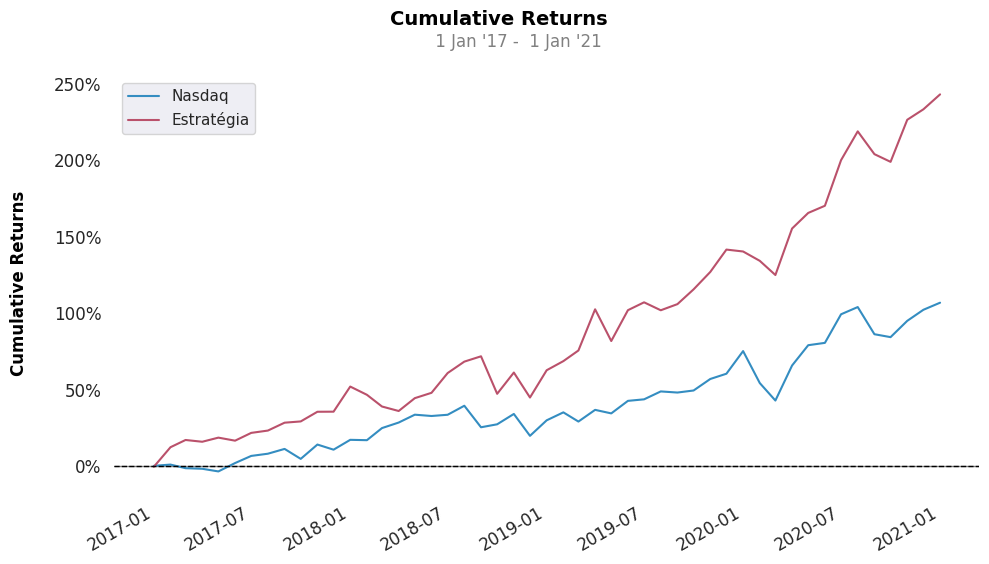

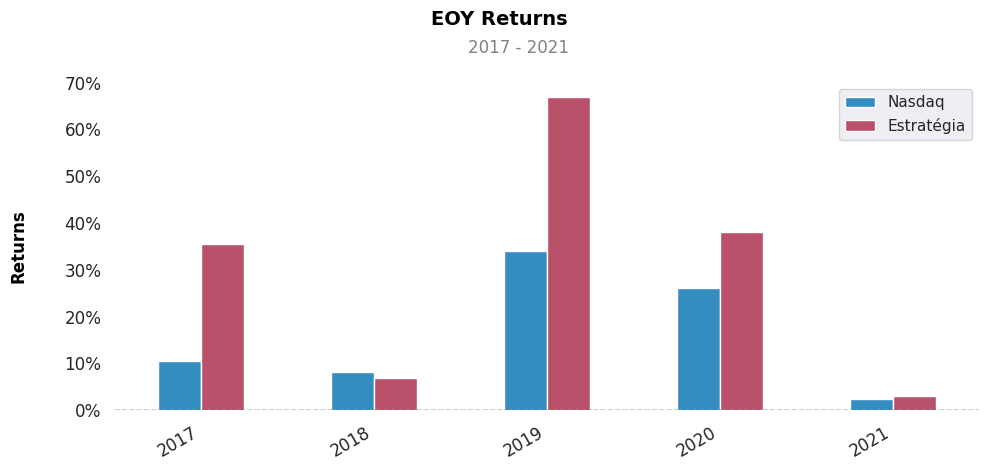

In [185]:
tickers = ['GILD', 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

inicio = str(int(year[0]) - 1)  + '-12-31'
final = str(int(year[-1]) + 1) + '-01-31'
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

ticker_benchmark = 'NDAQ'

# retorno do benchmark
benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns.columns = ['Nasdaq']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'annual',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
df.index = pd.to_datetime(df.index).to_period('M').to_timestamp()

qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
equal
2017-01-01
['INTC', 'GOOG', 'ATVI', 'CSCO', 'PCAR', 'AMAT']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2017-04-01
['GOOG', 'TSLA', 'ATVI', 'PCAR', 'MU', 'QCOM']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2017-07-01
['MU', 'GILD', 'AMAT', 'PEP', 'QCOM', 'ATVI']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2017-10-01
['MU', 'PCAR', 'INTC', 'GILD', 'AMD', 'TSLA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2018-01-01
['MU', 'AMD', 'PCAR', 'INTC', 'GILD', 'TSLA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2018-04-01
['MU', 'AMD', 'GOOG', 'PCAR', 'AMAT', 'ATVI']
[0.16666667 0.16666667 0.166

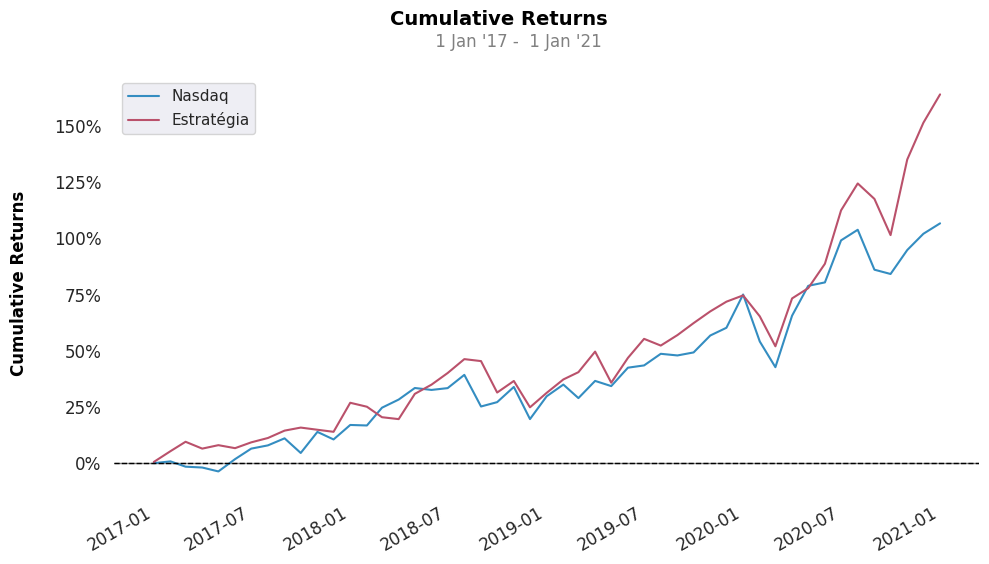

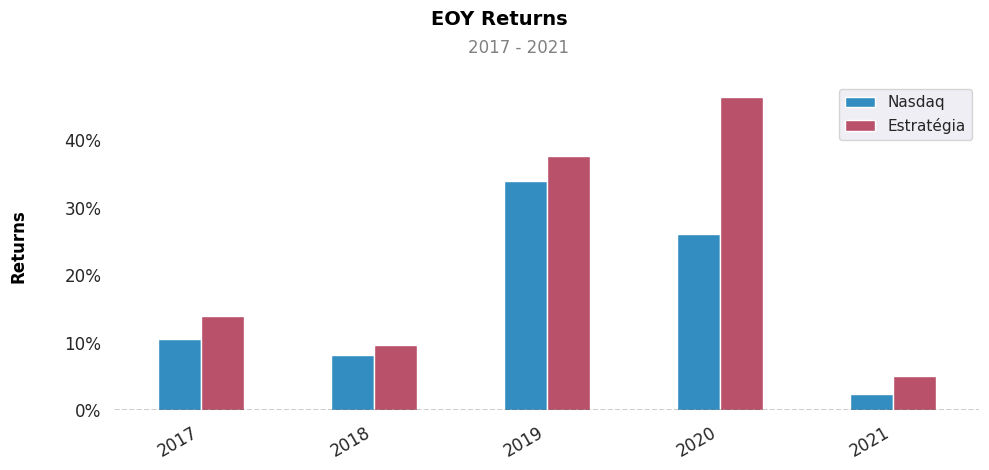

In [186]:
tickers = ['GILD', 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

inicio = str(int(year[0]) - 1)  + '-12-31'
final = str(int(year[-1]) + 1) + '-01-31'
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

ticker_benchmark = 'NDAQ'
name_benchmark = 'nasdaq'

# retorno do benchmark
benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark_returns = benchmark.pct_change().dropna()

ticker_benchmark = 'NDAQ'

# retorno do benchmark
benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns.columns = ['Nasdaq']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'quarter',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
df.index = pd.to_datetime(df.index).to_period('M').to_timestamp()

qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

#### Compararando com o Ibovespa

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  84 of 84 completed
[*********************100%***********************]  84 of 84 completed
equal
2011-01-01
['EZTC3.SA', 'SMTO3.SA', 'EGIE3.SA', 'VALE3.SA', 'TOTS3.SA', 'EQTL3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2012-01-01
['EGIE3.SA', 'CSAN3.SA', 'EMBR3.SA', 'ABEV3.SA', 'FLRY3.SA', 'DXCO3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2013-01-01
['MRFG3.SA', 'CVCB3.SA', 'UGPA3.SA', 'MRVE3.SA', 'CMIG4.SA', 'VALE3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2014-01-01
['SMTO3.SA', 'MULT3.SA', 'USIM5.SA', 'MRVE3.SA', 'VIVT3.SA', 'SUZB3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2015-01-01
['EQTL3.SA', 'TIMS3.SA', 'PETR4.SA', 'LREN3.SA', 'GOAU4.SA', 'PETR3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2016-01-01
['HYPE3.SA',

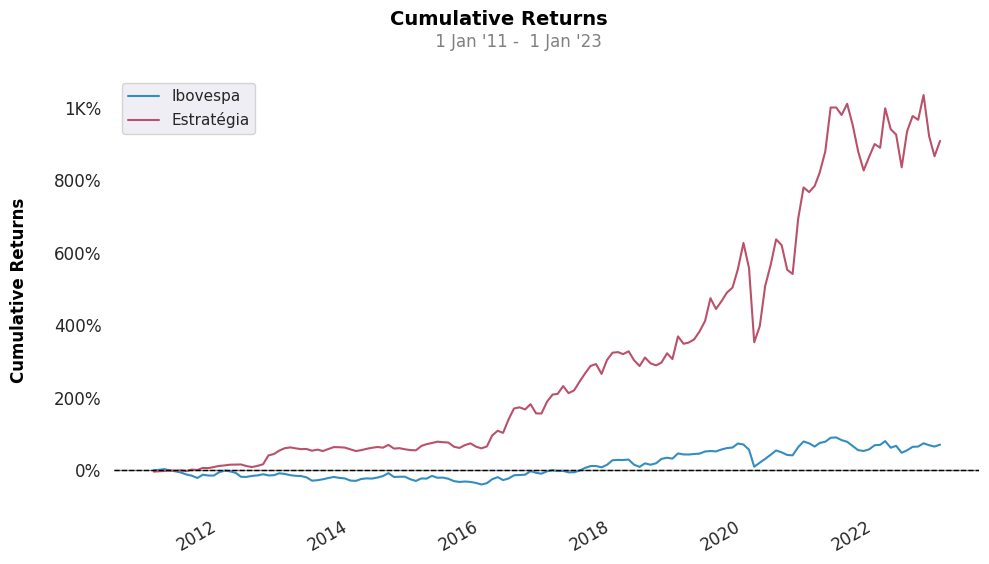

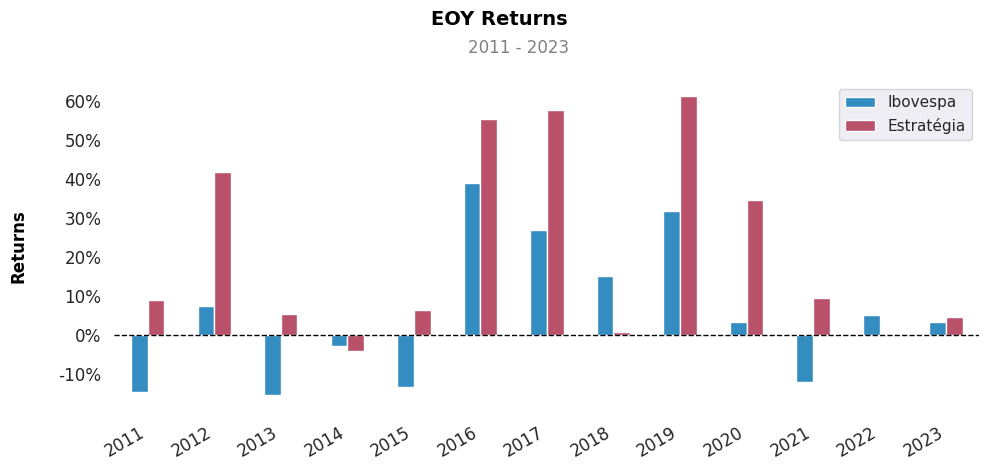

In [187]:
#IBOV - Carteira do Dia 29/06/23
tickers_br = [
    "VALE3.SA","PETR4.SA","ITUB4.SA","PETR3.SA","BBDC4.SA","B3SA3.SA",
    "ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA","WEGE3.SA",
    "BPAC11.SA","RDOR3.SA","EQTL3.SA","RADL3.SA","SUZB3.SA","PRIO3.SA",
    "GGBR4.SA","RAIL3.SA","BBDC3.SA","CSAN3.SA","BBSE3.SA","LREN3.SA",
    "UGPA3.SA","VBBR3.SA","ENEV3.SA","SBSP3.SA","JBSS3.SA","VIVT3.SA",
    "CMIG4.SA","HAPV3.SA","HYPE3.SA","ASAI3.SA","KLBN11.SA","TOTS3.SA",
    "NTCO3.SA","CCRO3.SA","EMBR3.SA","ALSO3.SA","CPLE6.SA","ELET6.SA",
    "ENGI11.SA","TIMS3.SA","EGIE3.SA","SANB11.SA","MGLU3.SA","BRFS3.SA",
    "TAEE11.SA","GOAU4.SA","BRKM5.SA","CSNA3.SA","MULT3.SA","RRRP3.SA",
    "AZUL4.SA","FLRY3.SA","CPFE3.SA","SOMA3.SA","CRFB3.SA","CASH3.SA",
    "COGN3.SA","BRAP4.SA","YDUQ3.SA","CYRE3.SA","SMTO3.SA","CVCB3.SA",
    "CIEL3.SA","IGTI11.SA","CMIN3.SA","ARZZ3.SA","SLCE3.SA","USIM5.SA",
    "LWSA3.SA","IRBR3.SA","VIIA3.SA","MRVE3.SA","GOLL4.SA","BEEF3.SA",
    "PCAR3.SA","DXCO3.SA","PETZ3.SA","MRFG3.SA","ALPA4.SA","EZTC3.SA",]

#tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA",
 #             "ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
  #            "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
   #           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016',
           '2017','2018', '2019', '2020','2021','2022']

inicio = str(int(year_br[0]) - 1)  + '-12-31'
final = str(int(year_br[-1]) + 1) + '-01-31'
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_br = '^BVSP'

# retorno do benchmark
benchmark = yf.download(tickers=benchmark_br, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns.columns = ['Ibovespa']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,periodo = 'annual',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
df.index = pd.to_datetime(df.index).to_period('M').to_timestamp()

qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  84 of 84 completed
[*********************100%***********************]  84 of 84 completed
equal
2011-01-01
['PRIO3.SA', 'ABEV3.SA', 'GOLL4.SA', 'EMBR3.SA', 'PETR4.SA', 'PETR3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-04-01
['ITUB4.SA', 'PETR4.SA', 'PETR3.SA', 'VALE3.SA', 'ELET3.SA', 'ELET6.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-07-01
['RADL3.SA', 'HYPE3.SA', 'EGIE3.SA', 'KLBN11.SA', 'ENGI11.SA', 'TAEE11.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-10-01
['CYRE3.SA', 'UGPA3.SA', 'VIVT3.SA', 'TOTS3.SA', 'CPLE6.SA', 'YDUQ3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2012-01-01
['TIMS3.SA', 'VALE3.SA', 'ABEV3.SA', 'EGIE3.SA', 'VIIA3.SA', 'EMBR3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2012-04-01
['CSAN3.S

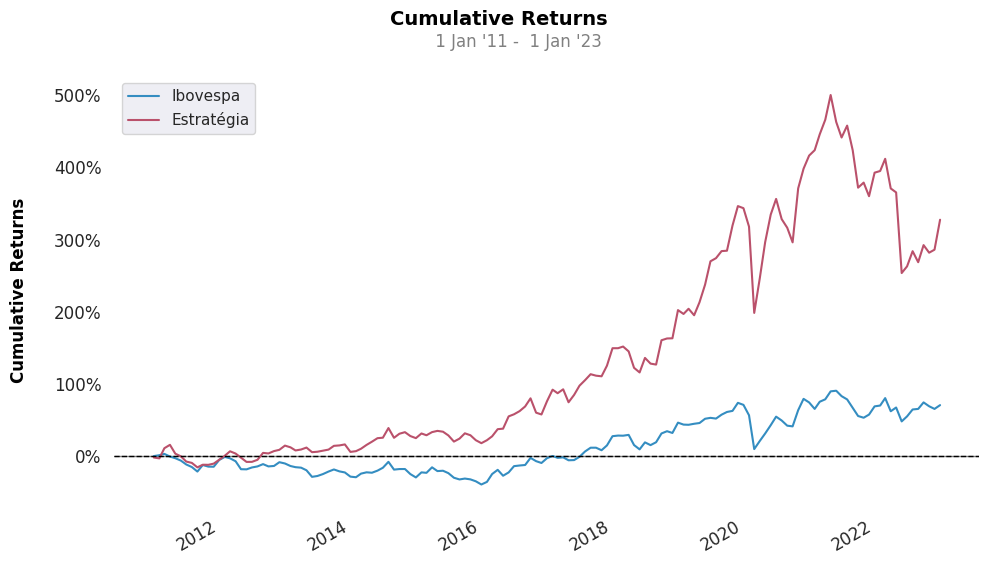

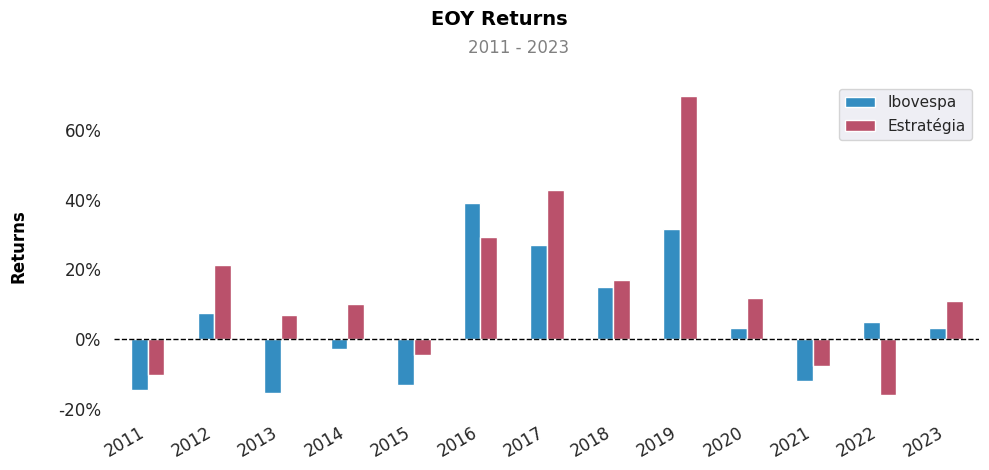

In [188]:
#IBOV - Carteira do Dia 29/06/23
tickers_br = [
    "VALE3.SA","PETR4.SA","ITUB4.SA","PETR3.SA","BBDC4.SA","B3SA3.SA",
    "ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA","WEGE3.SA",
    "BPAC11.SA","RDOR3.SA","EQTL3.SA","RADL3.SA","SUZB3.SA","PRIO3.SA",
    "GGBR4.SA","RAIL3.SA","BBDC3.SA","CSAN3.SA","BBSE3.SA","LREN3.SA",
    "UGPA3.SA","VBBR3.SA","ENEV3.SA","SBSP3.SA","JBSS3.SA","VIVT3.SA",
    "CMIG4.SA","HAPV3.SA","HYPE3.SA","ASAI3.SA","KLBN11.SA","TOTS3.SA",
    "NTCO3.SA","CCRO3.SA","EMBR3.SA","ALSO3.SA","CPLE6.SA","ELET6.SA",
    "ENGI11.SA","TIMS3.SA","EGIE3.SA","SANB11.SA","MGLU3.SA","BRFS3.SA",
    "TAEE11.SA","GOAU4.SA","BRKM5.SA","CSNA3.SA","MULT3.SA","RRRP3.SA",
    "AZUL4.SA","FLRY3.SA","CPFE3.SA","SOMA3.SA","CRFB3.SA","CASH3.SA",
    "COGN3.SA","BRAP4.SA","YDUQ3.SA","CYRE3.SA","SMTO3.SA","CVCB3.SA",
    "CIEL3.SA","IGTI11.SA","CMIN3.SA","ARZZ3.SA","SLCE3.SA","USIM5.SA",
    "LWSA3.SA","IRBR3.SA","VIIA3.SA","MRVE3.SA","GOLL4.SA","BEEF3.SA",
    "PCAR3.SA","DXCO3.SA","PETZ3.SA","MRFG3.SA","ALPA4.SA","EZTC3.SA",]

#tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA",
 #             "ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
  #            "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
   #           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016',
           '2017','2018', '2019', '2020','2021','2022']

inicio = str(int(year_br[0]) - 1)  + '-12-31'
final = str(int(year_br[-1]) + 1) + '-01-31'
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_br = '^BVSP'

# retorno do benchmark
benchmark = yf.download(tickers=benchmark_br, start=inicio,
                    end=final, interval='1mo')[['Adj Close']]
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns.columns = ['Ibovespa']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,periodo = 'quarter',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
df.index = pd.to_datetime(df.index).to_period('M').to_timestamp()

qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

#### Fazendo análises de setores de ativos separados

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
equal
2011-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
2011-04-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
2011-07-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3

['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
2017-07-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BRSR3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
2017-10-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BRSR3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
equal
2011-01-01
['BBDC3.SA', 'RPAD3.SA', 'BMEB3.SA', 'BGIP3.SA', 'BAZA3.SA', 'ITUB3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-04-01
['ITUB3.SA', 'BRIV3.SA', 'BGIP3.SA', 'BBDC3.SA', 'BMEB3.SA', 'ABCB4.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-07-01
['BMEB3.SA', 'BBDC3.SA', 'BBAS3.SA', 'ABCB4.SA', 'BRIV3.SA', 'BRSR3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2011-10-01
['BMEB3.SA', 'BRSR3.SA', 'BSLI3.SA', 'BGIP3.SA', 'BRIV3.SA', 'BAZA3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2012-01-01
['BPAC3.SA', 'BMEB3.SA', 'BBAS3.SA', 'ABCB4.SA', 'RPAD3.SA', 'BGIP3.SA']
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
2012-04-01
['BMEB3.SA', 'BBDC3.SA', 'ITUB3.SA', 'SANB4.SA', 'BRIV3.SA', 'BSLI3.SA']
[0.16666

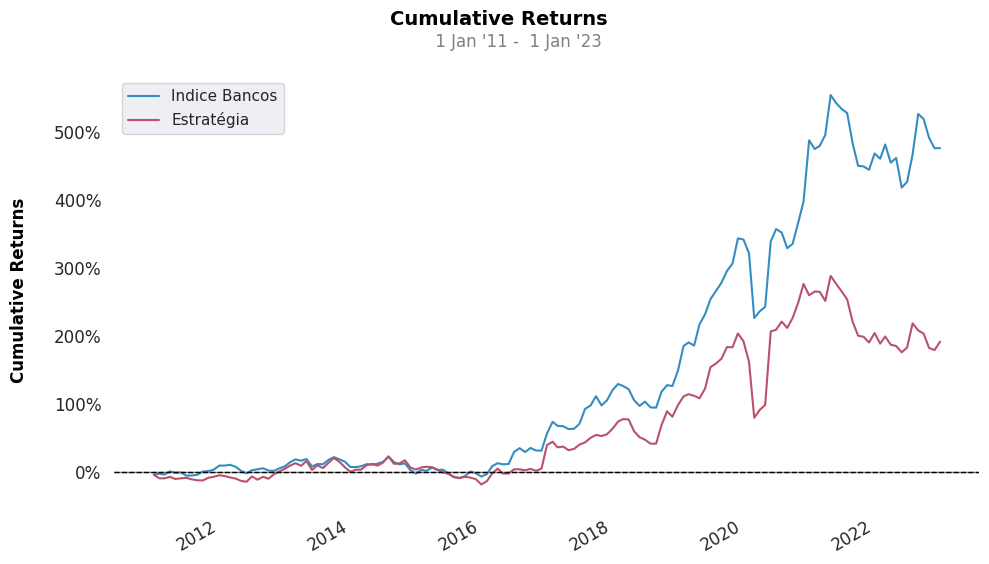

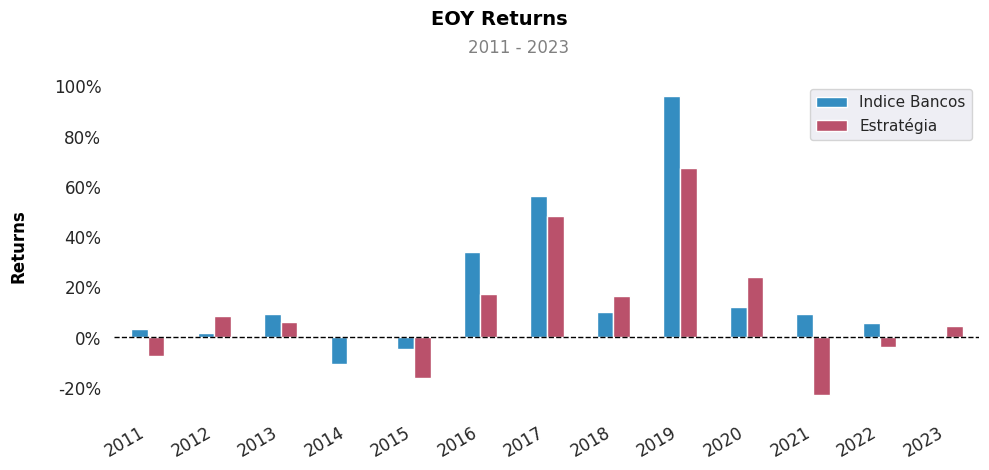

In [35]:
# BANCOS

#BMGB4 - 2019
#BPAC3 - 2017
#BPAN4 - 2014
#BSLI3 - 2017

tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

year_bancos = ['2011','2012','2013','2014','2015','2016',
               '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_bancos,year_bancos,periodo = 'quarter',weights ='equal')
benchmark_returns.columns = ['Indice Bancos']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_bancos,ratio2,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'quarter',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
weighted
2011-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.05775728407017749, 0.026878045816487905, 0.2, 0.2, 0.02613992879104795, 0.02609805543048005, 0.026127208575192882, 0.19539379593608378, 0.026165899231752044, 0.02610892326490122, 0.026154239033884898, 0.10827620699851417, 0.026116873399810638, 0.02878353945166687]
2011-04-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.06317282860854807, 0.02836509477887889, 0.2, 0.2, 0.027778487958498355, 0.02794590365574467, 0.02777728875743476, 0.027808123327731943, 0.15881215338554525, 0.02794338133187141, 0.02780435

['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.08811968697403004, 0.03900907968188896, 0.2, 0.2, 0.03890540260349334, 0.03898456145388999, 0.03890337459577742, 0.03895152022282472, 0.06141278564614301, 0.039044922996154106, 0.03900662785908906, 0.03890038220442688, 0.059247534230167764, 0.03895163697629138, 0.04056248455582337]
2017-07-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BRSR3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.0717714432937157, 0.04113035396490279, 0.19999999999999998, 0.19999999999999998, 0.04107702142960969, 0.04129162691401737, 0.04107397683748622, 0.04111783241313832, 0.04107393741778622, 0.057806510228702514, 0.041136846621373256, 0.041101832652550394, 0.05807340478575625, 0.04107620984755088, 0.042269003593410494]
2017-10-01 00

2021-07-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BBAS3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BRSR3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.045223042822776845, 0.02123724929396582, 0.2, 0.2, 0.021190823917918683, 0.021209956326886804, 0.07624530686700473, 0.021194494216781955, 0.021184888966565306, 0.022467097722559046, 0.2, 0.021230142970634802, 0.02159818804600933, 0.02122940110171563, 0.04129441739270221, 0.021261379556705207, 0.02343361079777365]
2021-10-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BBAS3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BRSR3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.05094837746500666, 0.019469609729036996, 0.2, 0.2, 0.019443274397799172, 0.019502490391138026, 0.06356966196462747, 0.019439924728475062, 0.019440964281023924, 0.020155252387930582, 0.2, 0.01944496848343435, 0.01966473759265294, 

2017-07-01
['BPAN4.SA', 'ABCB4.SA', 'SANB4.SA', 'BRIV3.SA', 'BSLI3.SA', 'BBAS3.SA']
[0.2059001821050259, 0.20060625347608832, 0.15726287436273523, 0.15036674109528717, 0.14728749374527444, 0.138576455215589]
2017-10-01
['BAZA3.SA', 'BRIV3.SA', 'BMEB3.SA', 'SANB4.SA', 'BPAN4.SA', 'BRSR3.SA']
[0.18168078572167182, 0.17596035529991105, 0.16905541532211407, 0.16281166419397597, 0.1567885530051479, 0.1537032264571793]
2018-01-01
['BNBR3.SA', 'BSLI3.SA', 'ITUB3.SA', 'SANB4.SA', 'BRSR3.SA', 'BBAS3.SA']
[0.19800258456227057, 0.16595762898872604, 0.16469964069039808, 0.16318890995490806, 0.15448431885850225, 0.15366691694519496]
2018-04-01
['BMEB3.SA', 'BPAN4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BBDC3.SA', 'ITUB3.SA']
[0.2156891436014179, 0.17688499200353508, 0.16618256814266152, 0.1507994506847331, 0.14846651914968778, 0.14197732641796462]
2018-07-01
['BMEB3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BMIN3.SA', 'SANB4.SA', 'BRSR3.SA']
[0.18706446840616342, 0.17289599312345352, 0.17033637919649214, 0.1683136645967

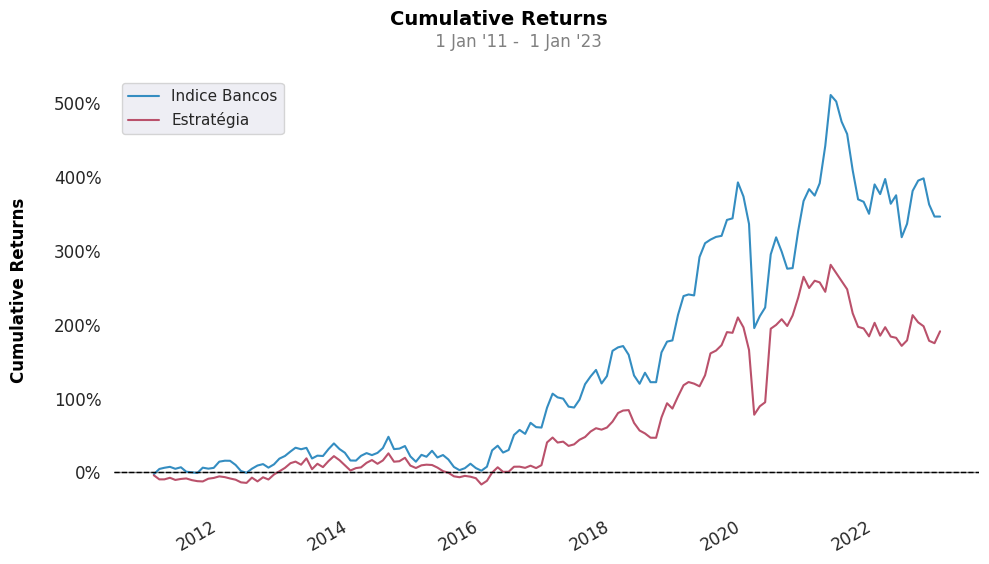

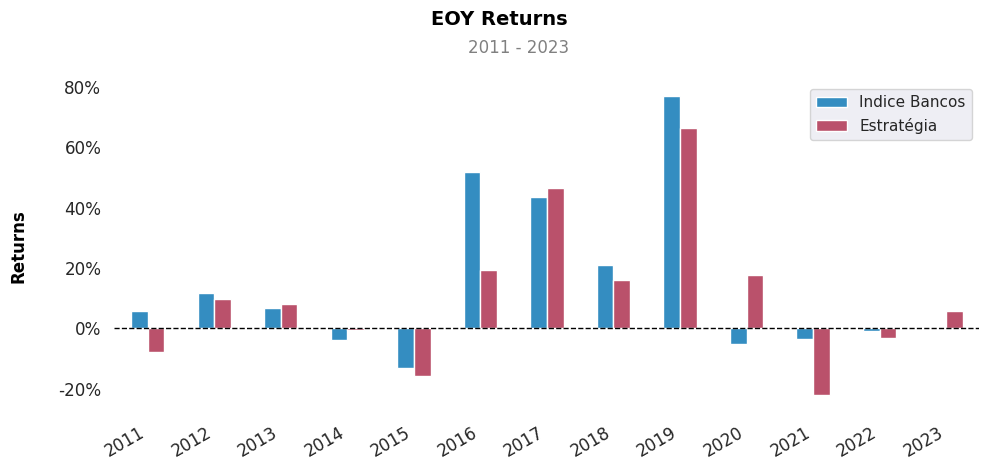

In [36]:
# BANCOS

tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

year_bancos = ['2011','2012','2013','2014','2015','2016',
               '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_bancos,year_bancos,periodo = 'quarter',weights ='weighted')
benchmark_returns.columns = ['Indice Bancos']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_bancos,ratio2,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'quarter',qtd = 6,weights = 'weighted')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
equal
2011-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
2012-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
2013-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3

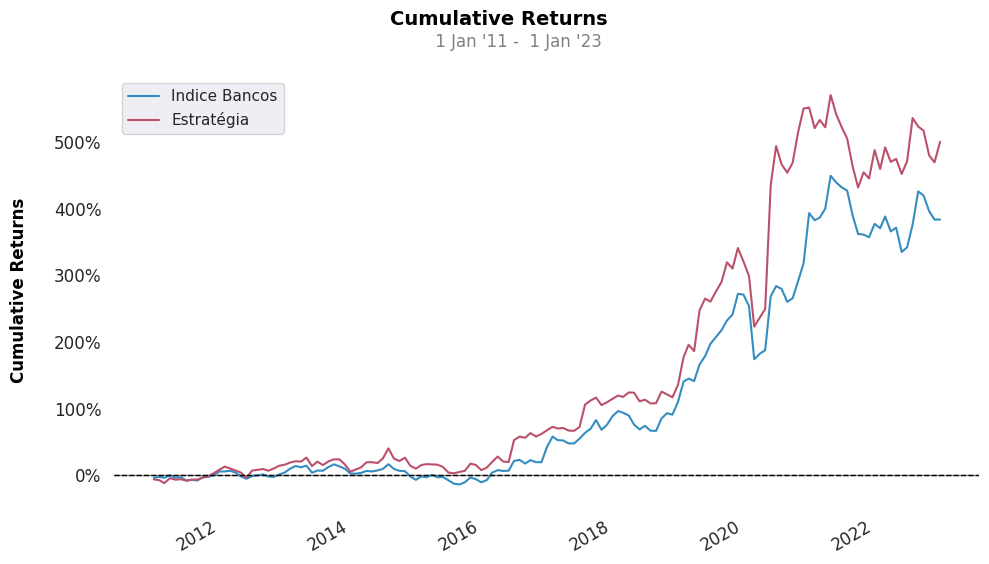

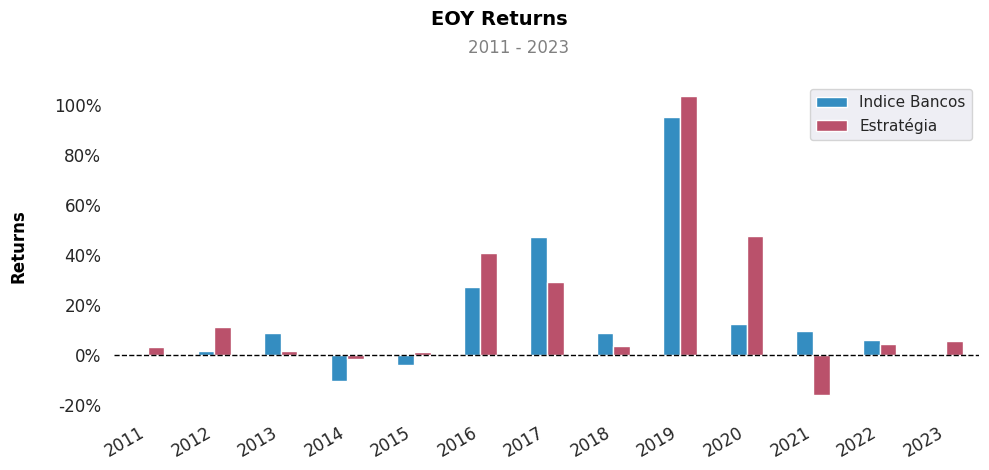

In [37]:
# BANCOS

tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

year_bancos = ['2011','2012','2013','2014','2015','2016',
               '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_bancos,year_bancos,periodo = 'annual',weights ='equal')
benchmark_returns.columns = ['Indice Bancos']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_bancos,ratio2,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'annual',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
weighted
2011-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.05775728407017749, 0.026878045816487905, 0.2, 0.2, 0.02613992879104795, 0.02609805543048005, 0.026127208575192882, 0.19539379593608378, 0.026165899231752044, 0.02610892326490122, 0.026154239033884898, 0.10827620699851417, 0.026116873399810638, 0.02878353945166687]
2012-01-01 00:00:00
['RPAD3.SA', 'BMGB4.SA', 'ABCB4.SA', 'BRIV3.SA', 'BAZA3.SA', 'BBDC3.SA', 'BPAC3.SA', 'BGIP3.SA', 'BMIN3.SA', 'BMEB3.SA', 'BNBR3.SA', 'BPAN4.SA', 'SANB4.SA', 'BSLI3.SA', 'ITUB3.SA']
[0.059187667948027885, 0.037261716250901515, 0.2, 0.2, 0.0370776050477348, 0.03801635651388133, 0.037076545807716584, 0.037083515497836464, 0.0764127151742987, 0.03733699600219633, 0.03710317

                           Indice Bancos    Estratégia
-------------------------  ---------------  ------------
Start Period               2011-01-01       2011-01-01
End Period                 2022-12-01       2022-12-01
Risk-Free Rate             0.0%             0.0%
Time in Market             100.0%           100.0%

Cumulative Return          284.46%          486.94%
CAGR﹪                     8.11%            10.79%

Sharpe                     2.67             3.02
Prob. Sharpe Ratio         97.44%           99.84%
Smart Sharpe               2.32             2.63
Sortino                    4.27             7.01
Smart Sortino              3.72             6.1
Sortino/√2                 3.02             4.95
Smart Sortino/√2           2.63             4.32
Omega                      1.56             1.56

Max Drawdown               -40.07%          -25.54%
Longest DD Days            670              640
Volatility (ann.)          112.85%          126.21%
Calmar                     0

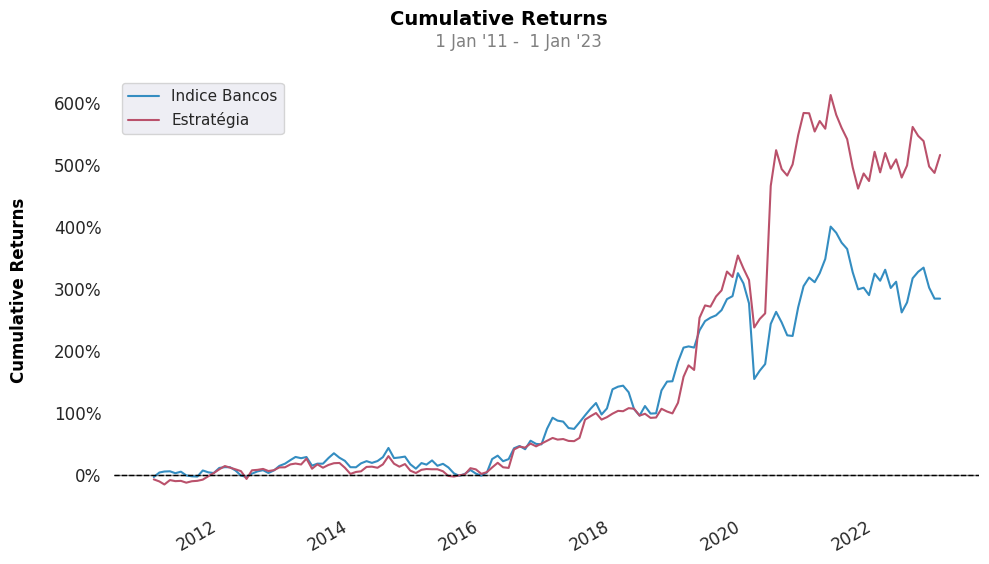

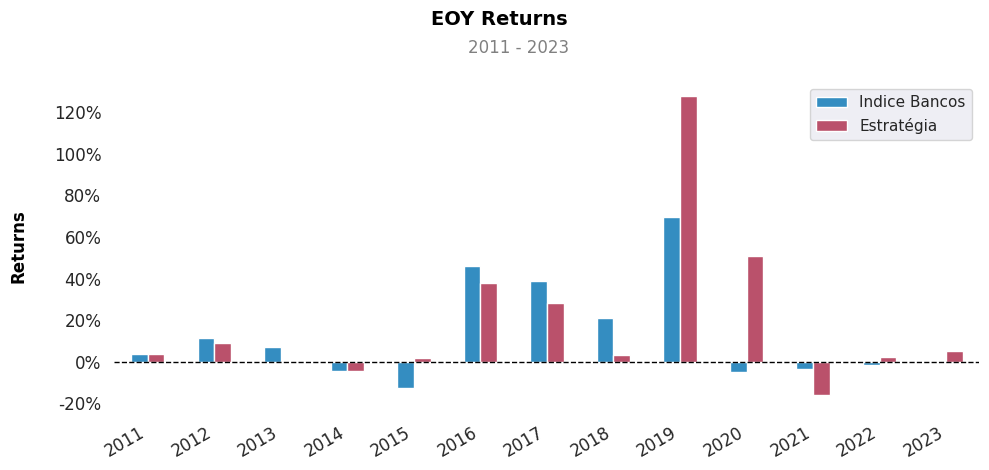

In [34]:
# BANCOS

tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

year_bancos = ['2011','2012','2013','2014','2015','2016',
               '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']
    
# retorno do benchmark
benchmark_returns = Benchmark(tickers_bancos,year_bancos,periodo = 'annual',weights ='weighted')
benchmark_returns.columns = ['Indice Bancos']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_bancos,ratio2,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'annual',qtd = 6,weights = 'weighted')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

In [175]:
# retorno do CEBR3
teste = ['EGIE3.SA', 'CBEE3.SA', 'COCE3.SA', 'CEBR3.SA', 'CLSC3.SA', 'CMIG3.SA', 'ENGI3.SA', 'EQPA3.SA', 'EKTR3.SA', 'TAEE11.SA']
cebr = yf.download(tickers=teste, start='2011-12-30',
                    end='2012-12-31', interval='1mo')[['Adj Close']]

retorno_cebr = cebr.pct_change().fillna(0)
#retorno_cebr.idxmin()
#sorted(retorno_cebr['Adj Close'])
cebr.tail(20)

[*********************100%***********************]  10 of 10 completed


Adj Close                                                       \
             CBEE3.SA  CEBR3.SA   CLSC3.SA  CMIG3.SA   COCE3.SA   EGIE3.SA   
Date                                                                         
2012-01-01  52.952694 -0.556875  56.311512  5.613413  20.502417  11.253484   
2012-02-01  50.165718 -0.556875  59.656948  6.378879  21.675217  11.268320   
2012-03-01  50.165718 -0.522650  59.656948  7.209085  23.443615  12.136257   
2012-04-01  41.804764 -0.557140  59.656948  7.695118  19.943653  12.184474   
2012-05-01  40.411434 -0.557140  59.656948  7.230430  21.763361  12.557362   
2012-06-01  40.411434 -0.424488  59.811245  7.786242  21.804173  13.946370   
2012-07-01  40.411434 -0.556875  59.811245  8.116793  23.769672  13.721128   
2012-08-01  37.903133 -0.464283  59.811245  7.343062  26.864153  12.673738   
2012-09-01  40.690132 -0.464283  20.914640  5.484649  25.163889  12.371200   
2012-10-01  38.739231 -0.400610  20.966089  5.411192  25.163889  13.531001   
2012-11-01  36.509640 -0.424488  22.509607  5.643801  23.620050  13.473011   
2012-12-01  31.493042 -0.424488  23.795866  5.362223  30.543520  13.056025   

                                                    
            EKTR3.SA  ENGI3.SA  EQPA3.SA TAEE11.SA  
Date                                                
2012-01-01  7.562770  1.424664  0.286638  4.592381  
2012-02-01  7.562770  1.313168  0.286638  5.260960  
2012-03-01  7.562770  1.319362  0.286638  6.543321  
2012-04-01  7.562770  1.350686  0.286638  7.177925  
2012-05-01  7.820398  1.350686  0.286638  6.259550  
2012-06-01  7.820398  1.338062  0.286638  7.568366  
2012-07-01  7.820398  1.293881  0.286638  8.080506  
2012-08-01  7.820398  1.325439  0.286638  8.365035  
2012-09-01  7.952329  1.427552  0.286638  8.365035  
2012-10-01  7.936463  1.492440  0.286638  7.625265  
2012-11-01  7.936463  1.589774  0.286638  7.625265  
2012-12-01  7.936463  1.576796  5.993114  7.443175

In [176]:
retorno_acumulado_cebr = (1 + retorno_cebr).cumprod() - 1
retorno_acumulado_cebr.tail(1)

Adj Close                                                    \
            CBEE3.SA  CEBR3.SA  CLSC3.SA  CMIG3.SA  COCE3.SA  EGIE3.SA   
Date                                                                     
2012-12-01 -0.405261 -0.237732 -0.577424 -0.044748  0.489752  0.160176   

                                                   
            EKTR3.SA  ENGI3.SA EQPA3.SA TAEE11.SA  
Date                                               
2012-12-01  0.049412  0.106785  19.9083  0.620766

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
equal
2011-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
2011-04-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'CEEB3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04545455 0.04545455 0.04545455 0.04545455 0.0454545

['AESB3.SA', 'TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'CEEB3.SA', 'REDE3.SA', 'EQMA3B.SA', 'NEOE3.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
2020-07-01 00:00:00
['AESB3.SA', 'TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'CEEB3.SA', 'REDE3.SA', 'EQMA3B.SA', 'NEOE3.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.0416

['REDE3.SA', 'CPLE3.SA', 'LIGT3.SA', 'ENMT3.SA', 'NEOE3.SA', 'ELET3.SA', 'CSRN3.SA', 'CLSC3.SA', 'ALUP11.SA', 'CMIG3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2019-07-01
['ELET3.SA', 'TRPL3.SA', 'COCE3.SA', 'NEOE3.SA', 'EQMA3B.SA', 'CEEB3.SA', 'CBEE3.SA', 'CSRN3.SA', 'TAEE11.SA', 'EQTL3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2019-10-01
['EQTL3.SA', 'REDE3.SA', 'LIGT3.SA', 'CPLE3.SA', 'ENMT3.SA', 'CBEE3.SA', 'EQMA3B.SA', 'ELET3.SA', 'ENEV3.SA', 'CLSC3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2020-01-01
['ELET3.SA', 'COCE3.SA', 'CPFE3.SA', 'CSRN3.SA', 'CMIG3.SA', 'ENEV3.SA', 'CPLE3.SA', 'NEOE3.SA', 'EQTL3.SA', 'TRPL3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2020-04-01
['CLSC3.SA', 'CPLE3.SA', 'EKTR3.SA', 'GEPA3.SA', 'ENGI3.SA', 'EGIE3.SA', 'ALUP11.SA', 'TAEE11.SA', 'LIGT3.SA', 'CPFE3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2020-07-01
['TRPL3.SA', 'ENMT3.SA', 'CPLE3.SA', 'EGIE3.SA', 'CBEE3.SA', 'CLSC3.SA', 'TAEE11.SA', 'CMIG3.SA', 'GEPA3.SA', 'ALUP11.SA']
[

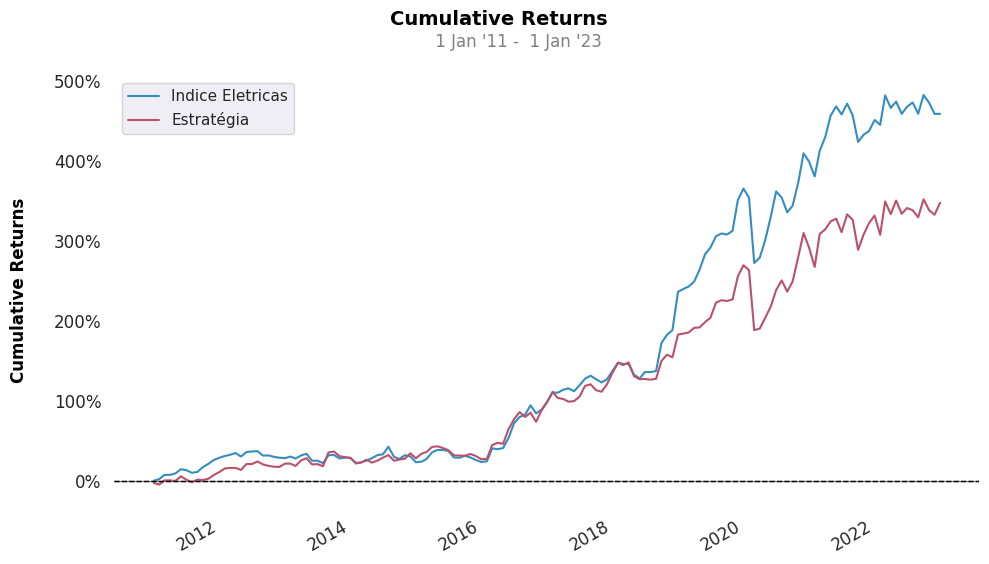

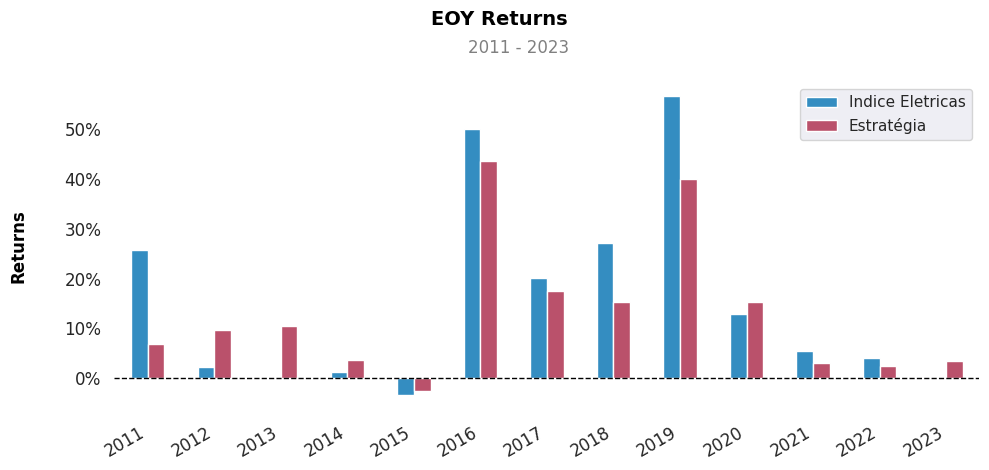

In [18]:
# ELÉTRICAS

# AESB3 - 2021
# ALUP11 - 2013
# CBEE3 - 2019
# CLSC3 - 2015
# ENMT3 - 2015
# ENEV3 - 2013
# EQPA3 - 2013
# NEOE3 - 2019

tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

year_elet = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_elet,year_elet,periodo = 'quarter',weights ='equal')
benchmark_returns.columns = ['Indice Eletricas']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_elet,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'quarter',qtd = 10,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
equal
2011-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
2012-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'CEEB3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.04545455 0.04545455 0.04545455 0.04545455 0.0454545


1 Failed download:
['EGIE3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2010-11-30 -> 2022-12-31)')



[*********************100%***********************]  25 of 25 completed
Performance Metrics

                           Indice Eletricas    Estratégia
-------------------------  ------------------  ------------
Start Period               2011-01-01          2011-01-01
End Period                 2022-12-01          2022-12-01
Risk-Free Rate             0.0%                0.0%
Time in Market             100.0%              100.0%

Cumulative Return          446.61%             451.57%
CAGR﹪                     10.34%              10.39%

Sharpe                     4.68                4.5
Prob. Sharpe Ratio         99.97%              99.96%
Smart Sharpe               4.12                3.97
Sortino                    8.46                8.13
Smart Sortino              7.45                7.16
Sortino/√2                 5.98                5.75
Smart Sortino/√2           5.27                5.07
Omega                      2.3                 2.3

Max Drawdown               -20.0%       

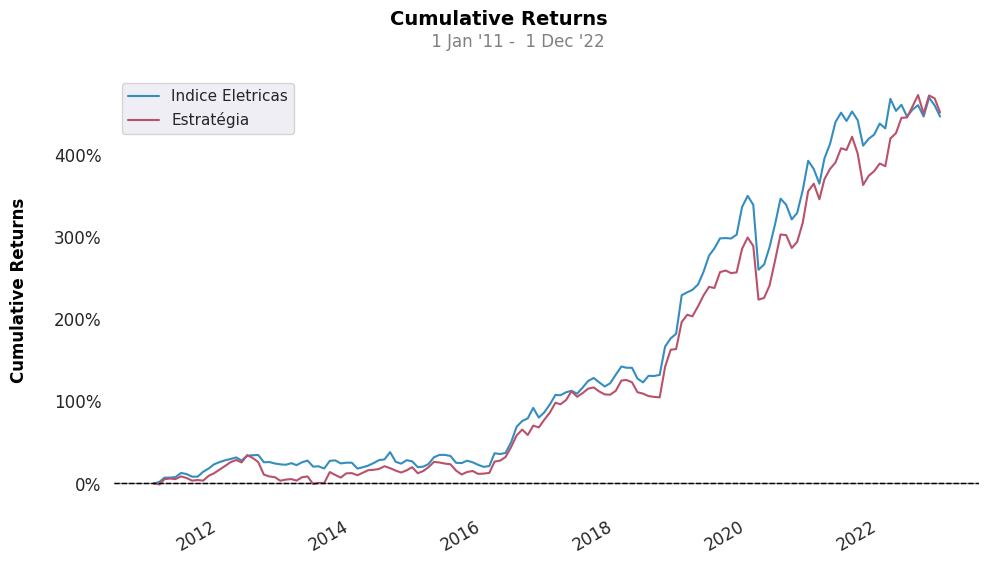

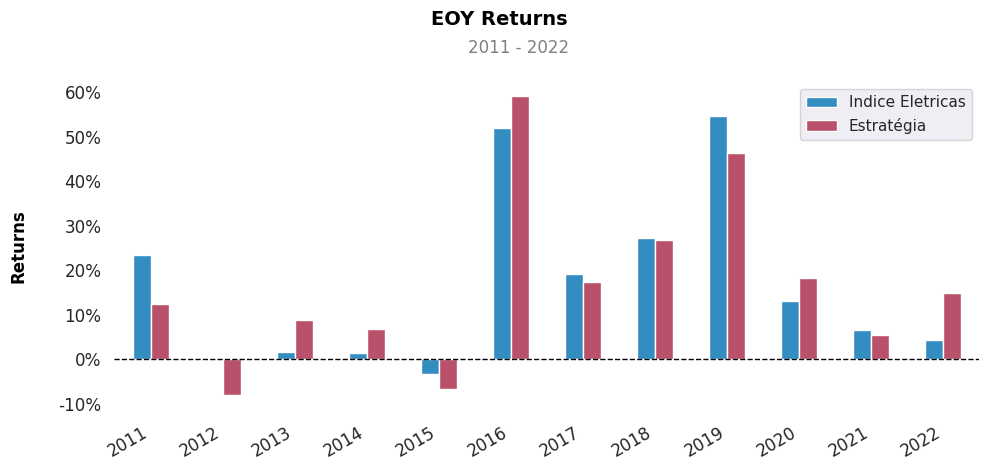

In [71]:
# ELÉTRICAS

tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

year_elet = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_elet,year_elet,periodo = 'annual',weights ='equal')
benchmark_returns.columns = ['Indice Eletricas']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_elet,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'annual',qtd = 10,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
weighted
2011-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.035627813728516575, 0.0011340041950031552, 0.0010641325965344208, 0.0432376070423511, 0.003047250770993981, 0.11746497937804949, 0.0531612636560706, 0.0010999361342879535, 0.13585562567198603, 0.0010631380538190449, 0.2, 0.031087800823529205, 0.001199355596830506, 0.0011103788327994004, 0.0015494694416378638, 0.1641152884028593, 0.2, 0.0010894934357765064, 0.0011676744386322066, 0.004732006130840769, 0.0011927816694818714]
2012-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'CO

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
Performance Metrics

                           Indice Eletricas    Estratégia
-------------------------  ------------------  ------------
Start Period               2011-01-01          2011-01-01
End Period                 2022-12-01          2022-12-01
Risk-Free Rate             0.0%                0.0%
Time in Market             100.0%              100.0%

Cumulative Return          459.45%             453.51%
CAGR﹪                     10.48%              10.42%

Sharpe                     3.39                4.25
Prob. Sharpe Ratio         99.48%              99.91%
Smart Sharpe               3.08                3.87
Sortino                    5.96                7.5
Smart Sortino              5.43                6.83
Sortino/√2                 4.21                5.31
Smart Sortino/√2           3.84                4.83
Omega                 

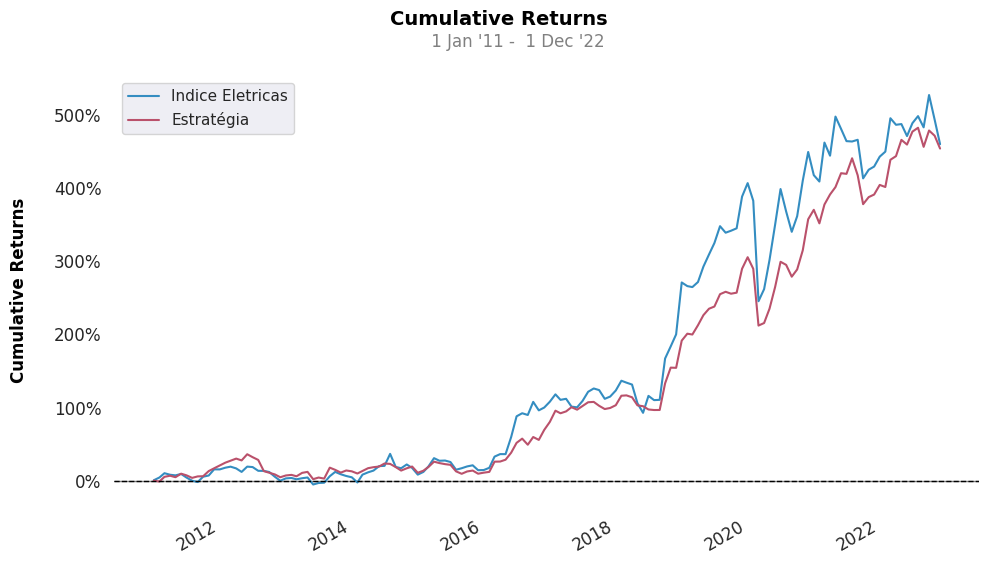

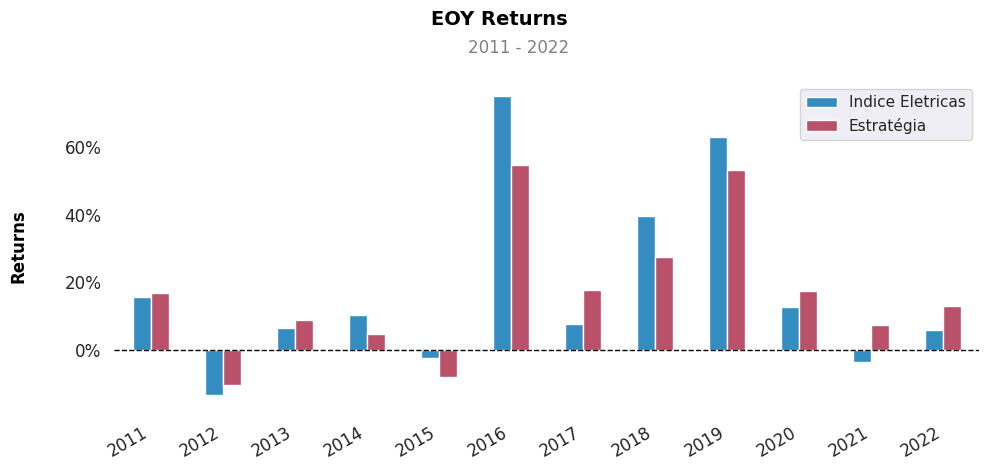

In [66]:
# ELÉTRICAS
# adicionando CEBR3.SA está fazendo aumentar bastante a rentabilidade em 2012
# aumento se deve a EQPA3.SA que tem um outline no último mês de 2012

tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

year_elet = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_elet,year_elet,periodo = 'annual',weights ='weighted')
benchmark_returns.columns = ['Indice Eletricas']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_elet,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'annual',qtd = 10,weights = 'weighted')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
weighted
2011-01-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'REDE3.SA', 'EQMA3B.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.035627813728516575, 0.0011340041950031552, 0.0010641325965344208, 0.0432376070423511, 0.003047250770993981, 0.11746497937804949, 0.0531612636560706, 0.0010999361342879535, 0.13585562567198603, 0.0010631380538190449, 0.2, 0.031087800823529205, 0.001199355596830506, 0.0011103788327994004, 0.0015494694416378638, 0.1641152884028593, 0.2, 0.0010894934357765064, 0.0011676744386322066, 0.004732006130840769, 0.0011927816694818714]
2011-04-01 00:00:00
['TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'CO

['ALUP11.SA', 'AESB3.SA', 'TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'ELET3.SA', 'ENMT3.SA', 'COCE3.SA', 'LIPR3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EGIE3.SA', 'ENEV3.SA', 'CEEB3.SA', 'REDE3.SA', 'EQMA3B.SA', 'NEOE3.SA', 'GEPA3.SA', 'LIGT3.SA', 'TAEE11.SA']
[0.00833413668634478, 0.018355655734810333, 0.001026353446636663, 0.0009936771785731661, 0.0009637034589961237, 0.029491790847945544, 0.0009644405176742477, 0.06307118520165804, 0.053226108173286324, 0.0009965332809508964, 0.04261878962862139, 0.0009666209829303644, 0.1963308414124674, 0.18976890013346426, 0.0015332655525164393, 0.00111068524372535, 0.0009736844619290527, 0.19999999999999998, 0.0009801644361408927, 0.07770254224192973, 0.0009708283595513223, 0.055535098036401005, 0.0013904297228516606, 0.05160037170479258, 0.0010941935558023256]
2021-07-01 00:00:00
['ALUP11.SA', 'AESB3.SA', 'TRPL3.SA', 'CBEE3.SA', 'CMIG3.SA', 'CLSC3.SA', 'CPLE3.SA', 'CSRN3.SA', 'CPFE3.SA', 'EKTR3.SA', 'E

2018-07-01
['CPLE3.SA', 'CPFE3.SA', 'CBEE3.SA', 'ELET3.SA', 'EQMA3B.SA', 'ENEV3.SA', 'TRPL3.SA', 'ALUP11.SA', 'CSRN3.SA', 'EGIE3.SA']
[0.14053255856902278, 0.09880338031883745, 0.09781719778795098, 0.09614224981835942, 0.09612916905699662, 0.09566445088611183, 0.09477442695523858, 0.09423430879684214, 0.09377480907607588, 0.09212744873456453]
2018-10-01
['EQMA3B.SA', 'ALUP11.SA', 'CMIG3.SA', 'CPLE3.SA', 'CPFE3.SA', 'TRPL3.SA', 'ENGI3.SA', 'EQTL3.SA', 'EKTR3.SA', 'CEEB3.SA']
[0.12860973224066885, 0.11946745462610946, 0.10364779092132903, 0.1027845197278383, 0.1009690292042092, 0.09746113105495037, 0.09642936044705576, 0.08558660393783818, 0.08469171516761684, 0.08035266267238393]
2019-01-01
['CPFE3.SA', 'EQMA3B.SA', 'EKTR3.SA', 'ENEV3.SA', 'CBEE3.SA', 'REDE3.SA', 'TRPL3.SA', 'CMIG3.SA', 'EGIE3.SA', 'ELET3.SA']
[0.1265591566737034, 0.12000448761350425, 0.10787236386066375, 0.10155649882375016, 0.09612515121727466, 0.09575119614079741, 0.09324592218584533, 0.0927593438197924, 0.0847470861

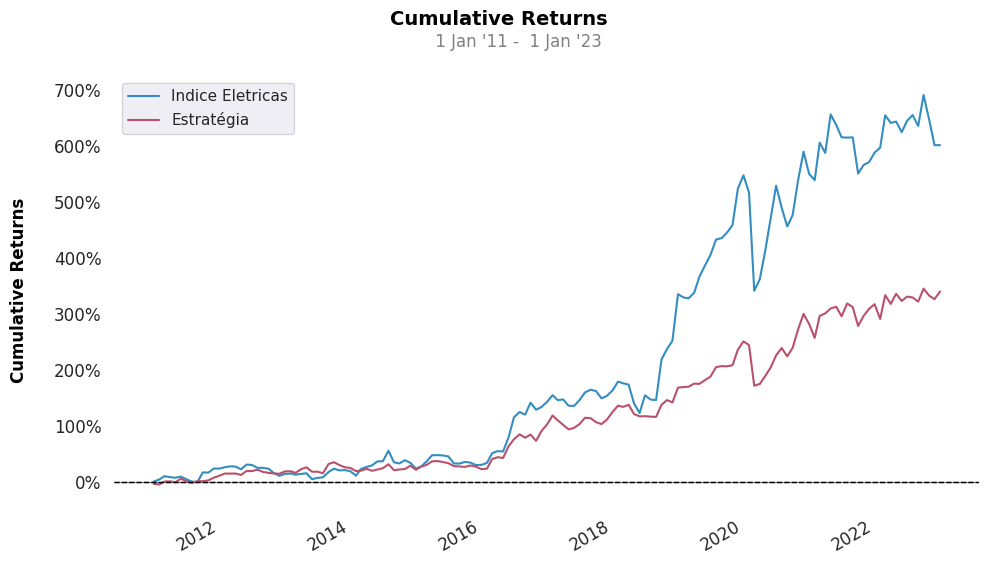

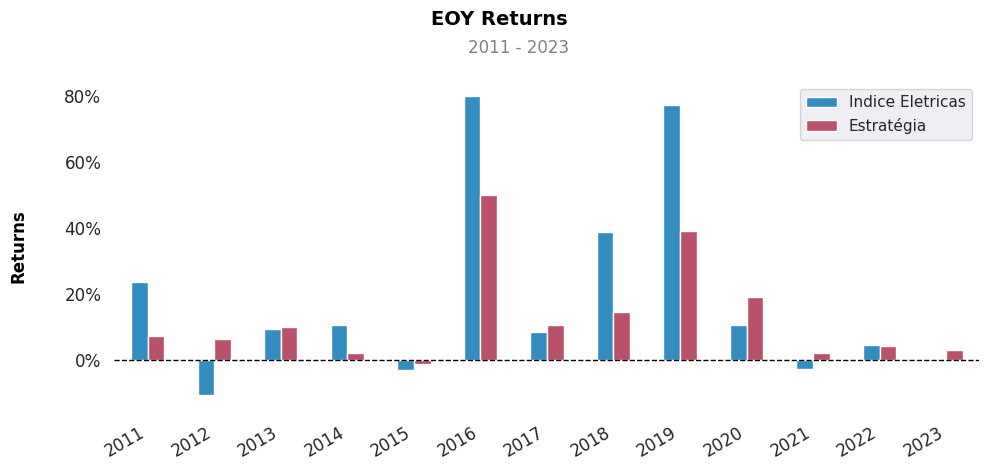

In [16]:
# ELÉTRICAS

tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

year_elet = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_elet,year_elet,periodo = 'quarter',weights ='weighted')
benchmark_returns.columns = ['Indice Eletricas']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_elet,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'quarter',qtd = 10,weights = 'weighted')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
equal
2011-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
2012-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'VIIA3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
2013-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'VIIA3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
2014-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'VIIA3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.111111

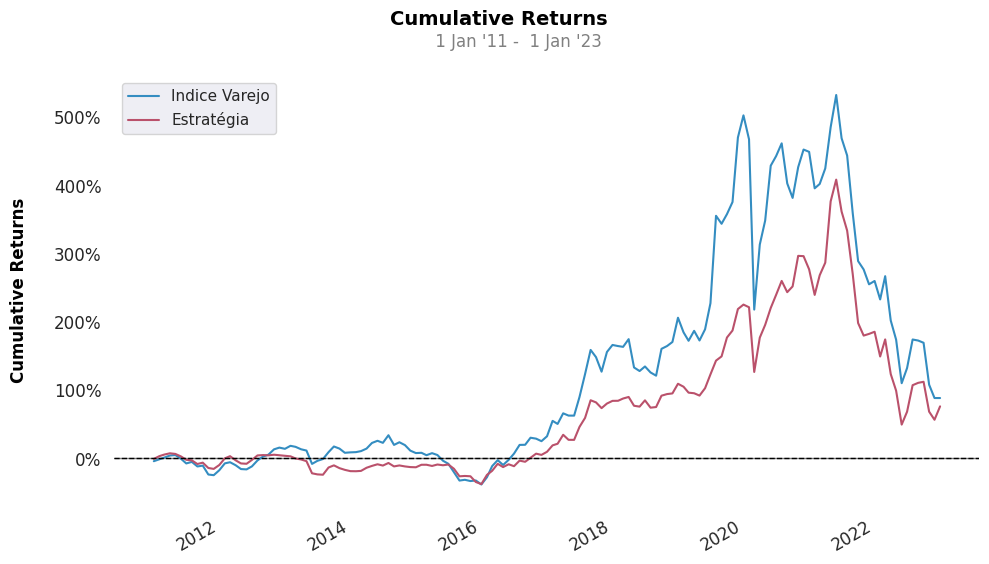

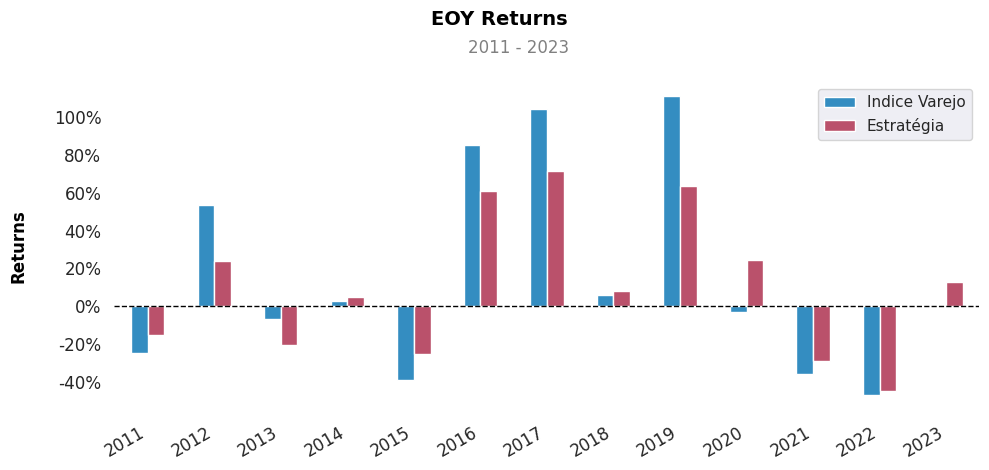

In [25]:
# Varejo

tickers_var = ["ARZZ3.SA","CEAB3.SA","CGRA3.SA","SOMA3.SA",
               "GUAR3.SA","AMAR3.SA","LREN3.SA","MGLU3.SA",
               "VIIA3.SA","AMER3.SA","ESPA3.SA","SBFG3.SA",
               "PETZ3.SA","SLED3.SA"]

year_var = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_var,year_var,periodo = 'annual',weights ='equal')
benchmark_returns.columns = ['Indice Varejo']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_var,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_var,periodo = 'annual',qtd = 6,weights = 'equal')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  14 of 14 completed
weighted
2011-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.14551469558509883, 0.2, 0.10219103487274551, 0.14536140818348378, 0.2, 0.10216784764308637, 0.10476501371558548]
2012-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'VIIA3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.08569242070621967, 0.12008624184268746, 0.08060369719753324, 0.07781751264462534, 0.08022313894130965, 0.2, 0.2, 0.07775331330832974, 0.07782367535929503]
2013-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA', 'GUAR3.SA', 'LREN3.SA', 'MGLU3.SA', 'VIIA3.SA', 'SBFG3.SA', 'SLED3.SA']
[0.08711210651577014, 0.13274715529283923, 0.0810956081885727, 0.07215890203809296, 0.08256791546185074, 0.2, 0.2, 0.07204247793205491, 0.07227583457081932]
2014-01-01 00:00:00
['ARZZ3.SA', 'CEAB3.SA', 'CGRA3.SA'


1 Failed download:
['CEAB3.SA']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2010-11-30 -> 2023-01-31)')



weighted
2011-01-01
['AMER3.SA', 'GUAR3.SA', 'VIIA3.SA', 'ARZZ3.SA', 'SLED3.SA', 'AMAR3.SA']
[0.19956487374746643, 0.19621992495470808, 0.17347320808707203, 0.15656546404853094, 0.15544889652985533, 0.11872763263236723]
2012-01-01
['AMAR3.SA', 'SLED3.SA', 'GUAR3.SA', 'AMER3.SA', 'VIIA3.SA', 'MGLU3.SA']
[0.20201990768585293, 0.1770095608946396, 0.17544045654483556, 0.16184061747671208, 0.1517680252359436, 0.13192143216201627]
2013-01-01
['VIIA3.SA', 'CGRA3.SA', 'LREN3.SA', 'GUAR3.SA', 'ARZZ3.SA', 'MGLU3.SA']
[0.1864286203726367, 0.17978962398378426, 0.1751964691197588, 0.17430929717094604, 0.17247377251613172, 0.11180221683674257]
2014-01-01
['MGLU3.SA', 'LREN3.SA', 'AMER3.SA', 'GUAR3.SA', 'VIIA3.SA', 'AMAR3.SA']
[0.226367376147789, 0.16455939792903182, 0.16050109988929614, 0.16039178576109364, 0.150730290898489, 0.1374500493743004]
2015-01-01
['AMAR3.SA', 'SLED3.SA', 'LREN3.SA', 'AMER3.SA', 'MGLU3.SA', 'GUAR3.SA']
[0.20397045090537422, 0.19028988853621365, 0.18811102111809488, 0.17182

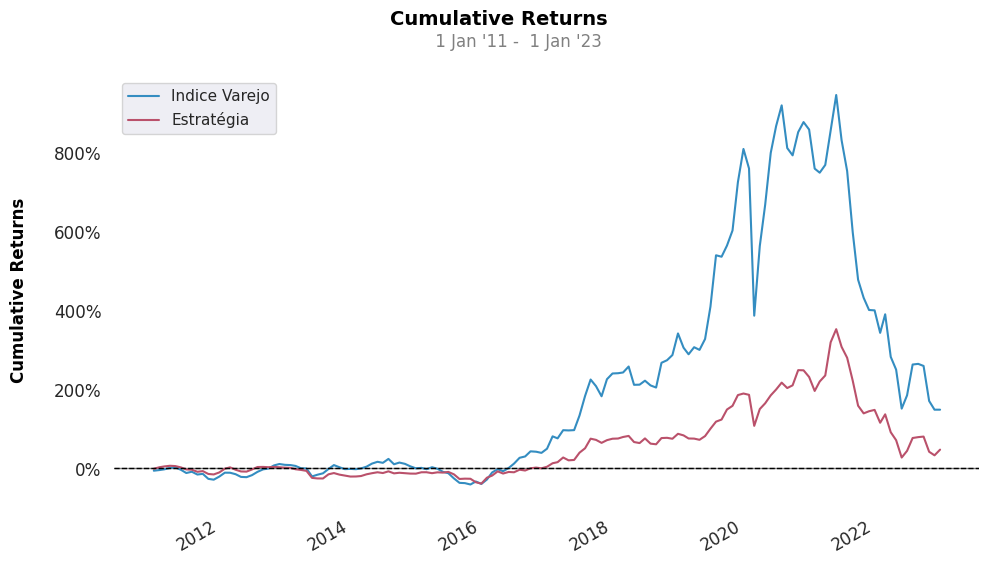

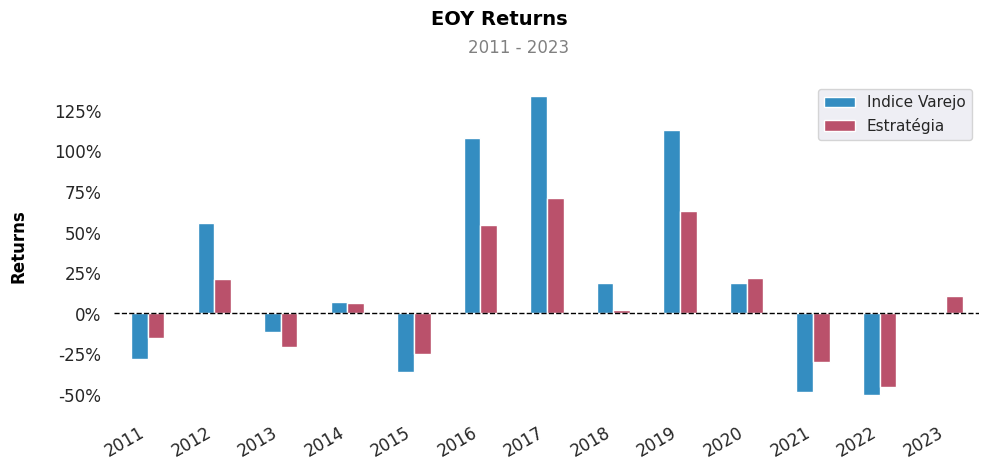

In [26]:
# Varejo

tickers_var = ["ARZZ3.SA","CEAB3.SA","CGRA3.SA","SOMA3.SA",
               "GUAR3.SA","AMAR3.SA","LREN3.SA","MGLU3.SA",
               "VIIA3.SA","AMER3.SA","ESPA3.SA","SBFG3.SA",
               "PETZ3.SA","SLED3.SA"]

year_var = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

ratio2 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','evToFreeCashFlow',
        'pocfratio','pfcfRatio']

ratio3 = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark
benchmark_returns = Benchmark(tickers_var,year_var,periodo = 'annual',weights ='weighted')
benchmark_returns.columns = ['Indice Varejo']

# retorno da estratégia
estrategia = Estrategia_Quantamental(tickers_var,ratio3,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_var,periodo = 'annual',qtd = 6,weights = 'weighted')[0]
estrategia.columns = ['Estratégia']

print("\033[1mPerformance Metrics\033[0m\n")
df = pd.concat([benchmark_returns,estrategia],axis = 1)
qs.reports.metrics(df,mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(df)
qs.plots.yearly_returns(df)

### Criando um Otimizador para encontrar os melhores parâmetros que resultam em um melhor retorno acumulado

In [56]:
def otimizador(all_ratio,ticker,periodo = 'annual',qtd = 6,weights = 'weighted'):
    ratio_otimizada = []
    retorno_otimizado = 0
    # iterando sobre cada possibilidade de ratio
    step = 1
    
    for ratio in all_ratio:
        print(step)
        # gerando a carteira com essa estratégia
        year = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
        f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                             'researchAndDdevelopementToRevenue', 'currentRatio']
        f_score_ratio_min = ['averagePayables',
                             'daysOfInventoryOnHand', 'interestDebtPerShare']
        g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                             "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']
        estrategia = Estrategia_Quantamental(ticker,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = periodo,qtd = qtd,weights = weights)[0]
        estrategia.columns = ['retorno']
        
        # calculando o retorno acumulado
        retorno_acumulado = (1 + estrategia['retorno']).cumprod() - 1
        retorno_acumulado = float(retorno_acumulado.iloc[-1])
        print(retorno_acumulado)
        if retorno_acumulado > retorno_otimizado:
            retorno_otimizado = retorno_acumulado
            ratio_otimizada = ratio
        
        step += 1
    
    print(len(ratio_otimizada))
    return ratio_otimizada,retorno_otimizado

In [59]:
# verificando se está sendo usada GPU
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

2023-09-18 15:37:19.736851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:37:19.776318: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:37:19.777080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 15:37:21.060158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13740975707864265802
 xla_global_id: -1]

In [55]:
# testando otimizador
all_ratio = [['peRatio', 'priceToSalesRatio'],
            ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales','pocfratio',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA','pfcfRatio',
        'evToFreeCashFlow','enterpriseValueOverEBITDA','evToOperatingCashFlow']]

tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

otimizador(all_ratio,tickers_elet,periodo = 'annual',qtd = 10,weights = 'weighted')

1
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
3.499244119854957
2
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
4.535063243071432


(['peRatio',
  'priceToSalesRatio',
  'pbRatio',
  'evToSales',
  'pocfratio',
  'debtToEquity',
  'debtToAssets',
  'netDebtToEBITDA',
  'pfcfRatio',
  'evToFreeCashFlow',
  'enterpriseValueOverEBITDA',
  'evToOperatingCashFlow'],
 4.535063243071432)

In [31]:
# Lista de métricas
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales', 'pocfratio',
           'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'pfcfRatio',
           'evToFreeCashFlow', 'enterpriseValueOverEBITDA', 'evToOperatingCashFlow']

# Gere todas as combinações de ratio de 2 até o número total de ratio
all_combinations = []
for comb in range(2, len(ratio) + 1):
    combinations = list(itertools.combinations(ratio, comb))
    all_combinations.extend(combinations)

len(all_combinations)

4083

In [ ]:
# Utilizando o otimizador para as ações bancárias
tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

otimizador(all_combinations,tickers_bancos,periodo = 'annual',qtd = 10,weights = 'weighted')

In [ ]:
# Utilizando o otimizador para as ações elétricas
tickers_elet = ["ALUP11.SA","AESB3.SA","TRPL3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"CEEB3.SA","REDE3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "TAEE11.SA"]

otimizador(all_combinations,tickers_elet,periodo = 'annual',qtd = 10,weights = 'weighted')

##### Comparações das ações bancárias em HTML

In [81]:
tickers_bancos = ["RPAD3.SA","BMGB4.SA","ABCB4.SA","BRIV3.SA","BAZA3.SA",
                  "BBDC3.SA","BBAS3.SA","BPAC3.SA","BGIP3.SA","BRSR3.SA",
                  "BMIN3.SA","BMEB3.SA","BNBR3.SA","BPAN4.SA","SANB4.SA",
                  "BSLI3.SA","ITUB3.SA"]

year_bancos = ['2011','2012','2013','2014','2015','2016',
               '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark    
benchmark_annual_wei = Benchmark(tickers_bancos,year_bancos,periodo = 'annual',weights ='weighted')
benchmark_annual_wei.columns = ['Benchmark Annual Ponderado']
benchmark_annual_eq = Benchmark(tickers_bancos,year_bancos,periodo = 'annual',weights ='equal')
benchmark_annual_eq.columns = ['Benchmark Annual Equal']
benchmark_quarter_wei = Benchmark(tickers_bancos,year_bancos,periodo = 'quarter',weights ='weighted')
benchmark_quarter_wei.columns = ['Benchmark Quarter Ponderado']
benchmark_quarter_eq = Benchmark(tickers_bancos,year_bancos,periodo = 'quarter',weights ='equal')
benchmark_quarter_eq.columns = ['Benchmark Quarter Equal']

# retorno da estratégia
estrategia_annual_wei = Estrategia_Quantamental(tickers_bancos,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'annual',qtd = 6,weights = 'weighted')[0]
estrategia_annual_wei.columns = ['Estrategia Annual Ponderado']
estrategia_annual_eq = Estrategia_Quantamental(tickers_bancos,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'annual',qtd = 6,weights = 'equal')[0]
estrategia_annual_eq.columns = ['Estrategia Annual Equal']
estrategia_quarter_wei = Estrategia_Quantamental(tickers_bancos,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'quarter',qtd = 6,weights = 'weighted')[0]
estrategia_quarter_wei.columns = ['Estrategia Quarter Ponderado']
estrategia_quarter_eq = Estrategia_Quantamental(tickers_bancos,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_bancos,periodo = 'quarter',qtd = 6,weights = 'equal')[0]
estrategia_quarter_eq.columns = ['Estrategia Quarter Equal']

# Comparações em HTML
retornos_bancos = pd.concat([benchmark_annual_wei['Benchmark Annual Ponderado'], benchmark_annual_eq['Benchmark Annual Equal'],
                benchmark_quarter_wei['Benchmark Quarter Ponderado'],benchmark_quarter_eq['Benchmark Quarter Equal'],
                estrategia_annual_wei['Estrategia Annual Ponderado'],estrategia_annual_eq['Estrategia Annual Equal'],
                estrategia_quarter_wei['Estrategia Quarter Ponderado'],estrategia_quarter_eq['Estrategia Quarter Equal']],axis=1)

qs.reports.html(retornos_bancos,title = 'Estratégia no setor bancário')

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  17 of 17 completed
weighted
2011-01-01
['BGIP3.SA', 'BPAC3.SA', 'BBAS3.SA', 'BBDC3.SA', 'ITUB3.SA', 'BSLI3.SA']
[0.27526287614741, 0.1768540043170451, 0.16950333528225844, 0.13597457279180095, 0.12645053808074322, 0.11595467338074233]
2012-01-01
['BNBR3.SA', 'RPAD3.SA', 'ITUB3.SA', 'BMEB3.SA', 'SANB4.SA', 'B

['BRIV3.SA', 'BRSR3.SA', 'BNBR3.SA', 'ITUB3.SA', 'SANB4.SA', 'ABCB4.SA']
[0.20229147479221657, 0.17007845510810835, 0.16182651094041842, 0.15927377678286073, 0.1537295713896596, 0.15280021098673635]
2015-01-01
['BAZA3.SA', 'ITUB3.SA', 'BSLI3.SA', 'BNBR3.SA', 'BGIP3.SA', 'SANB4.SA']
[0.1768934034889753, 0.17379140678213406, 0.16670960882609992, 0.16612469088221962, 0.15885266551337154, 0.15762822450719965]
2015-04-01
['BAZA3.SA', 'BMEB3.SA', 'SANB4.SA', 'BBAS3.SA', 'BBDC3.SA', 'BRIV3.SA']
[0.18331180329288227, 0.18155755757152536, 0.17748821785924687, 0.16203120280271063, 0.14975604209457988, 0.14585517637905496]
2015-07-01
['BPAN4.SA', 'BMEB3.SA', 'ABCB4.SA', 'BRIV3.SA', 'BRSR3.SA', 'BGIP3.SA']
[0.22510033192617285, 0.2078483735106341, 0.15750901639491358, 0.14944978873091083, 0.1309490450358935, 0.12914344440147532]
2015-10-01
['BRSR3.SA', 'BAZA3.SA', 'BPAN4.SA', 'BMEB3.SA', 'BRIV3.SA', 'BSLI3.SA']
[0.18821152890773812, 0.17533732064215954, 0.16897575118886765, 0.16860179987470603, 0.

#### Comparação das ações elétrica em HTML

In [78]:
tickers_elet = ["ALUP11.SA","AESB3.SA","CEBR3.SA","CBEE3.SA",
                "CMIG3.SA","CLSC3.SA","CPLE3.SA","CSRN3.SA",
                "CPFE3.SA","EKTR3.SA","ELET3.SA","ENMT3.SA",
                "COCE3.SA","LIPR3.SA","ENGI3.SA","EQTL3.SA",
                "EGIE3.SA",'ENEV3.SA',"EQPA3.SA","CEEB3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "REDE3.SA","TAEE11.SA","TRPL3.SA"]

year_elet = ['2011','2012','2013','2014','2015','2016',
             '2017','2018', '2019', '2020','2021','2022']
    
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

# retorno do benchmark    
benchmark_annual_wei = Benchmark(tickers_elet,year_elet,periodo = 'annual',weights ='weighted')
benchmark_annual_wei.columns = ['Benchmark Annual Ponderado']
benchmark_annual_eq = Benchmark(tickers_elet,year_elet,periodo = 'annual',weights ='equal')
benchmark_annual_eq.columns = ['Benchmark Annual Equal']
benchmark_quarter_wei = Benchmark(tickers_elet,year_elet,periodo = 'quarter',weights ='weighted')
benchmark_quarter_wei.columns = ['Benchmark Quarter Ponderado']
benchmark_quarter_eq = Benchmark(tickers_elet,year_elet,periodo = 'quarter',weights ='equal')
benchmark_quarter_eq.columns = ['Benchmark Quarter Equal']

# retorno da estratégia
estrategia_annual_wei = Estrategia_Quantamental(tickers_elet,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'annual',qtd = 10,weights = 'weighted')[0]
estrategia_annual_wei.columns = ['Estrategia Annual Ponderado']
estrategia_annual_eq = Estrategia_Quantamental(tickers_elet,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'annual',qtd = 10,weights = 'equal')[0]
estrategia_annual_eq.columns = ['Estrategia Annual Equal']
estrategia_quarter_wei = Estrategia_Quantamental(tickers_elet,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'quarter',qtd = 10,weights = 'weighted')[0]
estrategia_quarter_wei.columns = ['Estrategia Quarter Ponderado']
estrategia_quarter_eq = Estrategia_Quantamental(tickers_elet,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_elet,periodo = 'quarter',qtd = 10,weights = 'equal')[0]
estrategia_quarter_eq.columns = ['Estrategia Quarter Equal']

# Comparações em HTML
retornos_eletricas = pd.concat([benchmark_annual_wei['Benchmark Annual Ponderado'], benchmark_annual_eq['Benchmark Annual Equal'],
                    benchmark_quarter_wei['Benchmark Quarter Ponderado'],benchmark_quarter_eq['Benchmark Quarter Equal'],
                    estrategia_annual_wei['Estrategia Annual Ponderado'],estrategia_annual_eq['Estrategia Annual Equal'],
                    estrategia_quarter_wei['Estrategia Quarter Ponderado'],estrategia_quarter_eq['Estrategia Quarter Equal']],axis=1)

qs.reports.html(retornos_eletricas,title = 'Estratégia no setor elétrico')


[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
weighted
2011-01-01
['EGIE3.SA', 'CLSC3.SA', 'CPLE3.SA', 'GEPA3.SA', 'EQTL3.SA', 'ELET3.SA', 'CEBR3.SA', 'EKTR3.SA', 'ENMT3.SA', 'LIGT3.SA']
[0.1392365345762616, 0.11836244263214549, 0.11733285802164371, 0.11229255867870266, 0.09845710821169792, 0.09662193977915072, 0.09135832965803949, 0.

[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
equal
2011-01-01
['ELET3.SA', 'CSRN3.SA', 'CPFE3.SA', 'GEPA3.SA', 'CPLE3.SA', 'COCE3.SA', 'TRPL3.SA', 'ENMT3.SA', 'EGIE3.SA', 'EQMA3B.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2011-04-01
['CLSC3.SA', 'CPLE3.SA', 'ELET3.SA', 'EQTL3.SA', 'CPFE3.SA', 'ENMT3.SA', 'EGIE3.SA', 'CEBR3.SA', 'EKTR3.SA', 'EQMA3B.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2011-07-01
['EGIE3.SA', 'ENGI3.SA', 'TAEE11.SA', 'CLSC3.SA', 'CSRN3.SA', 'EQMA3B.SA', 'EQTL3.SA', 'COCE3.SA', 'ELET3.SA', 'CBEE3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2011-10-01
['CEBR3.SA', 'COCE3.SA', 'CPLE3.SA', 'CBEE3.SA', 'CSRN3.SA', 'ALUP11.SA', 'GEPA3.SA', 'TAEE11.SA', 'EQMA3B.SA', 'ENMT3.SA']
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2012-01-01
['COCE3.SA', 'TRPL3.SA', 'EGIE3.SA', 'GEPA3.SA', 'CLSC3.SA', 'CBEE3.SA', 'CEBR3.SA', 'CSRN3.SA', 'LIGT3.SA', 'NEOE3.SA']
[0.1 0.1 0.1 0.1 

[*********************100%***********************]  26 of 26 completed


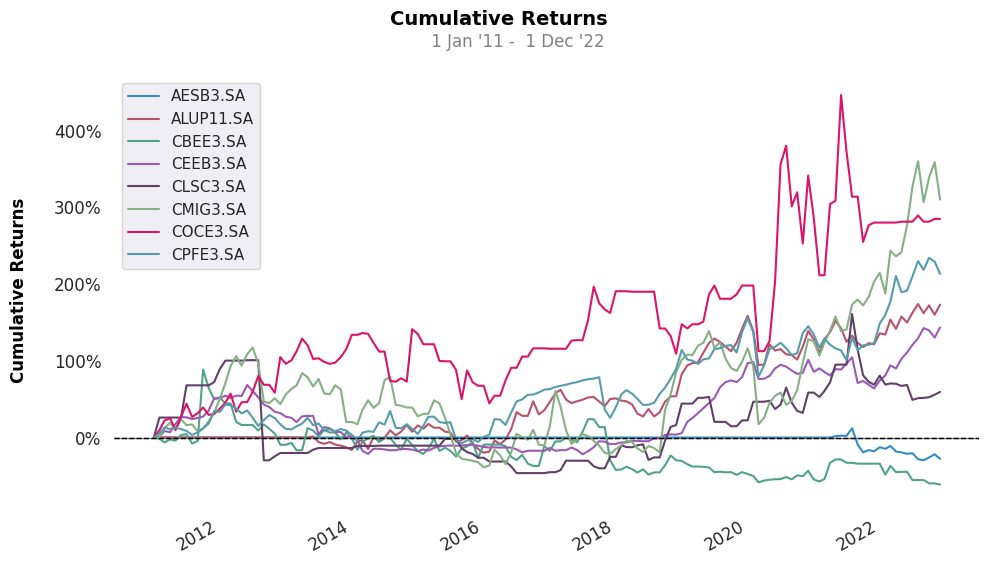

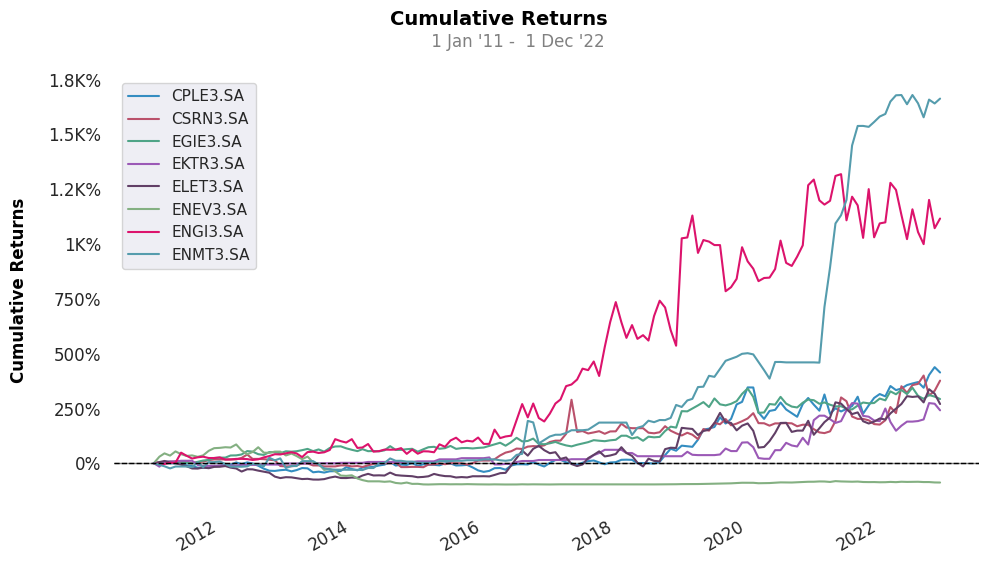

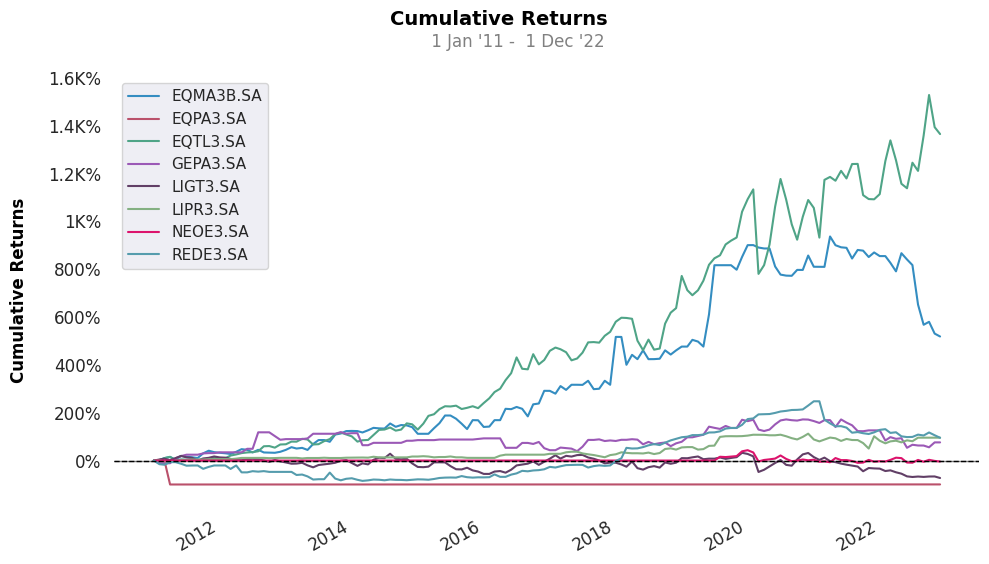

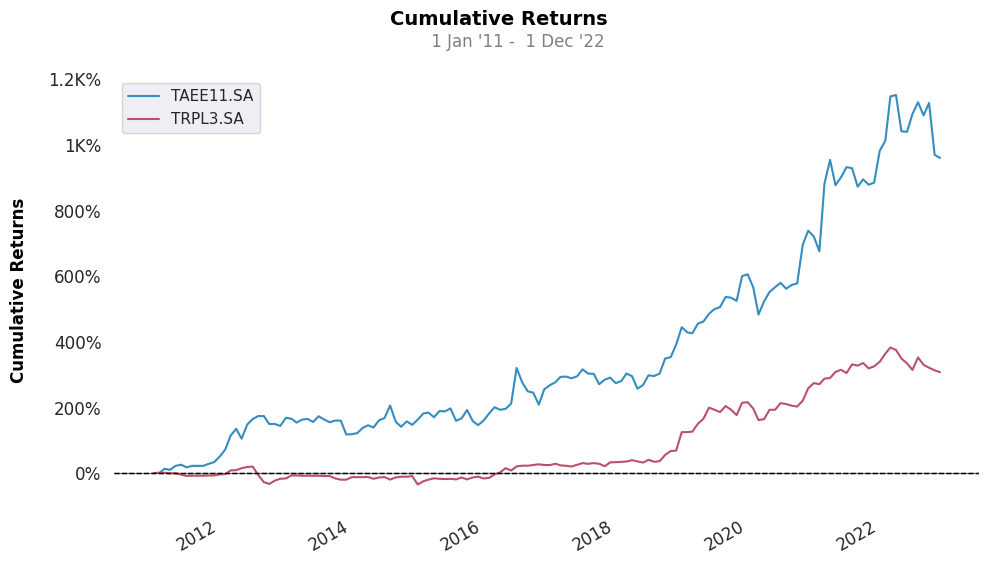

In [77]:
tickers_elet = ["ALUP11.SA","AESB3.SA","CBEE3.SA","CMIG3.SA",
                "CLSC3.SA","CPLE3.SA","CSRN3.SA","CPFE3.SA",
                "EKTR3.SA","ELET3.SA","ENMT3.SA","COCE3.SA",
                "LIPR3.SA","ENGI3.SA","EQTL3.SA","TRPL3.SA",
                "EGIE3.SA",'ENEV3.SA',"EQPA3.SA","CEEB3.SA",
                "EQMA3B.SA","NEOE3.SA","GEPA3.SA","LIGT3.SA",
                "REDE3.SA","TAEE11.SA"]

data_inicio = "2011-01-01"
data_fim = "2022-12-31"

retornos = yf.download(tickers_elet, start=data_inicio, end=data_fim, interval='1mo')['Adj Close'].pct_change().fillna(0)
#acumulado = (1 + retornos).cumprod()
retornos.column = tickers_elet
retornos.index = pd.to_datetime(retornos.index).to_period('M').to_timestamp()
#retornos
# qs.plots.returns(retornos['ALUP11.SA'],retornos['AESB3.SA'],retornos['CBEE3.SA'],retornos['TRPL3.SA']
#                 retornos['CMIG3.SA'],retornos['CLSC3.SA'],retornos['CPLE3.SA'],retornos['CSRN3.SA'],
#                 retornos['CPFE3.SA'],retornos['EKTR3.SA'],retornos['ELET3.SA'],retornos['ENMT3.SA'],
#                 retornos['COCE3.SA'],retornos['LIPR3.SA'],retornos['ENGI3.SA'],retornos['EQTL3.SA'],
#                 retornos['EGIE3.SA'],retornos['ENEV3.SA'],retornos['GEPA3.SA'],retornos['CEEB3.SA'],
#                 retornos['EQMA3B.SA'],retornos['NEOE3.SA'],retornos['EQPA3.SA'],retornos['LIGT3.SA'],
#                 retornos['REDE3.SA'],retornos['TAEE11.SA'])
retornos2 = retornos.iloc[:,:4]
qs.plots.returns(retornos.iloc[:,:8])
qs.plots.returns(retornos.iloc[:,8:16])
qs.plots.returns(retornos.iloc[:,16:24])
qs.plots.returns(retornos.iloc[:,24:26])
#retornos['CEBR3.SA']